In [1]:
import torch.cuda
import sys

sys.path.append('..')
SEED=1

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from WeightsModification import * 
from federated_pure import federate




In [2]:
class FakeArgs:
    def __init__(self):
        self.seed=4237987
        self.epochs = 10
        self.dataset = "mnist"
        self.num_users=5
        self.iid = 3
        self.dirichlet = 0.5 
        self.local_ep=10
        self.local_bs=64
        self.beta=1.0
        self.frac_split=0.4
    # def __init__(self):
    #     self.seed=SEED
    #     self.epochs = 25
    #     self.dataset = "fmnist"
    #     self.num_users=10
    #     self.iid = 2
    #     self.dirichlet = 0.5 
    #     self.local_ep=10
    #     self.local_bs=64
    #     self.beta=1.0
        

In [3]:
alpha_values = [0.1,0.5,1.0,2.0]
vae_beta_values = [1.0,5.0,10.0]

for vae_beta_val in vae_beta_values:
    runtime_args = FakeArgs()
    runtime_args.beta=vae_beta_val
    
    baseline_result = federate(runtime_args)
    baseline_result.serialise("baseline", runtime_args)
    
    for alpha in alpha_values:
        new_weights = calculate_new_weights(baseline_result.global_model.encoder, baseline_result.client_datasets, alpha,0.0)

        second_res = federate(runtime_args,new_weights, baseline_result.client_datasets)
        second_res.serialise("alpha_" + str(alpha),runtime_args)
        
    
    
    
    
    





Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1855965.82it/s]


Extracting ../data/fmnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/fmnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 265101.39it/s]


Extracting ../data/fmnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/fmnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2593853.86it/s]


Extracting ../data/fmnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/fmnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3023893.46it/s]
/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Extracting ../data/fmnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/fmnist/MNIST/raw



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 653.9612480839596
Finished local epoch 2 out of 10, average loss across batches: 577.4945276960542
Finished local epoch 3 out of 10, average loss across batches: 564.55893678303
Finished local epoch 4 out of 10, average loss across batches: 556.3012618052809
Finished local epoch 5 out of 10, average loss across batches: 551.589879289458
Finished local epoch 6 out of 10, average loss across batches: 548.4134204719641
Finished local epoch 7 out of 10, average loss across batches: 546.2145080566406
Finished local epoch 8 out of 10, average loss across batches: 544.6632910619808
Finished local epoch 9 out of 10, average loss across batches: 542.6143961073477
Finished local epoch 10 out of 10, average loss across batches: 540.6417626489567
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 618.7817435128349
Finished local epoch 2 o

  4%|▍         | 1/25 [01:35<38:15, 95.63s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 641.1086747314453

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 580.6341962210739
Finished local epoch 2 out of 10, average loss across batches: 551.5340182147448
Finished local epoch 3 out of 10, average loss across batches: 546.5863187765773
Finished local epoch 4 out of 10, average loss across batches: 542.8321591147893
Finished local epoch 5 out of 10, average loss across batches: 540.6564817790744
Finished local epoch 6 out of 10, average loss across batches: 538.6434770415101
Finished local epoch 7 out of 10, average loss across batches: 537.0063631081883
Finished local epoch 8 out of 10, average loss across batches: 535.2170896892306
Finished local epoch 9 out of 10, average loss across batches: 533.6257335807703
Finished local epoch 10 out of 10, average loss across batches: 532.3475442234474
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss a

  8%|▊         | 2/25 [03:07<35:50, 93.50s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 579.991667956543

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 553.5684219553501
Finished local epoch 2 out of 10, average loss across batches: 537.0378997416436
Finished local epoch 3 out of 10, average loss across batches: 531.4906708922567
Finished local epoch 4 out of 10, average loss across batches: 528.3714093558395
Finished local epoch 5 out of 10, average loss across batches: 526.4634681411936
Finished local epoch 6 out of 10, average loss across batches: 524.9317769883554
Finished local epoch 7 out of 10, average loss across batches: 523.710055580622
Finished local epoch 8 out of 10, average loss across batches: 522.6327282869363
Finished local epoch 9 out of 10, average loss across batches: 521.506483633307
Finished local epoch 10 out of 10, average loss across batches: 520.5239099430132
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss acro

 12%|█▏        | 3/25 [04:40<34:09, 93.18s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 546.6135340515136

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 536.1782369492929
Finished local epoch 2 out of 10, average loss across batches: 526.3322371470778
Finished local epoch 3 out of 10, average loss across batches: 523.495967044106
Finished local epoch 4 out of 10, average loss across batches: 520.9756736272498
Finished local epoch 5 out of 10, average loss across batches: 519.1263319570807
Finished local epoch 6 out of 10, average loss across batches: 518.0824855369858
Finished local epoch 7 out of 10, average loss across batches: 517.1287849522844
Finished local epoch 8 out of 10, average loss across batches: 515.907547576518
Finished local epoch 9 out of 10, average loss across batches: 515.0160306133802
Finished local epoch 10 out of 10, average loss across batches: 514.6137034742138
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss acr

 16%|█▌        | 4/25 [06:14<32:40, 93.34s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 534.5681781845093

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 527.5571837606309
Finished local epoch 2 out of 10, average loss across batches: 520.8867697413964
Finished local epoch 3 out of 10, average loss across batches: 519.011451817766
Finished local epoch 4 out of 10, average loss across batches: 517.4418771478195
Finished local epoch 5 out of 10, average loss across batches: 515.9115592859969
Finished local epoch 6 out of 10, average loss across batches: 514.6325355240061
Finished local epoch 7 out of 10, average loss across batches: 514.312305691876
Finished local epoch 8 out of 10, average loss across batches: 513.415632030632
Finished local epoch 9 out of 10, average loss across batches: 512.6986678883999
Finished local epoch 10 out of 10, average loss across batches: 512.3743711061115
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss acro

 20%|██        | 5/25 [07:47<31:09, 93.46s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 528.4200248291015

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 523.1550965128066
Finished local epoch 2 out of 10, average loss across batches: 518.8121005673952
Finished local epoch 3 out of 10, average loss across batches: 516.7558203588558
Finished local epoch 4 out of 10, average loss across batches: 515.2035549501829
Finished local epoch 5 out of 10, average loss across batches: 514.1605742249308
Finished local epoch 6 out of 10, average loss across batches: 513.5104756415644
Finished local epoch 7 out of 10, average loss across batches: 512.9142610574071
Finished local epoch 8 out of 10, average loss across batches: 512.7755772071548
Finished local epoch 9 out of 10, average loss across batches: 511.6256215542178
Finished local epoch 10 out of 10, average loss across batches: 510.676640377769
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss ac

 24%|██▍       | 6/25 [09:20<29:30, 93.21s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 517.0510865982055

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 519.6631956462619
Finished local epoch 2 out of 10, average loss across batches: 515.6182158264933
Finished local epoch 3 out of 10, average loss across batches: 514.4185416306121
Finished local epoch 4 out of 10, average loss across batches: 513.7716276917276
Finished local epoch 5 out of 10, average loss across batches: 512.1742070837865
Finished local epoch 6 out of 10, average loss across batches: 511.901584287233
Finished local epoch 7 out of 10, average loss across batches: 510.78912662554393
Finished local epoch 8 out of 10, average loss across batches: 509.99087717563293
Finished local epoch 9 out of 10, average loss across batches: 509.36762092686905
Finished local epoch 10 out of 10, average loss across batches: 510.12738037109375
Training user 1 in round 7
Finished local epoch 1 out of 10, average los

 28%|██▊       | 7/25 [10:53<27:54, 93.03s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 512.4855479736328

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 517.4705663753462
Finished local epoch 2 out of 10, average loss across batches: 514.3454377379599
Finished local epoch 3 out of 10, average loss across batches: 513.2565999091426
Finished local epoch 4 out of 10, average loss across batches: 511.27412317976166
Finished local epoch 5 out of 10, average loss across batches: 510.7314433810077
Finished local epoch 6 out of 10, average loss across batches: 509.9620708996737
Finished local epoch 7 out of 10, average loss across batches: 508.90597031991695
Finished local epoch 8 out of 10, average loss across batches: 508.2125591809237
Finished local epoch 9 out of 10, average loss across batches: 507.9248348187797
Finished local epoch 10 out of 10, average loss across batches: 507.5092792752423
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss

 32%|███▏      | 8/25 [12:25<26:19, 92.93s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 509.53889281921386

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 515.6907082086877
Finished local epoch 2 out of 10, average loss across batches: 512.6640740889537
Finished local epoch 3 out of 10, average loss across batches: 511.17117541349387
Finished local epoch 4 out of 10, average loss across batches: 509.94611213780655
Finished local epoch 5 out of 10, average loss across batches: 508.70464740222013
Finished local epoch 6 out of 10, average loss across batches: 508.0776521706883
Finished local epoch 7 out of 10, average loss across batches: 507.83261880995354
Finished local epoch 8 out of 10, average loss across batches: 507.04038248182854
Finished local epoch 9 out of 10, average loss across batches: 506.6284295577037
Finished local epoch 10 out of 10, average loss across batches: 506.13434958156154
Training user 1 in round 9
Finished local epoch 1 out of 10, average

 36%|███▌      | 9/25 [13:59<24:49, 93.11s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 507.53160494384764

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 514.3839636694026
Finished local epoch 2 out of 10, average loss across batches: 511.20763580708564
Finished local epoch 3 out of 10, average loss across batches: 509.887170719195
Finished local epoch 4 out of 10, average loss across batches: 508.8070161071005
Finished local epoch 5 out of 10, average loss across batches: 508.1700261755835
Finished local epoch 6 out of 10, average loss across batches: 507.77086359337915
Finished local epoch 7 out of 10, average loss across batches: 507.0526293018196
Finished local epoch 8 out of 10, average loss across batches: 507.54456145853936
Finished local epoch 9 out of 10, average loss across batches: 506.558494084998
Finished local epoch 10 out of 10, average loss across batches: 506.20158212396166
Training user 1 in round 10
Finished local epoch 1 out of 10, average 

 40%|████      | 10/25 [15:32<23:14, 93.00s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 505.7840282119751

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 512.7374893381626
Finished local epoch 2 out of 10, average loss across batches: 510.84089409550535
Finished local epoch 3 out of 10, average loss across batches: 509.19037483311905
Finished local epoch 4 out of 10, average loss across batches: 508.21201295490505
Finished local epoch 5 out of 10, average loss across batches: 507.2194665836383
Finished local epoch 6 out of 10, average loss across batches: 506.30215492731406
Finished local epoch 7 out of 10, average loss across batches: 506.16823220554784
Finished local epoch 8 out of 10, average loss across batches: 505.3691912300979
Finished local epoch 9 out of 10, average loss across batches: 504.94233259370054
Finished local epoch 10 out of 10, average loss across batches: 504.52316593218455
Training user 1 in round 11
Finished local epoch 1 out of 10, ave

 44%|████▍     | 11/25 [17:04<21:39, 92.82s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 504.7471157470703

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 512.8114396107347
Finished local epoch 2 out of 10, average loss across batches: 510.2814022015922
Finished local epoch 3 out of 10, average loss across batches: 508.73048381563984
Finished local epoch 4 out of 10, average loss across batches: 507.81012890006923
Finished local epoch 5 out of 10, average loss across batches: 506.77560888362837
Finished local epoch 6 out of 10, average loss across batches: 506.16312495364417
Finished local epoch 7 out of 10, average loss across batches: 505.59625862218155
Finished local epoch 8 out of 10, average loss across batches: 504.74221338199663
Finished local epoch 9 out of 10, average loss across batches: 504.8307885278629
Finished local epoch 10 out of 10, average loss across batches: 504.7490392757367
Training user 1 in round 12
Finished local epoch 1 out of 10, aver

 48%|████▊     | 12/25 [18:37<20:06, 92.80s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 503.5672254394531

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 511.7408227075504
Finished local epoch 2 out of 10, average loss across batches: 509.21991623504255
Finished local epoch 3 out of 10, average loss across batches: 507.68684561041334
Finished local epoch 4 out of 10, average loss across batches: 506.61798366112043
Finished local epoch 5 out of 10, average loss across batches: 506.0930635476414
Finished local epoch 6 out of 10, average loss across batches: 505.91444184508504
Finished local epoch 7 out of 10, average loss across batches: 504.6050863145273
Finished local epoch 8 out of 10, average loss across batches: 504.3646545410156
Finished local epoch 9 out of 10, average loss across batches: 504.2482856074466
Finished local epoch 10 out of 10, average loss across batches: 503.8867411553105
Training user 1 in round 13
Finished local epoch 1 out of 10, averag

 52%|█████▏    | 13/25 [20:10<18:36, 93.00s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 502.56422930145266

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 510.9669521669798
Finished local epoch 2 out of 10, average loss across batches: 508.4062163920342
Finished local epoch 3 out of 10, average loss across batches: 506.67930815491496
Finished local epoch 4 out of 10, average loss across batches: 505.83502390414856
Finished local epoch 5 out of 10, average loss across batches: 505.45133952853047
Finished local epoch 6 out of 10, average loss across batches: 504.5359296195115
Finished local epoch 7 out of 10, average loss across batches: 504.3847258362589
Finished local epoch 8 out of 10, average loss across batches: 503.6423691375346
Finished local epoch 9 out of 10, average loss across batches: 503.83008391947686
Finished local epoch 10 out of 10, average loss across batches: 503.8388575300386
Training user 1 in round 14
Finished local epoch 1 out of 10, avera

 56%|█████▌    | 14/25 [21:43<17:02, 92.95s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 501.8848842803955

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 510.3470795064033
Finished local epoch 2 out of 10, average loss across batches: 507.8039504425435
Finished local epoch 3 out of 10, average loss across batches: 506.32075712952434
Finished local epoch 4 out of 10, average loss across batches: 505.5610776490803
Finished local epoch 5 out of 10, average loss across batches: 505.18800334688984
Finished local epoch 6 out of 10, average loss across batches: 504.41217697723005
Finished local epoch 7 out of 10, average loss across batches: 503.5925578829608
Finished local epoch 8 out of 10, average loss across batches: 503.6078448718107
Finished local epoch 9 out of 10, average loss across batches: 502.9934224961679
Finished local epoch 10 out of 10, average loss across batches: 502.0523113781893
Training user 1 in round 15
Finished local epoch 1 out of 10, average

 60%|██████    | 15/25 [23:15<15:27, 92.77s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 501.30066669311526

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 509.5456353682506
Finished local epoch 2 out of 10, average loss across batches: 507.18827143801917
Finished local epoch 3 out of 10, average loss across batches: 506.15276636051226
Finished local epoch 4 out of 10, average loss across batches: 505.2439922863924
Finished local epoch 5 out of 10, average loss across batches: 504.6846305750593
Finished local epoch 6 out of 10, average loss across batches: 504.055646292771
Finished local epoch 7 out of 10, average loss across batches: 503.35329736637163
Finished local epoch 8 out of 10, average loss across batches: 503.06787534303305
Finished local epoch 9 out of 10, average loss across batches: 502.9208416516268
Finished local epoch 10 out of 10, average loss across batches: 501.88763157325457
Training user 1 in round 16
Finished local epoch 1 out of 10, avera

 64%|██████▍   | 16/25 [24:49<13:57, 93.03s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 500.62936057739256

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 508.9041508541832
Finished local epoch 2 out of 10, average loss across batches: 506.2885093206092
Finished local epoch 3 out of 10, average loss across batches: 504.92169653011274
Finished local epoch 4 out of 10, average loss across batches: 504.8329838619957
Finished local epoch 5 out of 10, average loss across batches: 503.48248561424543
Finished local epoch 6 out of 10, average loss across batches: 502.7948565905607
Finished local epoch 7 out of 10, average loss across batches: 502.66865481606015
Finished local epoch 8 out of 10, average loss across batches: 502.4930520359474
Finished local epoch 9 out of 10, average loss across batches: 502.23934241186214
Finished local epoch 10 out of 10, average loss across batches: 501.3785129981705
Training user 1 in round 17
Finished local epoch 1 out of 10, avera

 68%|██████▊   | 17/25 [26:22<12:23, 92.98s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 500.3132669921875

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 508.67578086370156
Finished local epoch 2 out of 10, average loss across batches: 505.70751528196695
Finished local epoch 3 out of 10, average loss across batches: 504.684316900712
Finished local epoch 4 out of 10, average loss across batches: 503.8284483318087
Finished local epoch 5 out of 10, average loss across batches: 503.01711302165745
Finished local epoch 6 out of 10, average loss across batches: 503.36565041843846
Finished local epoch 7 out of 10, average loss across batches: 502.85266151911094
Finished local epoch 8 out of 10, average loss across batches: 502.6742611655706
Finished local epoch 9 out of 10, average loss across batches: 501.94331379178203
Finished local epoch 10 out of 10, average loss across batches: 501.87635590758504
Training user 1 in round 18
Finished local epoch 1 out of 10, aver

 72%|███████▏  | 18/25 [27:54<10:50, 92.87s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 499.67157213745116

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 508.46638044526304
Finished local epoch 2 out of 10, average loss across batches: 505.71954345703125
Finished local epoch 3 out of 10, average loss across batches: 504.91929838928996
Finished local epoch 4 out of 10, average loss across batches: 504.04477237749705
Finished local epoch 5 out of 10, average loss across batches: 502.77751719800733
Finished local epoch 6 out of 10, average loss across batches: 502.40727484980715
Finished local epoch 7 out of 10, average loss across batches: 501.9434323854084
Finished local epoch 8 out of 10, average loss across batches: 501.46005828471124
Finished local epoch 9 out of 10, average loss across batches: 501.60417889945114
Finished local epoch 10 out of 10, average loss across batches: 500.8392333984375
Training user 1 in round 19
Finished local epoch 1 out of 10, a

 76%|███████▌  | 19/25 [29:28<09:17, 92.96s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 499.3596292984009

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 507.3337699793562
Finished local epoch 2 out of 10, average loss across batches: 505.75618695609177
Finished local epoch 3 out of 10, average loss across batches: 504.6847827766515
Finished local epoch 4 out of 10, average loss across batches: 505.11645082884195
Finished local epoch 5 out of 10, average loss across batches: 503.3478830071944
Finished local epoch 6 out of 10, average loss across batches: 502.6744585640823
Finished local epoch 7 out of 10, average loss across batches: 502.8358424705795
Finished local epoch 8 out of 10, average loss across batches: 501.84707371192644
Finished local epoch 9 out of 10, average loss across batches: 501.1842438903036
Finished local epoch 10 out of 10, average loss across batches: 501.11581536787975
Training user 1 in round 20
Finished local epoch 1 out of 10, averag

 80%|████████  | 20/25 [31:00<07:43, 92.68s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 499.25926535186767

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 507.65665522708167
Finished local epoch 2 out of 10, average loss across batches: 505.4992791670787
Finished local epoch 3 out of 10, average loss across batches: 504.17444272584555
Finished local epoch 4 out of 10, average loss across batches: 503.14252636100673
Finished local epoch 5 out of 10, average loss across batches: 502.76079240629946
Finished local epoch 6 out of 10, average loss across batches: 501.6043917499011
Finished local epoch 7 out of 10, average loss across batches: 501.0341680985463
Finished local epoch 8 out of 10, average loss across batches: 500.9046426121193
Finished local epoch 9 out of 10, average loss across batches: 500.57218411602554
Finished local epoch 10 out of 10, average loss across batches: 499.8624754314181
Training user 1 in round 21
Finished local epoch 1 out of 10, aver

 84%|████████▍ | 21/25 [32:34<06:12, 93.03s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 498.70341658172606

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 507.0331679718404
Finished local epoch 2 out of 10, average loss across batches: 504.6268573229826
Finished local epoch 3 out of 10, average loss across batches: 504.18326153332674
Finished local epoch 4 out of 10, average loss across batches: 503.1337473422666
Finished local epoch 5 out of 10, average loss across batches: 502.4918610778036
Finished local epoch 6 out of 10, average loss across batches: 501.71876931492284
Finished local epoch 7 out of 10, average loss across batches: 501.07579871069026
Finished local epoch 8 out of 10, average loss across batches: 500.17508436758305
Finished local epoch 9 out of 10, average loss across batches: 500.18871181826046
Finished local epoch 10 out of 10, average loss across batches: 500.2398855474931
Training user 1 in round 22
Finished local epoch 1 out of 10, aver

 88%|████████▊ | 22/25 [34:07<04:39, 93.30s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 498.4166515548706

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 506.72533754759195
Finished local epoch 2 out of 10, average loss across batches: 504.53927728194225
Finished local epoch 3 out of 10, average loss across batches: 503.0493731921232
Finished local epoch 4 out of 10, average loss across batches: 502.25973472112344
Finished local epoch 5 out of 10, average loss across batches: 501.9336995957773
Finished local epoch 6 out of 10, average loss across batches: 501.4618993831586
Finished local epoch 7 out of 10, average loss across batches: 500.4002179495896
Finished local epoch 8 out of 10, average loss across batches: 500.8591405168364
Finished local epoch 9 out of 10, average loss across batches: 500.6493537999407
Finished local epoch 10 out of 10, average loss across batches: 500.2534739820263
Training user 1 in round 23
Finished local epoch 1 out of 10, average

 92%|█████████▏| 23/25 [35:40<03:06, 93.10s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 498.1782294204712

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 506.63822879066953
Finished local epoch 2 out of 10, average loss across batches: 504.5096068563341
Finished local epoch 3 out of 10, average loss across batches: 503.46574228021166
Finished local epoch 4 out of 10, average loss across batches: 502.2402424872676
Finished local epoch 5 out of 10, average loss across batches: 501.30482193186316
Finished local epoch 6 out of 10, average loss across batches: 501.1719402844393
Finished local epoch 7 out of 10, average loss across batches: 500.49691270272945
Finished local epoch 8 out of 10, average loss across batches: 499.9890101951889
Finished local epoch 9 out of 10, average loss across batches: 499.46986215325853
Finished local epoch 10 out of 10, average loss across batches: 499.2805963830103
Training user 1 in round 24
Finished local epoch 1 out of 10, avera

 96%|█████████▌| 24/25 [37:12<01:32, 92.85s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 497.81713200531004

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 506.1301284983188
Finished local epoch 2 out of 10, average loss across batches: 504.0498162764537
Finished local epoch 3 out of 10, average loss across batches: 502.9627523301523
Finished local epoch 4 out of 10, average loss across batches: 502.3192563600178
Finished local epoch 5 out of 10, average loss across batches: 501.63495220715487
Finished local epoch 6 out of 10, average loss across batches: 501.4898952049545
Finished local epoch 7 out of 10, average loss across batches: 501.54704883430577
Finished local epoch 8 out of 10, average loss across batches: 501.0819026126137
Finished local epoch 9 out of 10, average loss across batches: 500.11714887015427
Finished local epoch 10 out of 10, average loss across batches: 499.41535544093654
Training user 1 in round 25
Finished local epoch 1 out of 10, avera

100%|██████████| 25/25 [38:45<00:00, 93.01s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 497.809076020813
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 653.9612480839596
Finished local epoch 2 out of 10, average loss across batches: 577.4945276960542
Finished local epoch 3 out of 10, average loss across batches: 564.55893678303
Finished local epoch 4 out of 10, average loss across batches: 556.3012618052809
Finished local epoch 5 out of 10, average loss across batches: 551.589879289458
Finished local epoch 6 out of 10, average loss across batches: 548.4134204719641
Finished local epoch 7 out of 10, average loss across batches: 546.2145080566406
Finished local epoch 8 out of 10, average loss across batches: 544.6632910619808
Finished local epoch 9 out of 10, average loss across batches: 542.6143961073477
Finished local epoch 10 out of 10, average loss across batches: 540.6417626489567
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 618.7817435128349
Finished local epoch 2 o

  4%|▍         | 1/25 [01:34<37:39, 94.14s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 641.836839654541

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 580.3834104900119
Finished local epoch 2 out of 10, average loss across batches: 551.4449045688291
Finished local epoch 3 out of 10, average loss across batches: 547.2804302746737
Finished local epoch 4 out of 10, average loss across batches: 543.5313743881032
Finished local epoch 5 out of 10, average loss across batches: 540.7085401317742
Finished local epoch 6 out of 10, average loss across batches: 538.4597956017603
Finished local epoch 7 out of 10, average loss across batches: 537.1309219553501
Finished local epoch 8 out of 10, average loss across batches: 535.4324097452285
Finished local epoch 9 out of 10, average loss across batches: 534.078473827507
Finished local epoch 10 out of 10, average loss across batches: 533.2542736198328
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss acr

  8%|▊         | 2/25 [03:07<35:56, 93.77s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 576.044805114746

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 550.103692935992
Finished local epoch 2 out of 10, average loss across batches: 535.0073087668117
Finished local epoch 3 out of 10, average loss across batches: 530.7690020211136
Finished local epoch 4 out of 10, average loss across batches: 528.244443869289
Finished local epoch 5 out of 10, average loss across batches: 526.1163673883752
Finished local epoch 6 out of 10, average loss across batches: 524.5669528623171
Finished local epoch 7 out of 10, average loss across batches: 523.7720472118523
Finished local epoch 8 out of 10, average loss across batches: 522.4192354226415
Finished local epoch 9 out of 10, average loss across batches: 521.2406948427611
Finished local epoch 10 out of 10, average loss across batches: 520.3885351253462
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss acro

 12%|█▏        | 3/25 [04:40<34:11, 93.24s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 544.2524977996826

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 534.5400309502324
Finished local epoch 2 out of 10, average loss across batches: 525.3694593212273
Finished local epoch 3 out of 10, average loss across batches: 522.8460059829905
Finished local epoch 4 out of 10, average loss across batches: 520.6178082816208
Finished local epoch 5 out of 10, average loss across batches: 519.3153195924397
Finished local epoch 6 out of 10, average loss across batches: 517.554849745352
Finished local epoch 7 out of 10, average loss across batches: 516.9236739919155
Finished local epoch 8 out of 10, average loss across batches: 517.187585371959
Finished local epoch 9 out of 10, average loss across batches: 515.5605797103689
Finished local epoch 10 out of 10, average loss across batches: 514.4618966790695
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss acr

 16%|█▌        | 4/25 [06:13<32:37, 93.20s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 533.1249522247315

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 527.3118015723892
Finished local epoch 2 out of 10, average loss across batches: 520.8176323613034
Finished local epoch 3 out of 10, average loss across batches: 518.4871582803847
Finished local epoch 4 out of 10, average loss across batches: 516.5900604634345
Finished local epoch 5 out of 10, average loss across batches: 515.4230176708367
Finished local epoch 6 out of 10, average loss across batches: 514.3384117416189
Finished local epoch 7 out of 10, average loss across batches: 514.9476839862292
Finished local epoch 8 out of 10, average loss across batches: 512.8533549248418
Finished local epoch 9 out of 10, average loss across batches: 512.5050975944422
Finished local epoch 10 out of 10, average loss across batches: 511.4559152337569
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss a

 20%|██        | 5/25 [07:47<31:08, 93.45s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 526.2904404769897

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 523.0484275334998
Finished local epoch 2 out of 10, average loss across batches: 518.4418427672567
Finished local epoch 3 out of 10, average loss across batches: 516.4385685015328
Finished local epoch 4 out of 10, average loss across batches: 515.1245221488083
Finished local epoch 5 out of 10, average loss across batches: 514.0343523629105
Finished local epoch 6 out of 10, average loss across batches: 513.0918807017653
Finished local epoch 7 out of 10, average loss across batches: 512.5343481136274
Finished local epoch 8 out of 10, average loss across batches: 511.28545485870745
Finished local epoch 9 out of 10, average loss across batches: 510.9991833650613
Finished local epoch 10 out of 10, average loss across batches: 510.24258963669405
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss

 24%|██▍       | 6/25 [09:20<29:36, 93.48s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 515.8353648132324

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 519.7862232063391
Finished local epoch 2 out of 10, average loss across batches: 515.5755924273141
Finished local epoch 3 out of 10, average loss across batches: 514.2240782146213
Finished local epoch 4 out of 10, average loss across batches: 512.5973835232892
Finished local epoch 5 out of 10, average loss across batches: 511.84279622910896
Finished local epoch 6 out of 10, average loss across batches: 510.61114308803894
Finished local epoch 7 out of 10, average loss across batches: 510.65800727168215
Finished local epoch 8 out of 10, average loss across batches: 509.38920419427416
Finished local epoch 9 out of 10, average loss across batches: 509.216389716426
Finished local epoch 10 out of 10, average loss across batches: 508.66388248491893
Training user 1 in round 7
Finished local epoch 1 out of 10, average lo

 28%|██▊       | 7/25 [10:54<28:03, 93.52s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 511.4576864822388

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 516.8942863367781
Finished local epoch 2 out of 10, average loss across batches: 513.4730974028382
Finished local epoch 3 out of 10, average loss across batches: 511.76621603663966
Finished local epoch 4 out of 10, average loss across batches: 510.8534232996687
Finished local epoch 5 out of 10, average loss across batches: 509.9461067296282
Finished local epoch 6 out of 10, average loss across batches: 508.94365527961827
Finished local epoch 7 out of 10, average loss across batches: 508.05843961691556
Finished local epoch 8 out of 10, average loss across batches: 507.5729246501681
Finished local epoch 9 out of 10, average loss across batches: 507.58207490172566
Finished local epoch 10 out of 10, average loss across batches: 506.6407957439181
Training user 1 in round 8
Finished local epoch 1 out of 10, average lo

 32%|███▏      | 8/25 [12:28<26:33, 93.74s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 508.74135782318115

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 515.0548238633554
Finished local epoch 2 out of 10, average loss across batches: 512.5464013980913
Finished local epoch 3 out of 10, average loss across batches: 510.7824877002571
Finished local epoch 4 out of 10, average loss across batches: 509.5068977452532
Finished local epoch 5 out of 10, average loss across batches: 508.9079933649377
Finished local epoch 6 out of 10, average loss across batches: 507.6684075850475
Finished local epoch 7 out of 10, average loss across batches: 507.5029034192049
Finished local epoch 8 out of 10, average loss across batches: 506.55595803562596
Finished local epoch 9 out of 10, average loss across batches: 506.1474574608139
Finished local epoch 10 out of 10, average loss across batches: 505.91437231136274
Training user 1 in round 9
Finished local epoch 1 out of 10, average los

 36%|███▌      | 9/25 [14:01<24:54, 93.41s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 506.97325765533446

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 514.031236479554
Finished local epoch 2 out of 10, average loss across batches: 510.76846854294405
Finished local epoch 3 out of 10, average loss across batches: 510.06992311115505
Finished local epoch 4 out of 10, average loss across batches: 509.11640215523636
Finished local epoch 5 out of 10, average loss across batches: 508.60030587111845
Finished local epoch 6 out of 10, average loss across batches: 507.6063495104826
Finished local epoch 7 out of 10, average loss across batches: 506.8247541596618
Finished local epoch 8 out of 10, average loss across batches: 506.05129734473894
Finished local epoch 9 out of 10, average loss across batches: 505.55215067803107
Finished local epoch 10 out of 10, average loss across batches: 504.8945567456982
Training user 1 in round 10
Finished local epoch 1 out of 10, avera

 40%|████      | 10/25 [15:34<23:19, 93.29s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 505.4035097946167

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 513.00599960134
Finished local epoch 2 out of 10, average loss across batches: 510.01534879660306
Finished local epoch 3 out of 10, average loss across batches: 508.9464710090734
Finished local epoch 4 out of 10, average loss across batches: 507.5688063223151
Finished local epoch 5 out of 10, average loss across batches: 506.96782172480715
Finished local epoch 6 out of 10, average loss across batches: 506.31706295737735
Finished local epoch 7 out of 10, average loss across batches: 505.98781266997133
Finished local epoch 8 out of 10, average loss across batches: 505.4584084040002
Finished local epoch 9 out of 10, average loss across batches: 505.00553527059435
Finished local epoch 10 out of 10, average loss across batches: 504.6699979757961
Training user 1 in round 11
Finished local epoch 1 out of 10, average

 44%|████▍     | 11/25 [17:08<21:47, 93.43s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 504.0557971450806

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 511.76711765723894
Finished local epoch 2 out of 10, average loss across batches: 509.21857500679886
Finished local epoch 3 out of 10, average loss across batches: 507.5715996464597
Finished local epoch 4 out of 10, average loss across batches: 506.8395524809632
Finished local epoch 5 out of 10, average loss across batches: 505.7686667140526
Finished local epoch 6 out of 10, average loss across batches: 505.77333358571497
Finished local epoch 7 out of 10, average loss across batches: 505.633635315714
Finished local epoch 8 out of 10, average loss across batches: 505.04387423358384
Finished local epoch 9 out of 10, average loss across batches: 504.11872960344147
Finished local epoch 10 out of 10, average loss across batches: 503.67097840128065
Training user 1 in round 12
Finished local epoch 1 out of 10, avera

 48%|████▊     | 12/25 [18:40<20:11, 93.18s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 503.04813881988525

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 511.14929121959057
Finished local epoch 2 out of 10, average loss across batches: 508.6673827352403
Finished local epoch 3 out of 10, average loss across batches: 506.76814907411983
Finished local epoch 4 out of 10, average loss across batches: 505.8814569787134
Finished local epoch 5 out of 10, average loss across batches: 505.204888066159
Finished local epoch 6 out of 10, average loss across batches: 504.48745920688293
Finished local epoch 7 out of 10, average loss across batches: 504.14719555045986
Finished local epoch 8 out of 10, average loss across batches: 504.16672139228143
Finished local epoch 9 out of 10, average loss across batches: 503.3144685769383
Finished local epoch 10 out of 10, average loss across batches: 502.5578308105469
Training user 1 in round 13
Finished local epoch 1 out of 10, avera

 52%|█████▏    | 13/25 [20:14<18:38, 93.23s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 501.888901524353

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 511.0459146620352
Finished local epoch 2 out of 10, average loss across batches: 508.29979889302314
Finished local epoch 3 out of 10, average loss across batches: 506.74007985561707
Finished local epoch 4 out of 10, average loss across batches: 505.6057210028926
Finished local epoch 5 out of 10, average loss across batches: 504.84555633158624
Finished local epoch 6 out of 10, average loss across batches: 504.5195297048062
Finished local epoch 7 out of 10, average loss across batches: 503.95064805429195
Finished local epoch 8 out of 10, average loss across batches: 503.48284255401995
Finished local epoch 9 out of 10, average loss across batches: 503.42251664173756
Finished local epoch 10 out of 10, average loss across batches: 502.71215781682656
Training user 1 in round 14
Finished local epoch 1 out of 10, aver

 56%|█████▌    | 14/25 [21:47<17:06, 93.36s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 501.29497006073

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 510.2212153567543
Finished local epoch 2 out of 10, average loss across batches: 507.9773378010038
Finished local epoch 3 out of 10, average loss across batches: 506.7767596667326
Finished local epoch 4 out of 10, average loss across batches: 505.8828461079658
Finished local epoch 5 out of 10, average loss across batches: 504.898952822142
Finished local epoch 6 out of 10, average loss across batches: 504.4232096611699
Finished local epoch 7 out of 10, average loss across batches: 504.59996052029766
Finished local epoch 8 out of 10, average loss across batches: 503.60584809508504
Finished local epoch 9 out of 10, average loss across batches: 503.033908505983
Finished local epoch 10 out of 10, average loss across batches: 502.47049181974387
Training user 1 in round 15
Finished local epoch 1 out of 10, average los

 60%|██████    | 15/25 [23:20<15:33, 93.30s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 501.10064026031495

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 510.0887671361996
Finished local epoch 2 out of 10, average loss across batches: 507.49985204769087
Finished local epoch 3 out of 10, average loss across batches: 505.72162174273143
Finished local epoch 4 out of 10, average loss across batches: 505.0158679817296
Finished local epoch 5 out of 10, average loss across batches: 504.5122672938093
Finished local epoch 6 out of 10, average loss across batches: 504.1547886329361
Finished local epoch 7 out of 10, average loss across batches: 503.08622181566454
Finished local epoch 8 out of 10, average loss across batches: 502.4403632441653
Finished local epoch 9 out of 10, average loss across batches: 502.15847816950156
Finished local epoch 10 out of 10, average loss across batches: 501.6187311486353
Training user 1 in round 16
Finished local epoch 1 out of 10, avera

 64%|██████▍   | 16/25 [24:54<14:01, 93.55s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 500.57508207092286

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 509.54742083972013
Finished local epoch 2 out of 10, average loss across batches: 506.6828910731062
Finished local epoch 3 out of 10, average loss across batches: 505.7564160310769
Finished local epoch 4 out of 10, average loss across batches: 504.5445699571054
Finished local epoch 5 out of 10, average loss across batches: 503.6985145279124
Finished local epoch 6 out of 10, average loss across batches: 503.77236552178107
Finished local epoch 7 out of 10, average loss across batches: 502.8530760173556
Finished local epoch 8 out of 10, average loss across batches: 502.7913339349288
Finished local epoch 9 out of 10, average loss across batches: 502.11996266811707
Finished local epoch 10 out of 10, average loss across batches: 501.8139806819867
Training user 1 in round 17
Finished local epoch 1 out of 10, averag

 68%|██████▊   | 17/25 [26:28<12:27, 93.44s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 499.9740278030396

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 508.66093966327134
Finished local epoch 2 out of 10, average loss across batches: 506.3303520106062
Finished local epoch 3 out of 10, average loss across batches: 505.42860856840883
Finished local epoch 4 out of 10, average loss across batches: 504.3331059323082
Finished local epoch 5 out of 10, average loss across batches: 503.7372946437401
Finished local epoch 6 out of 10, average loss across batches: 502.83355519741394
Finished local epoch 7 out of 10, average loss across batches: 502.0472871804539
Finished local epoch 8 out of 10, average loss across batches: 501.62796870364417
Finished local epoch 9 out of 10, average loss across batches: 501.3623522022102
Finished local epoch 10 out of 10, average loss across batches: 501.6359129314181
Training user 1 in round 18
Finished local epoch 1 out of 10, averag

 72%|███████▏  | 18/25 [28:02<10:55, 93.61s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 499.77889308776855

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 508.30248250840583
Finished local epoch 2 out of 10, average loss across batches: 505.8509772578372
Finished local epoch 3 out of 10, average loss across batches: 504.84754267825355
Finished local epoch 4 out of 10, average loss across batches: 503.93871568124507
Finished local epoch 5 out of 10, average loss across batches: 503.4189263838756
Finished local epoch 6 out of 10, average loss across batches: 503.11099127274525
Finished local epoch 7 out of 10, average loss across batches: 502.39182716079904
Finished local epoch 8 out of 10, average loss across batches: 501.9123678086679
Finished local epoch 9 out of 10, average loss across batches: 501.17031126384495
Finished local epoch 10 out of 10, average loss across batches: 501.0328909958465
Training user 1 in round 19
Finished local epoch 1 out of 10, ave

 76%|███████▌  | 19/25 [29:35<09:21, 93.63s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 499.2678493423462

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 508.2622228694867
Finished local epoch 2 out of 10, average loss across batches: 505.65483189836334
Finished local epoch 3 out of 10, average loss across batches: 504.35691427882716
Finished local epoch 4 out of 10, average loss across batches: 502.95131673692146
Finished local epoch 5 out of 10, average loss across batches: 503.3247271187698
Finished local epoch 6 out of 10, average loss across batches: 503.16725564304784
Finished local epoch 7 out of 10, average loss across batches: 501.84548023079014
Finished local epoch 8 out of 10, average loss across batches: 501.58906110932554
Finished local epoch 9 out of 10, average loss across batches: 500.7017980647992
Finished local epoch 10 out of 10, average loss across batches: 500.3925132268592
Training user 1 in round 20
Finished local epoch 1 out of 10, aver

 80%|████████  | 20/25 [31:09<07:48, 93.73s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 499.05112024383544

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 507.94611870488035
Finished local epoch 2 out of 10, average loss across batches: 505.4773150093948
Finished local epoch 3 out of 10, average loss across batches: 504.1656196690813
Finished local epoch 4 out of 10, average loss across batches: 503.67938077902494
Finished local epoch 5 out of 10, average loss across batches: 502.78378875346124
Finished local epoch 6 out of 10, average loss across batches: 501.72025347359573
Finished local epoch 7 out of 10, average loss across batches: 501.5302923661244
Finished local epoch 8 out of 10, average loss across batches: 500.67135079299345
Finished local epoch 9 out of 10, average loss across batches: 500.7387285836135
Finished local epoch 10 out of 10, average loss across batches: 500.3863413364072
Training user 1 in round 21
Finished local epoch 1 out of 10, aver

 84%|████████▍ | 21/25 [32:44<06:15, 93.94s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 498.7869437225342

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 507.94711767269087
Finished local epoch 2 out of 10, average loss across batches: 505.2033166040348
Finished local epoch 3 out of 10, average loss across batches: 503.7600665514982
Finished local epoch 4 out of 10, average loss across batches: 503.060275693483
Finished local epoch 5 out of 10, average loss across batches: 502.71344264549543
Finished local epoch 6 out of 10, average loss across batches: 502.1512153722063
Finished local epoch 7 out of 10, average loss across batches: 501.6036929359919
Finished local epoch 8 out of 10, average loss across batches: 501.0367964732496
Finished local epoch 9 out of 10, average loss across batches: 500.4362190343157
Finished local epoch 10 out of 10, average loss across batches: 500.2489882843404
Training user 1 in round 22
Finished local epoch 1 out of 10, average l

 88%|████████▊ | 22/25 [34:18<04:41, 93.95s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 498.2931679824829

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 507.7466264555726
Finished local epoch 2 out of 10, average loss across batches: 504.8760812493819
Finished local epoch 3 out of 10, average loss across batches: 504.68236068532434
Finished local epoch 4 out of 10, average loss across batches: 503.09852464893197
Finished local epoch 5 out of 10, average loss across batches: 502.5444351389438
Finished local epoch 6 out of 10, average loss across batches: 501.91507923753954
Finished local epoch 7 out of 10, average loss across batches: 501.1160398072834
Finished local epoch 8 out of 10, average loss across batches: 500.96748409995547
Finished local epoch 9 out of 10, average loss across batches: 501.63521489010583
Finished local epoch 10 out of 10, average loss across batches: 501.21181671528876
Training user 1 in round 23
Finished local epoch 1 out of 10, aver

 92%|█████████▏| 23/25 [35:52<03:07, 93.93s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 498.1685857055664

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 507.14096532894087
Finished local epoch 2 out of 10, average loss across batches: 504.88424991655955
Finished local epoch 3 out of 10, average loss across batches: 503.9653942253016
Finished local epoch 4 out of 10, average loss across batches: 502.83092759530757
Finished local epoch 5 out of 10, average loss across batches: 502.24623397633997
Finished local epoch 6 out of 10, average loss across batches: 502.1028990926622
Finished local epoch 7 out of 10, average loss across batches: 501.35174367397644
Finished local epoch 8 out of 10, average loss across batches: 500.41220015513744
Finished local epoch 9 out of 10, average loss across batches: 500.0356016521212
Finished local epoch 10 out of 10, average loss across batches: 500.01385189008107
Training user 1 in round 24
Finished local epoch 1 out of 10, ave

 96%|█████████▌| 24/25 [37:25<01:33, 93.88s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 497.8796094177246

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 506.73756814304784
Finished local epoch 2 out of 10, average loss across batches: 504.43495158907734
Finished local epoch 3 out of 10, average loss across batches: 503.25118323217464
Finished local epoch 4 out of 10, average loss across batches: 503.0213688717613
Finished local epoch 5 out of 10, average loss across batches: 502.2783855969393
Finished local epoch 6 out of 10, average loss across batches: 501.53425540199765
Finished local epoch 7 out of 10, average loss across batches: 501.3930455461333
Finished local epoch 8 out of 10, average loss across batches: 500.5171072271806
Finished local epoch 9 out of 10, average loss across batches: 500.73448934434333
Finished local epoch 10 out of 10, average loss across batches: 500.45151490803005
Training user 1 in round 25
Finished local epoch 1 out of 10, aver

100%|██████████| 25/25 [38:59<00:00, 93.59s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 497.7767268569946
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 653.9612480839596
Finished local epoch 2 out of 10, average loss across batches: 577.4945276960542
Finished local epoch 3 out of 10, average loss across batches: 564.55893678303
Finished local epoch 4 out of 10, average loss across batches: 556.3012618052809
Finished local epoch 5 out of 10, average loss across batches: 551.589879289458
Finished local epoch 6 out of 10, average loss across batches: 548.4134204719641
Finished local epoch 7 out of 10, average loss across batches: 546.2145080566406
Finished local epoch 8 out of 10, average loss across batches: 544.6632910619808
Finished local epoch 9 out of 10, average loss across batches: 542.6143961073477
Finished local epoch 10 out of 10, average loss across batches: 540.6417626489567
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 618.7817435128349
Finished local epoch 2 o

  4%|▍         | 1/25 [01:33<37:13, 93.05s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 645.1446265014648

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 577.3144917548457
Finished local epoch 2 out of 10, average loss across batches: 546.820140983485
Finished local epoch 3 out of 10, average loss across batches: 541.569747345357
Finished local epoch 4 out of 10, average loss across batches: 538.8781769185126
Finished local epoch 5 out of 10, average loss across batches: 536.7337723744066
Finished local epoch 6 out of 10, average loss across batches: 534.9627623739121
Finished local epoch 7 out of 10, average loss across batches: 533.3527580937252
Finished local epoch 8 out of 10, average loss across batches: 532.7435287282436
Finished local epoch 9 out of 10, average loss across batches: 530.9476167702977
Finished local epoch 10 out of 10, average loss across batches: 530.0458092025564
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss acr

  8%|▊         | 2/25 [03:06<35:44, 93.24s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 558.9410201049805

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 546.6097574354727
Finished local epoch 2 out of 10, average loss across batches: 533.6418124814577
Finished local epoch 3 out of 10, average loss across batches: 529.8729097390477
Finished local epoch 4 out of 10, average loss across batches: 527.5945063723793
Finished local epoch 5 out of 10, average loss across batches: 526.0076081481161
Finished local epoch 6 out of 10, average loss across batches: 524.499235515353
Finished local epoch 7 out of 10, average loss across batches: 523.5508519426177
Finished local epoch 8 out of 10, average loss across batches: 522.6772287103195
Finished local epoch 9 out of 10, average loss across batches: 521.7382688884494
Finished local epoch 10 out of 10, average loss across batches: 520.8865279185621
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss ac

 12%|█▏        | 3/25 [04:40<34:20, 93.68s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 539.7064143554687

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 535.273370670367
Finished local epoch 2 out of 10, average loss across batches: 527.014779392677
Finished local epoch 3 out of 10, average loss across batches: 524.4982407968256
Finished local epoch 4 out of 10, average loss across batches: 522.8886015686808
Finished local epoch 5 out of 10, average loss across batches: 521.4219835498665
Finished local epoch 6 out of 10, average loss across batches: 520.0455619715437
Finished local epoch 7 out of 10, average loss across batches: 518.8767325485809
Finished local epoch 8 out of 10, average loss across batches: 518.3500501415398
Finished local epoch 9 out of 10, average loss across batches: 517.4897970851464
Finished local epoch 10 out of 10, average loss across batches: 516.927160721791
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss acro

 16%|█▌        | 4/25 [06:14<32:47, 93.67s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 528.4599845184326

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 527.4974067784563
Finished local epoch 2 out of 10, average loss across batches: 521.8603372694571
Finished local epoch 3 out of 10, average loss across batches: 519.7595999029618
Finished local epoch 4 out of 10, average loss across batches: 518.3117034525811
Finished local epoch 5 out of 10, average loss across batches: 517.3569351389439
Finished local epoch 6 out of 10, average loss across batches: 516.0984856327877
Finished local epoch 7 out of 10, average loss across batches: 515.3873704354975
Finished local epoch 8 out of 10, average loss across batches: 514.7953236253956
Finished local epoch 9 out of 10, average loss across batches: 513.9917030817346
Finished local epoch 10 out of 10, average loss across batches: 513.7773846976364
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss a

 20%|██        | 5/25 [07:47<31:09, 93.49s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 524.0479343048096

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 523.5990952117534
Finished local epoch 2 out of 10, average loss across batches: 519.0195606086828
Finished local epoch 3 out of 10, average loss across batches: 517.326130541065
Finished local epoch 4 out of 10, average loss across batches: 515.6382724423952
Finished local epoch 5 out of 10, average loss across batches: 514.5713682536838
Finished local epoch 6 out of 10, average loss across batches: 513.7663230413123
Finished local epoch 7 out of 10, average loss across batches: 513.2032497744017
Finished local epoch 8 out of 10, average loss across batches: 512.443454790719
Finished local epoch 9 out of 10, average loss across batches: 512.1690105969393
Finished local epoch 10 out of 10, average loss across batches: 511.3072084837322
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss acr

 24%|██▍       | 6/25 [09:20<29:31, 93.21s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 519.2415569427491

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 521.5874834664261
Finished local epoch 2 out of 10, average loss across batches: 516.9796304823477
Finished local epoch 3 out of 10, average loss across batches: 515.268613791164
Finished local epoch 4 out of 10, average loss across batches: 514.1365646169155
Finished local epoch 5 out of 10, average loss across batches: 512.7122026274476
Finished local epoch 6 out of 10, average loss across batches: 511.6287602291832
Finished local epoch 7 out of 10, average loss across batches: 510.8289532238924
Finished local epoch 8 out of 10, average loss across batches: 510.25503578668906
Finished local epoch 9 out of 10, average loss across batches: 509.4579344157931
Finished local epoch 10 out of 10, average loss across batches: 509.11152204682554
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss 

 28%|██▊       | 7/25 [10:54<28:03, 93.52s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 515.9309484817505

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 519.2636413574219
Finished local epoch 2 out of 10, average loss across batches: 515.0992172820659
Finished local epoch 3 out of 10, average loss across batches: 513.3012359232843
Finished local epoch 4 out of 10, average loss across batches: 512.3850576666337
Finished local epoch 5 out of 10, average loss across batches: 511.7645754270916
Finished local epoch 6 out of 10, average loss across batches: 510.6626768474337
Finished local epoch 7 out of 10, average loss across batches: 510.3572345202482
Finished local epoch 8 out of 10, average loss across batches: 509.37775932988035
Finished local epoch 9 out of 10, average loss across batches: 508.670672066604
Finished local epoch 10 out of 10, average loss across batches: 508.09051243262957
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss 

 32%|███▏      | 8/25 [12:28<26:32, 93.70s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 513.9413908706665

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 517.2402575529075
Finished local epoch 2 out of 10, average loss across batches: 513.6627958273585
Finished local epoch 3 out of 10, average loss across batches: 512.6242142689379
Finished local epoch 4 out of 10, average loss across batches: 511.3867921467069
Finished local epoch 5 out of 10, average loss across batches: 510.5714995951592
Finished local epoch 6 out of 10, average loss across batches: 509.3557094139389
Finished local epoch 7 out of 10, average loss across batches: 508.5191190695461
Finished local epoch 8 out of 10, average loss across batches: 507.6687247360809
Finished local epoch 9 out of 10, average loss across batches: 507.17096603973005
Finished local epoch 10 out of 10, average loss across batches: 506.79676181455204
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss

 36%|███▌      | 9/25 [14:01<24:57, 93.57s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 511.4119500442505

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 516.5061100826988
Finished local epoch 2 out of 10, average loss across batches: 512.8025377490852
Finished local epoch 3 out of 10, average loss across batches: 510.6971134234078
Finished local epoch 4 out of 10, average loss across batches: 509.47508915768395
Finished local epoch 5 out of 10, average loss across batches: 508.3520411237886
Finished local epoch 6 out of 10, average loss across batches: 507.8948704200455
Finished local epoch 7 out of 10, average loss across batches: 507.3658918549743
Finished local epoch 8 out of 10, average loss across batches: 506.6101506873022
Finished local epoch 9 out of 10, average loss across batches: 506.19885949243474
Finished local epoch 10 out of 10, average loss across batches: 505.42079954509495
Training user 1 in round 10
Finished local epoch 1 out of 10, average 

 40%|████      | 10/25 [15:36<23:28, 93.87s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 509.8408908218384

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 515.3768244876137
Finished local epoch 2 out of 10, average loss across batches: 511.83768047863924
Finished local epoch 3 out of 10, average loss across batches: 509.969843997231
Finished local epoch 4 out of 10, average loss across batches: 508.7835979220233
Finished local epoch 5 out of 10, average loss across batches: 507.8138157325455
Finished local epoch 6 out of 10, average loss across batches: 507.4251264741149
Finished local epoch 7 out of 10, average loss across batches: 506.5132531274723
Finished local epoch 8 out of 10, average loss across batches: 505.4843054662777
Finished local epoch 9 out of 10, average loss across batches: 505.0407544872429
Finished local epoch 10 out of 10, average loss across batches: 504.622016230716
Training user 1 in round 11
Finished local epoch 1 out of 10, average los

 44%|████▍     | 11/25 [17:09<21:51, 93.69s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 508.6633352478027

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 514.4025071542475
Finished local epoch 2 out of 10, average loss across batches: 510.7267529451394
Finished local epoch 3 out of 10, average loss across batches: 509.23729966562007
Finished local epoch 4 out of 10, average loss across batches: 507.63800860054886
Finished local epoch 5 out of 10, average loss across batches: 506.6232021669798
Finished local epoch 6 out of 10, average loss across batches: 506.0570273097557
Finished local epoch 7 out of 10, average loss across batches: 505.701081481161
Finished local epoch 8 out of 10, average loss across batches: 504.72719950615607
Finished local epoch 9 out of 10, average loss across batches: 504.0512587148932
Finished local epoch 10 out of 10, average loss across batches: 503.50847925113726
Training user 1 in round 12
Finished local epoch 1 out of 10, average

 48%|████▊     | 12/25 [18:43<20:18, 93.69s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 507.8337078994751

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 513.8866465121885
Finished local epoch 2 out of 10, average loss across batches: 510.2203875191604
Finished local epoch 3 out of 10, average loss across batches: 508.80351044860066
Finished local epoch 4 out of 10, average loss across batches: 507.56298325937007
Finished local epoch 5 out of 10, average loss across batches: 506.14569091796875
Finished local epoch 6 out of 10, average loss across batches: 505.62674800051917
Finished local epoch 7 out of 10, average loss across batches: 504.99597670156743
Finished local epoch 8 out of 10, average loss across batches: 504.1244769518888
Finished local epoch 9 out of 10, average loss across batches: 503.51392026490805
Finished local epoch 10 out of 10, average loss across batches: 503.28634489035306
Training user 1 in round 13
Finished local epoch 1 out of 10, ave

 52%|█████▏    | 13/25 [20:15<18:38, 93.25s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 506.9044012466431

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 512.586213703397
Finished local epoch 2 out of 10, average loss across batches: 509.6208368615259
Finished local epoch 3 out of 10, average loss across batches: 508.18913249728047
Finished local epoch 4 out of 10, average loss across batches: 506.8536322871341
Finished local epoch 5 out of 10, average loss across batches: 505.60723065726364
Finished local epoch 6 out of 10, average loss across batches: 505.4119965758505
Finished local epoch 7 out of 10, average loss across batches: 505.32480630995354
Finished local epoch 8 out of 10, average loss across batches: 504.26584441752374
Finished local epoch 9 out of 10, average loss across batches: 503.50582847112344
Finished local epoch 10 out of 10, average loss across batches: 503.26535613627374
Training user 1 in round 14
Finished local epoch 1 out of 10, avera

 56%|█████▌    | 14/25 [21:48<17:03, 93.06s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 506.6206675857544

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 512.4463458483732
Finished local epoch 2 out of 10, average loss across batches: 509.6719680979282
Finished local epoch 3 out of 10, average loss across batches: 508.1188404710987
Finished local epoch 4 out of 10, average loss across batches: 506.5294996816901
Finished local epoch 5 out of 10, average loss across batches: 505.5859320918216
Finished local epoch 6 out of 10, average loss across batches: 505.2154830739468
Finished local epoch 7 out of 10, average loss across batches: 504.72998008245156
Finished local epoch 8 out of 10, average loss across batches: 503.9035992199862
Finished local epoch 9 out of 10, average loss across batches: 503.58400368992284
Finished local epoch 10 out of 10, average loss across batches: 502.83548321301424
Training user 1 in round 15
Finished local epoch 1 out of 10, average

 60%|██████    | 15/25 [23:21<15:32, 93.21s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 505.8875114089966

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 512.2369021645076
Finished local epoch 2 out of 10, average loss across batches: 508.81969017318534
Finished local epoch 3 out of 10, average loss across batches: 507.1238770303847
Finished local epoch 4 out of 10, average loss across batches: 505.8725215090981
Finished local epoch 5 out of 10, average loss across batches: 505.1628317531151
Finished local epoch 6 out of 10, average loss across batches: 504.50619429576244
Finished local epoch 7 out of 10, average loss across batches: 503.3614613979678
Finished local epoch 8 out of 10, average loss across batches: 503.1402808080746
Finished local epoch 9 out of 10, average loss across batches: 502.6495867379104
Finished local epoch 10 out of 10, average loss across batches: 501.9379032955894
Training user 1 in round 16
Finished local epoch 1 out of 10, average 

 64%|██████▍   | 16/25 [24:55<14:00, 93.37s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 505.8774461196899

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 511.825647281695
Finished local epoch 2 out of 10, average loss across batches: 508.62412078471124
Finished local epoch 3 out of 10, average loss across batches: 507.6071306059632
Finished local epoch 4 out of 10, average loss across batches: 506.78450224671184
Finished local epoch 5 out of 10, average loss across batches: 505.12754493423654
Finished local epoch 6 out of 10, average loss across batches: 504.410463743572
Finished local epoch 7 out of 10, average loss across batches: 503.74323514141616
Finished local epoch 8 out of 10, average loss across batches: 504.4063233967069
Finished local epoch 9 out of 10, average loss across batches: 503.6499007985562
Finished local epoch 10 out of 10, average loss across batches: 502.577338496341
Training user 1 in round 17
Finished local epoch 1 out of 10, average l

 68%|██████▊   | 17/25 [26:28<12:25, 93.19s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 505.61034291687014

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 511.71563411664357
Finished local epoch 2 out of 10, average loss across batches: 508.5374836982051
Finished local epoch 3 out of 10, average loss across batches: 506.6086201728145
Finished local epoch 4 out of 10, average loss across batches: 505.77625863763353
Finished local epoch 5 out of 10, average loss across batches: 505.0372028592267
Finished local epoch 6 out of 10, average loss across batches: 503.7950292659711
Finished local epoch 7 out of 10, average loss across batches: 503.35328384592566
Finished local epoch 8 out of 10, average loss across batches: 503.47643270371833
Finished local epoch 9 out of 10, average loss across batches: 502.39041717143
Finished local epoch 10 out of 10, average loss across batches: 501.7675580374802
Training user 1 in round 18
Finished local epoch 1 out of 10, average

 72%|███████▏  | 18/25 [28:01<10:51, 93.11s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 505.31309373321534

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 511.55252654643
Finished local epoch 2 out of 10, average loss across batches: 507.834210745896
Finished local epoch 3 out of 10, average loss across batches: 506.84202285959753
Finished local epoch 4 out of 10, average loss across batches: 505.66097481643095
Finished local epoch 5 out of 10, average loss across batches: 504.309389524822
Finished local epoch 6 out of 10, average loss across batches: 503.7625033221667
Finished local epoch 7 out of 10, average loss across batches: 503.1445072994957
Finished local epoch 8 out of 10, average loss across batches: 501.8866399451147
Finished local epoch 9 out of 10, average loss across batches: 501.4872985067247
Finished local epoch 10 out of 10, average loss across batches: 501.65876209886767
Training user 1 in round 19
Finished local epoch 1 out of 10, average lo

 76%|███████▌  | 19/25 [29:33<09:17, 92.93s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 505.07675170135497

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 511.35594312450553
Finished local epoch 2 out of 10, average loss across batches: 507.7106508665447
Finished local epoch 3 out of 10, average loss across batches: 506.328242434731
Finished local epoch 4 out of 10, average loss across batches: 505.4208876211432
Finished local epoch 5 out of 10, average loss across batches: 504.2129566820362
Finished local epoch 6 out of 10, average loss across batches: 503.35491325281845
Finished local epoch 7 out of 10, average loss across batches: 502.8520994548556
Finished local epoch 8 out of 10, average loss across batches: 501.8376746841624
Finished local epoch 9 out of 10, average loss across batches: 501.08340647250793
Finished local epoch 10 out of 10, average loss across batches: 500.68988848336136
Training user 1 in round 20
Finished local epoch 1 out of 10, averag

 80%|████████  | 20/25 [31:06<07:44, 92.81s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 504.42380168609617

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 511.2319092569472
Finished local epoch 2 out of 10, average loss across batches: 507.9635674198972
Finished local epoch 3 out of 10, average loss across batches: 507.0722239047666
Finished local epoch 4 out of 10, average loss across batches: 505.0224006749407
Finished local epoch 5 out of 10, average loss across batches: 504.29222396657434
Finished local epoch 6 out of 10, average loss across batches: 503.5996267584306
Finished local epoch 7 out of 10, average loss across batches: 502.9317167257961
Finished local epoch 8 out of 10, average loss across batches: 502.21726390983486
Finished local epoch 9 out of 10, average loss across batches: 501.15318974362145
Finished local epoch 10 out of 10, average loss across batches: 500.8587746921974
Training user 1 in round 21
Finished local epoch 1 out of 10, averag

 84%|████████▍ | 21/25 [32:38<06:11, 92.83s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 503.9289527481079

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 511.15306921850276
Finished local epoch 2 out of 10, average loss across batches: 507.82679265662085
Finished local epoch 3 out of 10, average loss across batches: 505.7650876588459
Finished local epoch 4 out of 10, average loss across batches: 504.7729963471618
Finished local epoch 5 out of 10, average loss across batches: 503.8688984158673
Finished local epoch 6 out of 10, average loss across batches: 503.7501587686659
Finished local epoch 7 out of 10, average loss across batches: 502.8401655366149
Finished local epoch 8 out of 10, average loss across batches: 502.2048513678056
Finished local epoch 9 out of 10, average loss across batches: 502.2177780730815
Finished local epoch 10 out of 10, average loss across batches: 501.79568520075156
Training user 1 in round 22
Finished local epoch 1 out of 10, average

 88%|████████▊ | 22/25 [34:11<04:38, 92.90s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 503.74981660461424

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 510.32578248615505
Finished local epoch 2 out of 10, average loss across batches: 507.29520348657536
Finished local epoch 3 out of 10, average loss across batches: 506.029414309731
Finished local epoch 4 out of 10, average loss across batches: 505.07985986637163
Finished local epoch 5 out of 10, average loss across batches: 504.04435092588017
Finished local epoch 6 out of 10, average loss across batches: 503.89990157115307
Finished local epoch 7 out of 10, average loss across batches: 502.3753125154519
Finished local epoch 8 out of 10, average loss across batches: 502.37112040459357
Finished local epoch 9 out of 10, average loss across batches: 502.27423095703125
Finished local epoch 10 out of 10, average loss across batches: 501.1039262602601
Training user 1 in round 23
Finished local epoch 1 out of 10, ave

 92%|█████████▏| 23/25 [35:45<03:05, 92.98s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 503.40519923553467

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 510.6676863658277
Finished local epoch 2 out of 10, average loss across batches: 507.6120111006725
Finished local epoch 3 out of 10, average loss across batches: 505.5493720332278
Finished local epoch 4 out of 10, average loss across batches: 504.7283954861798
Finished local epoch 5 out of 10, average loss across batches: 503.4332105419304
Finished local epoch 6 out of 10, average loss across batches: 503.1483405390872
Finished local epoch 7 out of 10, average loss across batches: 502.72166925744165
Finished local epoch 8 out of 10, average loss across batches: 501.9348523103738
Finished local epoch 9 out of 10, average loss across batches: 501.47281772275517
Finished local epoch 10 out of 10, average loss across batches: 501.24020192592957
Training user 1 in round 24
Finished local epoch 1 out of 10, averag

 96%|█████████▌| 24/25 [37:17<01:32, 92.86s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 503.4830195587158

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 510.93810146669796
Finished local epoch 2 out of 10, average loss across batches: 507.41070286231707
Finished local epoch 3 out of 10, average loss across batches: 505.39884774896166
Finished local epoch 4 out of 10, average loss across batches: 504.29446140723894
Finished local epoch 5 out of 10, average loss across batches: 503.19986116433444
Finished local epoch 6 out of 10, average loss across batches: 502.17735927919796
Finished local epoch 7 out of 10, average loss across batches: 501.6495786256428
Finished local epoch 8 out of 10, average loss across batches: 501.23270194138155
Finished local epoch 9 out of 10, average loss across batches: 500.9441964837569
Finished local epoch 10 out of 10, average loss across batches: 500.4103795305083
Training user 1 in round 25
Finished local epoch 1 out of 10, ave

100%|██████████| 25/25 [38:50<00:00, 93.23s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 503.65843247528073
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 653.9612480839596
Finished local epoch 2 out of 10, average loss across batches: 577.4945276960542
Finished local epoch 3 out of 10, average loss across batches: 564.55893678303
Finished local epoch 4 out of 10, average loss across batches: 556.3012618052809
Finished local epoch 5 out of 10, average loss across batches: 551.589879289458
Finished local epoch 6 out of 10, average loss across batches: 548.4134204719641
Finished local epoch 7 out of 10, average loss across batches: 546.2145080566406
Finished local epoch 8 out of 10, average loss across batches: 544.6632910619808
Finished local epoch 9 out of 10, average loss across batches: 542.6143961073477
Finished local epoch 10 out of 10, average loss across batches: 540.6417626489567
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 618.7817435128349
Finished local epoch 2 o

  4%|▍         | 1/25 [01:32<37:06, 92.77s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 643.0870672607422

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 571.8768596407733
Finished local epoch 2 out of 10, average loss across batches: 548.9260304125049
Finished local epoch 3 out of 10, average loss across batches: 543.4735849114913
Finished local epoch 4 out of 10, average loss across batches: 539.7931951208959
Finished local epoch 5 out of 10, average loss across batches: 537.8945324088953
Finished local epoch 6 out of 10, average loss across batches: 535.7506748634048
Finished local epoch 7 out of 10, average loss across batches: 533.5014818408821
Finished local epoch 8 out of 10, average loss across batches: 532.6374979139883
Finished local epoch 9 out of 10, average loss across batches: 531.2451504091673
Finished local epoch 10 out of 10, average loss across batches: 531.3785566498962
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss a

  8%|▊         | 2/25 [03:05<35:36, 92.91s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 550.3776889434814

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 551.4223223336136
Finished local epoch 2 out of 10, average loss across batches: 542.8188781738281
Finished local epoch 3 out of 10, average loss across batches: 537.6677756007714
Finished local epoch 4 out of 10, average loss across batches: 533.3563236284859
Finished local epoch 5 out of 10, average loss across batches: 530.9316939341871
Finished local epoch 6 out of 10, average loss across batches: 529.1734116952631
Finished local epoch 7 out of 10, average loss across batches: 527.7364223818236
Finished local epoch 8 out of 10, average loss across batches: 525.688102239295
Finished local epoch 9 out of 10, average loss across batches: 524.0757164291189
Finished local epoch 10 out of 10, average loss across batches: 524.8154895637609
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss ac

 12%|█▏        | 3/25 [04:39<34:10, 93.21s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 541.7416577728271

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 546.6725989233089
Finished local epoch 2 out of 10, average loss across batches: 538.2531761459157
Finished local epoch 3 out of 10, average loss across batches: 534.4126007466376
Finished local epoch 4 out of 10, average loss across batches: 530.4114912974684
Finished local epoch 5 out of 10, average loss across batches: 527.9484913500049
Finished local epoch 6 out of 10, average loss across batches: 526.733950071697
Finished local epoch 7 out of 10, average loss across batches: 524.9973909402196
Finished local epoch 8 out of 10, average loss across batches: 526.218252447587
Finished local epoch 9 out of 10, average loss across batches: 523.7036349139636
Finished local epoch 10 out of 10, average loss across batches: 522.6875270408921
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss acr

 16%|█▌        | 4/25 [06:11<32:32, 92.98s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 536.2603706634521

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 542.766063448749
Finished local epoch 2 out of 10, average loss across batches: 535.2270024939428
Finished local epoch 3 out of 10, average loss across batches: 531.6276024927067
Finished local epoch 4 out of 10, average loss across batches: 529.3457309384889
Finished local epoch 5 out of 10, average loss across batches: 527.1940736408475
Finished local epoch 6 out of 10, average loss across batches: 526.3268162208267
Finished local epoch 7 out of 10, average loss across batches: 524.1687606618374
Finished local epoch 8 out of 10, average loss across batches: 524.0868858627126
Finished local epoch 9 out of 10, average loss across batches: 522.1937105202977
Finished local epoch 10 out of 10, average loss across batches: 522.1361624802215
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [07:45<31:04, 93.23s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 532.0980123275757

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 538.7290178129945
Finished local epoch 2 out of 10, average loss across batches: 531.335186535799
Finished local epoch 3 out of 10, average loss across batches: 527.9890067185028
Finished local epoch 4 out of 10, average loss across batches: 526.1965181374852
Finished local epoch 5 out of 10, average loss across batches: 524.2160826091525
Finished local epoch 6 out of 10, average loss across batches: 522.8861153518097
Finished local epoch 7 out of 10, average loss across batches: 521.5223929489715
Finished local epoch 8 out of 10, average loss across batches: 520.1943297567246
Finished local epoch 9 out of 10, average loss across batches: 518.9882387571697
Finished local epoch 10 out of 10, average loss across batches: 518.2720738664458
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss ac

 24%|██▍       | 6/25 [09:20<29:41, 93.77s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 530.0339379714966

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 536.6733777009988
Finished local epoch 2 out of 10, average loss across batches: 528.985646308223
Finished local epoch 3 out of 10, average loss across batches: 526.0316911528382
Finished local epoch 4 out of 10, average loss across batches: 523.9835405953323
Finished local epoch 5 out of 10, average loss across batches: 521.5466868726513
Finished local epoch 6 out of 10, average loss across batches: 521.1146777189231
Finished local epoch 7 out of 10, average loss across batches: 520.3317253016219
Finished local epoch 8 out of 10, average loss across batches: 518.9848806646805
Finished local epoch 9 out of 10, average loss across batches: 518.2817707303204
Finished local epoch 10 out of 10, average loss across batches: 516.3746631477453
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss ac

 28%|██▊       | 7/25 [10:55<28:13, 94.08s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 527.3426556732178

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 533.6719221284118
Finished local epoch 2 out of 10, average loss across batches: 526.1090933884246
Finished local epoch 3 out of 10, average loss across batches: 522.8839273573477
Finished local epoch 4 out of 10, average loss across batches: 521.192202024822
Finished local epoch 5 out of 10, average loss across batches: 519.3813804916189
Finished local epoch 6 out of 10, average loss across batches: 518.4380458397202
Finished local epoch 7 out of 10, average loss across batches: 518.0358372941802
Finished local epoch 8 out of 10, average loss across batches: 516.6123429310472
Finished local epoch 9 out of 10, average loss across batches: 516.5832963774476
Finished local epoch 10 out of 10, average loss across batches: 515.8248812518542
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss ac

 32%|███▏      | 8/25 [12:28<26:34, 93.81s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 525.5148178039551

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 531.5345775749109
Finished local epoch 2 out of 10, average loss across batches: 525.1848125216327
Finished local epoch 3 out of 10, average loss across batches: 522.3990412844887
Finished local epoch 4 out of 10, average loss across batches: 520.6492684279816
Finished local epoch 5 out of 10, average loss across batches: 518.2592020155508
Finished local epoch 6 out of 10, average loss across batches: 517.1021226327631
Finished local epoch 7 out of 10, average loss across batches: 515.7510816356804
Finished local epoch 8 out of 10, average loss across batches: 514.9710001885137
Finished local epoch 9 out of 10, average loss across batches: 513.6885036033921
Finished local epoch 10 out of 10, average loss across batches: 513.0108159705053
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss a

 36%|███▌      | 9/25 [14:03<25:06, 94.16s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 523.6762334182739

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 530.5351102804835
Finished local epoch 2 out of 10, average loss across batches: 524.6602841147893
Finished local epoch 3 out of 10, average loss across batches: 522.0134748627868
Finished local epoch 4 out of 10, average loss across batches: 521.2212559180923
Finished local epoch 5 out of 10, average loss across batches: 518.7566373800929
Finished local epoch 6 out of 10, average loss across batches: 517.1790149543859
Finished local epoch 7 out of 10, average loss across batches: 515.501690442049
Finished local epoch 8 out of 10, average loss across batches: 514.3293260019037
Finished local epoch 9 out of 10, average loss across batches: 512.9066177561314
Finished local epoch 10 out of 10, average loss across batches: 511.87036557740805
Training user 1 in round 10
Finished local epoch 1 out of 10, average los

 40%|████      | 10/25 [15:36<23:28, 93.90s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 522.0431889663696

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 530.1705248868918
Finished local epoch 2 out of 10, average loss across batches: 524.4661981123912
Finished local epoch 3 out of 10, average loss across batches: 521.312423899204
Finished local epoch 4 out of 10, average loss across batches: 518.7920037764537
Finished local epoch 5 out of 10, average loss across batches: 517.2209464930281
Finished local epoch 6 out of 10, average loss across batches: 516.9669031070757
Finished local epoch 7 out of 10, average loss across batches: 516.0207326382022
Finished local epoch 8 out of 10, average loss across batches: 514.4859626866594
Finished local epoch 9 out of 10, average loss across batches: 513.6875981198082
Finished local epoch 10 out of 10, average loss across batches: 513.0840191418612
Training user 1 in round 11
Finished local epoch 1 out of 10, average los

 44%|████▍     | 11/25 [17:10<21:55, 93.95s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 521.4894011642456

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 528.7095491433446
Finished local epoch 2 out of 10, average loss across batches: 523.2220331505885
Finished local epoch 3 out of 10, average loss across batches: 519.535635260087
Finished local epoch 4 out of 10, average loss across batches: 519.3301959460294
Finished local epoch 5 out of 10, average loss across batches: 517.1754501922221
Finished local epoch 6 out of 10, average loss across batches: 515.2136211153827
Finished local epoch 7 out of 10, average loss across batches: 513.5868731148636
Finished local epoch 8 out of 10, average loss across batches: 513.2038129975524
Finished local epoch 9 out of 10, average loss across batches: 512.7618014178698
Finished local epoch 10 out of 10, average loss across batches: 512.347163719467
Training user 1 in round 12
Finished local epoch 1 out of 10, average loss

 48%|████▊     | 12/25 [18:44<20:19, 93.79s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 520.9781356948853

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 528.8227689718898
Finished local epoch 2 out of 10, average loss across batches: 522.9796992434731
Finished local epoch 3 out of 10, average loss across batches: 521.0786874505538
Finished local epoch 4 out of 10, average loss across batches: 519.8536628047123
Finished local epoch 5 out of 10, average loss across batches: 519.0613793481755
Finished local epoch 6 out of 10, average loss across batches: 517.2556476834454
Finished local epoch 7 out of 10, average loss across batches: 514.8497955708564
Finished local epoch 8 out of 10, average loss across batches: 514.2856043562105
Finished local epoch 9 out of 10, average loss across batches: 512.7746775180478
Finished local epoch 10 out of 10, average loss across batches: 512.0912332655508
Training user 1 in round 13
Finished local epoch 1 out of 10, average lo

 52%|█████▏    | 13/25 [20:18<18:46, 93.84s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 521.191130545044

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 528.5875754054589
Finished local epoch 2 out of 10, average loss across batches: 522.418832127052
Finished local epoch 3 out of 10, average loss across batches: 518.6131970369363
Finished local epoch 4 out of 10, average loss across batches: 516.7548577031002
Finished local epoch 5 out of 10, average loss across batches: 515.3090576944472
Finished local epoch 6 out of 10, average loss across batches: 513.8880178717118
Finished local epoch 7 out of 10, average loss across batches: 513.1893550051918
Finished local epoch 8 out of 10, average loss across batches: 511.8587155885334
Finished local epoch 9 out of 10, average loss across batches: 511.67640550830697
Finished local epoch 10 out of 10, average loss across batches: 511.61714384827434
Training user 1 in round 14
Finished local epoch 1 out of 10, average lo

 56%|█████▌    | 14/25 [21:52<17:13, 94.00s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 519.8281371795654

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 527.7261433661738
Finished local epoch 2 out of 10, average loss across batches: 521.614619387856
Finished local epoch 3 out of 10, average loss across batches: 518.1824827556369
Finished local epoch 4 out of 10, average loss across batches: 516.0693815207179
Finished local epoch 5 out of 10, average loss across batches: 515.051219698749
Finished local epoch 6 out of 10, average loss across batches: 513.412946483757
Finished local epoch 7 out of 10, average loss across batches: 511.97932182988035
Finished local epoch 8 out of 10, average loss across batches: 511.24895274488233
Finished local epoch 9 out of 10, average loss across batches: 511.805898931962
Finished local epoch 10 out of 10, average loss across batches: 510.1213869505291
Training user 1 in round 15
Finished local epoch 1 out of 10, average loss

 60%|██████    | 15/25 [23:26<15:40, 94.07s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 519.3940612457276

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 527.4492539031596
Finished local epoch 2 out of 10, average loss across batches: 520.244451595258
Finished local epoch 3 out of 10, average loss across batches: 517.7054335195807
Finished local epoch 4 out of 10, average loss across batches: 516.8780668234523
Finished local epoch 5 out of 10, average loss across batches: 515.4861133430578
Finished local epoch 6 out of 10, average loss across batches: 514.383201888845
Finished local epoch 7 out of 10, average loss across batches: 512.6414725388153
Finished local epoch 8 out of 10, average loss across batches: 512.6711854572537
Finished local epoch 9 out of 10, average loss across batches: 511.7098531602304
Finished local epoch 10 out of 10, average loss across batches: 510.12897037554393
Training user 1 in round 16
Finished local epoch 1 out of 10, average los

 64%|██████▍   | 16/25 [24:59<14:02, 93.61s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 518.6924853515625

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 526.5307690584207
Finished local epoch 2 out of 10, average loss across batches: 520.5507190559484
Finished local epoch 3 out of 10, average loss across batches: 517.7695772195165
Finished local epoch 4 out of 10, average loss across batches: 515.8172727174397
Finished local epoch 5 out of 10, average loss across batches: 515.3536419445956
Finished local epoch 6 out of 10, average loss across batches: 513.3765336048754
Finished local epoch 7 out of 10, average loss across batches: 512.1573918982397
Finished local epoch 8 out of 10, average loss across batches: 511.74419200269483
Finished local epoch 9 out of 10, average loss across batches: 511.1100552715833
Finished local epoch 10 out of 10, average loss across batches: 509.7630646138252
Training user 1 in round 17
Finished local epoch 1 out of 10, average l

 68%|██████▊   | 17/25 [26:32<12:29, 93.64s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 518.6144645935059

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 526.2853582840931
Finished local epoch 2 out of 10, average loss across batches: 519.8513878930974
Finished local epoch 3 out of 10, average loss across batches: 516.8711686919007
Finished local epoch 4 out of 10, average loss across batches: 514.7625504505785
Finished local epoch 5 out of 10, average loss across batches: 513.0708888572983
Finished local epoch 6 out of 10, average loss across batches: 512.0514395025712
Finished local epoch 7 out of 10, average loss across batches: 511.1459045410156
Finished local epoch 8 out of 10, average loss across batches: 511.0851482922518
Finished local epoch 9 out of 10, average loss across batches: 510.1615276095233
Finished local epoch 10 out of 10, average loss across batches: 508.93646047085144
Training user 1 in round 18
Finished local epoch 1 out of 10, average l

 72%|███████▏  | 18/25 [28:06<10:56, 93.74s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 518.6655432815552

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 526.3193811344195
Finished local epoch 2 out of 10, average loss across batches: 519.7129883585097
Finished local epoch 3 out of 10, average loss across batches: 517.036932836605
Finished local epoch 4 out of 10, average loss across batches: 515.4605956258653
Finished local epoch 5 out of 10, average loss across batches: 514.1554418636274
Finished local epoch 6 out of 10, average loss across batches: 513.3121932790249
Finished local epoch 7 out of 10, average loss across batches: 512.4099963224387
Finished local epoch 8 out of 10, average loss across batches: 511.194607119017
Finished local epoch 9 out of 10, average loss across batches: 509.9921021280409
Finished local epoch 10 out of 10, average loss across batches: 508.7291676967959
Training user 1 in round 19
Finished local epoch 1 out of 10, average loss

 76%|███████▌  | 19/25 [29:39<09:21, 93.53s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 518.4955333236694

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 525.7980253968058
Finished local epoch 2 out of 10, average loss across batches: 519.4544770446005
Finished local epoch 3 out of 10, average loss across batches: 517.547078579287
Finished local epoch 4 out of 10, average loss across batches: 515.5502875605716
Finished local epoch 5 out of 10, average loss across batches: 513.6394097050534
Finished local epoch 6 out of 10, average loss across batches: 512.1952024049397
Finished local epoch 7 out of 10, average loss across batches: 511.514729560176
Finished local epoch 8 out of 10, average loss across batches: 511.26229047171677
Finished local epoch 9 out of 10, average loss across batches: 510.20145657696304
Finished local epoch 10 out of 10, average loss across batches: 508.8109764388845
Training user 1 in round 20
Finished local epoch 1 out of 10, average lo

 80%|████████  | 20/25 [31:12<07:46, 93.33s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 518.3941426864624

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 525.2791431282141
Finished local epoch 2 out of 10, average loss across batches: 519.0352389178698
Finished local epoch 3 out of 10, average loss across batches: 516.117983274822
Finished local epoch 4 out of 10, average loss across batches: 514.257165450084
Finished local epoch 5 out of 10, average loss across batches: 513.7531444694422
Finished local epoch 6 out of 10, average loss across batches: 512.6097674792326
Finished local epoch 7 out of 10, average loss across batches: 511.9888124103788
Finished local epoch 8 out of 10, average loss across batches: 510.74381497540054
Finished local epoch 9 out of 10, average loss across batches: 509.81439363503756
Finished local epoch 10 out of 10, average loss across batches: 509.69029448303996
Training user 1 in round 21
Finished local epoch 1 out of 10, average l

 84%|████████▍ | 21/25 [32:46<06:14, 93.52s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 518.3651622772217

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 525.7299654031102
Finished local epoch 2 out of 10, average loss across batches: 520.1361060806468
Finished local epoch 3 out of 10, average loss across batches: 516.7294798259494
Finished local epoch 4 out of 10, average loss across batches: 515.9413390340684
Finished local epoch 5 out of 10, average loss across batches: 515.4921979300583
Finished local epoch 6 out of 10, average loss across batches: 513.2924368170243
Finished local epoch 7 out of 10, average loss across batches: 512.5481942092316
Finished local epoch 8 out of 10, average loss across batches: 512.3730086314528
Finished local epoch 9 out of 10, average loss across batches: 510.39219337173654
Finished local epoch 10 out of 10, average loss across batches: 509.56377246711827
Training user 1 in round 22
Finished local epoch 1 out of 10, average 

 88%|████████▊ | 22/25 [34:20<04:40, 93.53s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 518.1455773483276

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 525.4748701264587
Finished local epoch 2 out of 10, average loss across batches: 519.3062852304193
Finished local epoch 3 out of 10, average loss across batches: 516.3089877744264
Finished local epoch 4 out of 10, average loss across batches: 514.5539168345778
Finished local epoch 5 out of 10, average loss across batches: 513.3475210455399
Finished local epoch 6 out of 10, average loss across batches: 512.4512050966673
Finished local epoch 7 out of 10, average loss across batches: 510.7036511384988
Finished local epoch 8 out of 10, average loss across batches: 510.3282443662233
Finished local epoch 9 out of 10, average loss across batches: 509.61211887794207
Finished local epoch 10 out of 10, average loss across batches: 509.7453694403926
Training user 1 in round 23
Finished local epoch 1 out of 10, average l

 92%|█████████▏| 23/25 [35:54<03:07, 93.63s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 518.3887459747315

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 525.7966370401504
Finished local epoch 2 out of 10, average loss across batches: 519.7907452160799
Finished local epoch 3 out of 10, average loss across batches: 517.91475358794
Finished local epoch 4 out of 10, average loss across batches: 515.311948365803
Finished local epoch 5 out of 10, average loss across batches: 514.5995363645916
Finished local epoch 6 out of 10, average loss across batches: 513.3779277560077
Finished local epoch 7 out of 10, average loss across batches: 511.45482703100276
Finished local epoch 8 out of 10, average loss across batches: 511.2845343094838
Finished local epoch 9 out of 10, average loss across batches: 509.8317789971074
Finished local epoch 10 out of 10, average loss across batches: 509.8401921912085
Training user 1 in round 24
Finished local epoch 1 out of 10, average loss

 96%|█████████▌| 24/25 [37:28<01:33, 93.70s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 518.0102006713868

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 525.8472467736353
Finished local epoch 2 out of 10, average loss across batches: 519.096105261694
Finished local epoch 3 out of 10, average loss across batches: 516.516046451617
Finished local epoch 4 out of 10, average loss across batches: 514.8302565948873
Finished local epoch 5 out of 10, average loss across batches: 513.2660024135928
Finished local epoch 6 out of 10, average loss across batches: 513.6598611179786
Finished local epoch 7 out of 10, average loss across batches: 512.0367640241792
Finished local epoch 8 out of 10, average loss across batches: 510.8722267633752
Finished local epoch 9 out of 10, average loss across batches: 510.6029902590981
Finished local epoch 10 out of 10, average loss across batches: 509.2870128003857
Training user 1 in round 25
Finished local epoch 1 out of 10, average loss

100%|██████████| 25/25 [39:02<00:00, 93.69s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 517.8629838150024
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 653.9612480839596
Finished local epoch 2 out of 10, average loss across batches: 577.4945276960542
Finished local epoch 3 out of 10, average loss across batches: 564.55893678303
Finished local epoch 4 out of 10, average loss across batches: 556.3012618052809
Finished local epoch 5 out of 10, average loss across batches: 551.589879289458
Finished local epoch 6 out of 10, average loss across batches: 548.4134204719641
Finished local epoch 7 out of 10, average loss across batches: 546.2145080566406
Finished local epoch 8 out of 10, average loss across batches: 544.6632910619808
Finished local epoch 9 out of 10, average loss across batches: 542.6143961073477
Finished local epoch 10 out of 10, average loss across batches: 540.6417626489567
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 618.7817435128349
Finished local epoch 2 o

  4%|▍         | 1/25 [01:33<37:27, 93.64s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 568.2025850982666

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 561.7418189712718
Finished local epoch 2 out of 10, average loss across batches: 555.0767795224733
Finished local epoch 3 out of 10, average loss across batches: 549.197687076617
Finished local epoch 4 out of 10, average loss across batches: 544.9531671065319
Finished local epoch 5 out of 10, average loss across batches: 542.4881754042227
Finished local epoch 6 out of 10, average loss across batches: 540.1150566777096
Finished local epoch 7 out of 10, average loss across batches: 538.116721237762
Finished local epoch 8 out of 10, average loss across batches: 539.3732245722904
Finished local epoch 9 out of 10, average loss across batches: 536.1163785910304
Finished local epoch 10 out of 10, average loss across batches: 533.7618311628511
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss acr

  8%|▊         | 2/25 [03:06<35:46, 93.32s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 544.323007647705

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 553.7814609189577
Finished local epoch 2 out of 10, average loss across batches: 549.0415209033821
Finished local epoch 3 out of 10, average loss across batches: 545.8191362211976
Finished local epoch 4 out of 10, average loss across batches: 543.688828866693
Finished local epoch 5 out of 10, average loss across batches: 540.9588329460047
Finished local epoch 6 out of 10, average loss across batches: 537.8628806584998
Finished local epoch 7 out of 10, average loss across batches: 536.3594653938391
Finished local epoch 8 out of 10, average loss across batches: 534.7568034884296
Finished local epoch 9 out of 10, average loss across batches: 534.051725749728
Finished local epoch 10 out of 10, average loss across batches: 533.232046779198
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss acros

 12%|█▏        | 3/25 [04:40<34:18, 93.57s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 539.8762333465576

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 550.1397905953323
Finished local epoch 2 out of 10, average loss across batches: 545.4744517652294
Finished local epoch 3 out of 10, average loss across batches: 541.6382693520076
Finished local epoch 4 out of 10, average loss across batches: 538.3193463675583
Finished local epoch 5 out of 10, average loss across batches: 536.2852350548853
Finished local epoch 6 out of 10, average loss across batches: 533.8102714442
Finished local epoch 7 out of 10, average loss across batches: 532.0314014289953
Finished local epoch 8 out of 10, average loss across batches: 530.9982164600227
Finished local epoch 9 out of 10, average loss across batches: 529.4325271799595
Finished local epoch 10 out of 10, average loss across batches: 527.6161232477502
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss acro

 16%|█▌        | 4/25 [06:13<32:37, 93.20s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 537.8235206573486

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 548.6543076913568
Finished local epoch 2 out of 10, average loss across batches: 541.9470875414112
Finished local epoch 3 out of 10, average loss across batches: 539.6606650050683
Finished local epoch 4 out of 10, average loss across batches: 536.4520765859869
Finished local epoch 5 out of 10, average loss across batches: 536.2089094330993
Finished local epoch 6 out of 10, average loss across batches: 532.6658468125742
Finished local epoch 7 out of 10, average loss across batches: 531.2057502843156
Finished local epoch 8 out of 10, average loss across batches: 529.5934819088707
Finished local epoch 9 out of 10, average loss across batches: 527.827994044823
Finished local epoch 10 out of 10, average loss across batches: 527.3063219287727
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [07:46<31:02, 93.13s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 535.3228215515137

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 545.7304030792623
Finished local epoch 2 out of 10, average loss across batches: 540.3490766694274
Finished local epoch 3 out of 10, average loss across batches: 536.9544287572933
Finished local epoch 4 out of 10, average loss across batches: 534.2732679149773
Finished local epoch 5 out of 10, average loss across batches: 532.8172912597656
Finished local epoch 6 out of 10, average loss across batches: 531.7821083551721
Finished local epoch 7 out of 10, average loss across batches: 529.2614661108089
Finished local epoch 8 out of 10, average loss across batches: 526.8558341883406
Finished local epoch 9 out of 10, average loss across batches: 526.3674872676029
Finished local epoch 10 out of 10, average loss across batches: 524.9460317877274
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss a

 24%|██▍       | 6/25 [09:20<29:34, 93.40s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 533.9988953063964

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 544.2752465356755
Finished local epoch 2 out of 10, average loss across batches: 538.0946612780607
Finished local epoch 3 out of 10, average loss across batches: 534.5314701901207
Finished local epoch 4 out of 10, average loss across batches: 531.6419287572933
Finished local epoch 5 out of 10, average loss across batches: 530.272764181789
Finished local epoch 6 out of 10, average loss across batches: 527.9151290700405
Finished local epoch 7 out of 10, average loss across batches: 525.2851388665695
Finished local epoch 8 out of 10, average loss across batches: 523.4823245277888
Finished local epoch 9 out of 10, average loss across batches: 522.3424195881131
Finished local epoch 10 out of 10, average loss across batches: 520.4912105512016
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss ac

 28%|██▊       | 7/25 [10:53<27:58, 93.24s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 532.5361450683594

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 543.0583619709256
Finished local epoch 2 out of 10, average loss across batches: 537.7795371526404
Finished local epoch 3 out of 10, average loss across batches: 534.5473474430132
Finished local epoch 4 out of 10, average loss across batches: 531.4494582550435
Finished local epoch 5 out of 10, average loss across batches: 530.4503050212619
Finished local epoch 6 out of 10, average loss across batches: 528.7626474114913
Finished local epoch 7 out of 10, average loss across batches: 526.8497727792475
Finished local epoch 8 out of 10, average loss across batches: 525.1287266212173
Finished local epoch 9 out of 10, average loss across batches: 524.8605033777937
Finished local epoch 10 out of 10, average loss across batches: 523.7686728948279
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss a

 32%|███▏      | 8/25 [12:25<26:22, 93.09s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 530.7842752410888

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 540.7407844640031
Finished local epoch 2 out of 10, average loss across batches: 536.286310123492
Finished local epoch 3 out of 10, average loss across batches: 533.031236479554
Finished local epoch 4 out of 10, average loss across batches: 531.3266365920441
Finished local epoch 5 out of 10, average loss across batches: 528.9596773944323
Finished local epoch 6 out of 10, average loss across batches: 527.0648757355123
Finished local epoch 7 out of 10, average loss across batches: 526.0488184675386
Finished local epoch 8 out of 10, average loss across batches: 523.8601962705202
Finished local epoch 9 out of 10, average loss across batches: 522.0764998423903
Finished local epoch 10 out of 10, average loss across batches: 520.4923980326593
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss acr

 36%|███▌      | 9/25 [13:59<24:54, 93.38s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 529.7152860717773

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 540.2676086425781
Finished local epoch 2 out of 10, average loss across batches: 534.950796779198
Finished local epoch 3 out of 10, average loss across batches: 532.0556173203867
Finished local epoch 4 out of 10, average loss across batches: 530.4672635235364
Finished local epoch 5 out of 10, average loss across batches: 528.1144667999654
Finished local epoch 6 out of 10, average loss across batches: 525.2420013041436
Finished local epoch 7 out of 10, average loss across batches: 524.2714376328867
Finished local epoch 8 out of 10, average loss across batches: 523.3934951975376
Finished local epoch 9 out of 10, average loss across batches: 521.6946422721766
Finished local epoch 10 out of 10, average loss across batches: 521.0739819490457
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss

 40%|████      | 10/25 [15:34<23:26, 93.79s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 529.0276134017944

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 539.3486250865309
Finished local epoch 2 out of 10, average loss across batches: 533.340522090091
Finished local epoch 3 out of 10, average loss across batches: 530.5067362724981
Finished local epoch 4 out of 10, average loss across batches: 527.8831481933594
Finished local epoch 5 out of 10, average loss across batches: 526.0924651713311
Finished local epoch 6 out of 10, average loss across batches: 524.7210983083218
Finished local epoch 7 out of 10, average loss across batches: 523.0379824095135
Finished local epoch 8 out of 10, average loss across batches: 522.5062839170046
Finished local epoch 9 out of 10, average loss across batches: 523.4401295335987
Finished local epoch 10 out of 10, average loss across batches: 520.4010581487341
Training user 1 in round 11
Finished local epoch 1 out of 10, average los

 44%|████▍     | 11/25 [17:08<21:51, 93.70s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 529.1832437438965

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 540.044886335542
Finished local epoch 2 out of 10, average loss across batches: 535.1080248868918
Finished local epoch 3 out of 10, average loss across batches: 531.0595988985858
Finished local epoch 4 out of 10, average loss across batches: 529.5194474232347
Finished local epoch 5 out of 10, average loss across batches: 527.1534956919996
Finished local epoch 6 out of 10, average loss across batches: 525.5272730573823
Finished local epoch 7 out of 10, average loss across batches: 524.982992051523
Finished local epoch 8 out of 10, average loss across batches: 522.885520065887
Finished local epoch 9 out of 10, average loss across batches: 521.6566096438637
Finished local epoch 10 out of 10, average loss across batches: 520.6890861414656
Training user 1 in round 12
Finished local epoch 1 out of 10, average loss 

 48%|████▊     | 12/25 [18:41<20:15, 93.54s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 529.0385831329346

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 538.9443251211432
Finished local epoch 2 out of 10, average loss across batches: 534.1888956963262
Finished local epoch 3 out of 10, average loss across batches: 531.0260206777838
Finished local epoch 4 out of 10, average loss across batches: 527.9801628016219
Finished local epoch 5 out of 10, average loss across batches: 525.982616183124
Finished local epoch 6 out of 10, average loss across batches: 523.8941893758653
Finished local epoch 7 out of 10, average loss across batches: 521.9173811900465
Finished local epoch 8 out of 10, average loss across batches: 521.6709374536442
Finished local epoch 9 out of 10, average loss across batches: 520.5782223472112
Finished local epoch 10 out of 10, average loss across batches: 523.6685234745846
Training user 1 in round 13
Finished local epoch 1 out of 10, average los

 52%|█████▏    | 13/25 [20:13<18:38, 93.24s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 529.8205561721802

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 539.2378165329559
Finished local epoch 2 out of 10, average loss across batches: 533.8330008591278
Finished local epoch 3 out of 10, average loss across batches: 531.0090274086482
Finished local epoch 4 out of 10, average loss across batches: 528.2697989548309
Finished local epoch 5 out of 10, average loss across batches: 526.8627667004549
Finished local epoch 6 out of 10, average loss across batches: 524.6424718929243
Finished local epoch 7 out of 10, average loss across batches: 522.6488276614418
Finished local epoch 8 out of 10, average loss across batches: 522.060370336605
Finished local epoch 9 out of 10, average loss across batches: 520.0767331666584
Finished local epoch 10 out of 10, average loss across batches: 519.2867068520076
Training user 1 in round 14
Finished local epoch 1 out of 10, average los

 56%|█████▌    | 14/25 [21:47<17:05, 93.27s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 528.952139515686

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 538.8075414730024
Finished local epoch 2 out of 10, average loss across batches: 532.7819488139093
Finished local epoch 3 out of 10, average loss across batches: 529.8898999177957
Finished local epoch 4 out of 10, average loss across batches: 528.6155244851415
Finished local epoch 5 out of 10, average loss across batches: 525.8778918302512
Finished local epoch 6 out of 10, average loss across batches: 523.9360502218898
Finished local epoch 7 out of 10, average loss across batches: 521.7634227124951
Finished local epoch 8 out of 10, average loss across batches: 520.826371205004
Finished local epoch 9 out of 10, average loss across batches: 519.953848150712
Finished local epoch 10 out of 10, average loss across batches: 518.5674411435671
Training user 1 in round 15
Finished local epoch 1 out of 10, average loss 

 60%|██████    | 15/25 [23:20<15:32, 93.29s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 529.051556829834

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 539.5150362811511
Finished local epoch 2 out of 10, average loss across batches: 532.6079727366001
Finished local epoch 3 out of 10, average loss across batches: 530.3062516224535
Finished local epoch 4 out of 10, average loss across batches: 527.6607449688489
Finished local epoch 5 out of 10, average loss across batches: 526.6097929749308
Finished local epoch 6 out of 10, average loss across batches: 526.8746152467365
Finished local epoch 7 out of 10, average loss across batches: 526.0057048556171
Finished local epoch 8 out of 10, average loss across batches: 524.3762743986106
Finished local epoch 9 out of 10, average loss across batches: 523.070135961605
Finished local epoch 10 out of 10, average loss across batches: 520.9912375920935
Training user 1 in round 16
Finished local epoch 1 out of 10, average loss

 64%|██████▍   | 16/25 [24:54<14:01, 93.51s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 529.2078448379517

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 538.9965233138845
Finished local epoch 2 out of 10, average loss across batches: 533.063983386076
Finished local epoch 3 out of 10, average loss across batches: 530.0052239140377
Finished local epoch 4 out of 10, average loss across batches: 528.6026225029668
Finished local epoch 5 out of 10, average loss across batches: 527.1695247601859
Finished local epoch 6 out of 10, average loss across batches: 524.7448332581339
Finished local epoch 7 out of 10, average loss across batches: 523.0576086889339
Finished local epoch 8 out of 10, average loss across batches: 522.564519954633
Finished local epoch 9 out of 10, average loss across batches: 522.0739220727849
Finished local epoch 10 out of 10, average loss across batches: 520.6585245253165
Training user 1 in round 17
Finished local epoch 1 out of 10, average loss

 68%|██████▊   | 17/25 [26:28<12:28, 93.53s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 528.6597309906006

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 538.0375779550287
Finished local epoch 2 out of 10, average loss across batches: 533.2427731284612
Finished local epoch 3 out of 10, average loss across batches: 529.6565374060522
Finished local epoch 4 out of 10, average loss across batches: 527.7146560089498
Finished local epoch 5 out of 10, average loss across batches: 526.2307144358189
Finished local epoch 6 out of 10, average loss across batches: 524.794306887856
Finished local epoch 7 out of 10, average loss across batches: 523.9761456839645
Finished local epoch 8 out of 10, average loss across batches: 522.5700023023388
Finished local epoch 9 out of 10, average loss across batches: 521.1629785465288
Finished local epoch 10 out of 10, average loss across batches: 519.4299667937846
Training user 1 in round 18
Finished local epoch 1 out of 10, average los

 72%|███████▏  | 18/25 [28:01<10:55, 93.59s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 528.656856149292

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 538.3356358009048
Finished local epoch 2 out of 10, average loss across batches: 533.587297656868
Finished local epoch 3 out of 10, average loss across batches: 530.7985194725327
Finished local epoch 4 out of 10, average loss across batches: 527.9934657615952
Finished local epoch 5 out of 10, average loss across batches: 525.7986372935621
Finished local epoch 6 out of 10, average loss across batches: 524.8179263344294
Finished local epoch 7 out of 10, average loss across batches: 524.2812013263944
Finished local epoch 8 out of 10, average loss across batches: 522.6575413957427
Finished local epoch 9 out of 10, average loss across batches: 521.8215293401404
Finished local epoch 10 out of 10, average loss across batches: 520.4015162987046
Training user 1 in round 19
Finished local epoch 1 out of 10, average loss

 76%|███████▌  | 19/25 [29:35<09:21, 93.55s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 529.4177414031982

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 538.484048964102
Finished local epoch 2 out of 10, average loss across batches: 533.4706714485266
Finished local epoch 3 out of 10, average loss across batches: 531.1018329089201
Finished local epoch 4 out of 10, average loss across batches: 528.465635275539
Finished local epoch 5 out of 10, average loss across batches: 526.5694900705845
Finished local epoch 6 out of 10, average loss across batches: 524.4837515142899
Finished local epoch 7 out of 10, average loss across batches: 523.3874909606161
Finished local epoch 8 out of 10, average loss across batches: 521.4239490364172
Finished local epoch 9 out of 10, average loss across batches: 520.5947265625
Finished local epoch 10 out of 10, average loss across batches: 519.509019682679
Training user 1 in round 20
Finished local epoch 1 out of 10, average loss acr

 80%|████████  | 20/25 [31:09<07:49, 93.84s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 529.8151692840576

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 537.9935967167721
Finished local epoch 2 out of 10, average loss across batches: 532.3265960307061
Finished local epoch 3 out of 10, average loss across batches: 529.5675554879105
Finished local epoch 4 out of 10, average loss across batches: 526.5033812703965
Finished local epoch 5 out of 10, average loss across batches: 525.8751185936264
Finished local epoch 6 out of 10, average loss across batches: 523.9897997892356
Finished local epoch 7 out of 10, average loss across batches: 522.3357482137559
Finished local epoch 8 out of 10, average loss across batches: 520.2609152492089
Finished local epoch 9 out of 10, average loss across batches: 519.2780707636966
Finished local epoch 10 out of 10, average loss across batches: 518.2829613021657
Training user 1 in round 21
Finished local epoch 1 out of 10, average lo

 84%|████████▍ | 21/25 [32:43<06:15, 93.87s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 528.7738977035523

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 538.8080884716179
Finished local epoch 2 out of 10, average loss across batches: 532.4746302351167
Finished local epoch 3 out of 10, average loss across batches: 529.5394835653184
Finished local epoch 4 out of 10, average loss across batches: 528.5610409507268
Finished local epoch 5 out of 10, average loss across batches: 525.8903773826889
Finished local epoch 6 out of 10, average loss across batches: 524.4853415187401
Finished local epoch 7 out of 10, average loss across batches: 523.4564359640773
Finished local epoch 8 out of 10, average loss across batches: 521.9563258690171
Finished local epoch 9 out of 10, average loss across batches: 520.2645549532733
Finished local epoch 10 out of 10, average loss across batches: 519.4071875463558
Training user 1 in round 22
Finished local epoch 1 out of 10, average lo

 88%|████████▊ | 22/25 [34:18<04:42, 94.02s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 528.6792921066284

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 538.3087718335888
Finished local epoch 2 out of 10, average loss across batches: 532.8468087111847
Finished local epoch 3 out of 10, average loss across batches: 530.0444343663469
Finished local epoch 4 out of 10, average loss across batches: 527.943039133579
Finished local epoch 5 out of 10, average loss across batches: 525.2178974393048
Finished local epoch 6 out of 10, average loss across batches: 523.2403259277344
Finished local epoch 7 out of 10, average loss across batches: 521.982992051523
Finished local epoch 8 out of 10, average loss across batches: 522.1819160558
Finished local epoch 9 out of 10, average loss across batches: 520.5347015767157
Finished local epoch 10 out of 10, average loss across batches: 518.2864337389982
Training user 1 in round 23
Finished local epoch 1 out of 10, average loss ac

 92%|█████████▏| 23/25 [35:51<03:07, 93.77s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 529.1619379226685

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 539.5383760476415
Finished local epoch 2 out of 10, average loss across batches: 533.6625860672963
Finished local epoch 3 out of 10, average loss across batches: 531.1915634734721
Finished local epoch 4 out of 10, average loss across batches: 528.66127303884
Finished local epoch 5 out of 10, average loss across batches: 526.2152721549891
Finished local epoch 6 out of 10, average loss across batches: 524.6343372200109
Finished local epoch 7 out of 10, average loss across batches: 525.018934805182
Finished local epoch 8 out of 10, average loss across batches: 523.4752900328817
Finished local epoch 9 out of 10, average loss across batches: 521.7044639104529
Finished local epoch 10 out of 10, average loss across batches: 521.3016940732546
Training user 1 in round 24
Finished local epoch 1 out of 10, average loss 

 96%|█████████▌| 24/25 [37:25<01:33, 93.81s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 529.8219405670166

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 538.3024469689478
Finished local epoch 2 out of 10, average loss across batches: 532.5033743170243
Finished local epoch 3 out of 10, average loss across batches: 530.0235205541683
Finished local epoch 4 out of 10, average loss across batches: 527.7016192086136
Finished local epoch 5 out of 10, average loss across batches: 526.984279584281
Finished local epoch 6 out of 10, average loss across batches: 525.43080931072
Finished local epoch 7 out of 10, average loss across batches: 522.8223266601562
Finished local epoch 8 out of 10, average loss across batches: 520.9997172295293
Finished local epoch 9 out of 10, average loss across batches: 520.6412090832674
Finished local epoch 10 out of 10, average loss across batches: 520.5625475147102
Training user 1 in round 25
Finished local epoch 1 out of 10, average loss 

100%|██████████| 25/25 [38:58<00:00, 93.55s/it]


TEST LOSS AT GLOBAL ROUND 25 totalL: 529.0762309249878
TRAINING ALL DONE!


  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 669.2602168215981
Finished local epoch 2 out of 10, average loss across batches: 607.6354941838904
Finished local epoch 3 out of 10, average loss across batches: 594.6286767887163
Finished local epoch 4 out of 10, average loss across batches: 581.4303704756725
Finished local epoch 5 out of 10, average loss across batches: 577.5940528579905
Finished local epoch 6 out of 10, average loss across batches: 575.6540504165843
Finished local epoch 7 out of 10, average loss across batches: 573.6040695769877
Finished local epoch 8 out of 10, average loss across batches: 572.4975207365012
Finished local epoch 9 out of 10, average loss across batches: 570.4890855233881
Finished local epoch 10 out of 10, average loss across batches: 568.9458030990407
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 628.2978419712612
Finished local epoch 

  4%|▍         | 1/25 [01:34<37:38, 94.12s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 644.453546182251

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 599.7452894766119
Finished local epoch 2 out of 10, average loss across batches: 570.3634427227552
Finished local epoch 3 out of 10, average loss across batches: 566.8688941665843
Finished local epoch 4 out of 10, average loss across batches: 563.6321905594838
Finished local epoch 5 out of 10, average loss across batches: 561.1500267318532
Finished local epoch 6 out of 10, average loss across batches: 559.0512826653976
Finished local epoch 7 out of 10, average loss across batches: 558.0529541788222
Finished local epoch 8 out of 10, average loss across batches: 555.9654510111749
Finished local epoch 9 out of 10, average loss across batches: 554.9543383634543
Finished local epoch 10 out of 10, average loss across batches: 554.0206723756428
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

  8%|▊         | 2/25 [03:08<36:06, 94.20s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 590.320533795166

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 572.5701123973992
Finished local epoch 2 out of 10, average loss across batches: 558.3311443087421
Finished local epoch 3 out of 10, average loss across batches: 553.903871946697
Finished local epoch 4 out of 10, average loss across batches: 551.5286007651799
Finished local epoch 5 out of 10, average loss across batches: 549.2963137083416
Finished local epoch 6 out of 10, average loss across batches: 547.4015734708762
Finished local epoch 7 out of 10, average loss across batches: 546.4524632707427
Finished local epoch 8 out of 10, average loss across batches: 545.3764598218701
Finished local epoch 9 out of 10, average loss across batches: 544.7220868460739
Finished local epoch 10 out of 10, average loss across batches: 543.2197466500198
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss acr

 12%|█▏        | 3/25 [04:42<34:29, 94.06s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 551.8189701660157

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 559.2941199194026
Finished local epoch 2 out of 10, average loss across batches: 549.361093255538
Finished local epoch 3 out of 10, average loss across batches: 546.3885250815862
Finished local epoch 4 out of 10, average loss across batches: 545.2436631601068
Finished local epoch 5 out of 10, average loss across batches: 543.3514226599584
Finished local epoch 6 out of 10, average loss across batches: 542.9296268511422
Finished local epoch 7 out of 10, average loss across batches: 540.9786121996143
Finished local epoch 8 out of 10, average loss across batches: 540.3173341388944
Finished local epoch 9 out of 10, average loss across batches: 539.5871597483189
Finished local epoch 10 out of 10, average loss across batches: 539.4753363886966
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss ac

 16%|█▌        | 4/25 [06:16<32:56, 94.12s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 536.1531112716675

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 552.3038299174249
Finished local epoch 2 out of 10, average loss across batches: 543.9181008640724
Finished local epoch 3 out of 10, average loss across batches: 541.3681211833713
Finished local epoch 4 out of 10, average loss across batches: 540.1829957599881
Finished local epoch 5 out of 10, average loss across batches: 538.6733946981309
Finished local epoch 6 out of 10, average loss across batches: 537.5285250506823
Finished local epoch 7 out of 10, average loss across batches: 537.1668844102304
Finished local epoch 8 out of 10, average loss across batches: 536.3118865580499
Finished local epoch 9 out of 10, average loss across batches: 535.9154524018493
Finished local epoch 10 out of 10, average loss across batches: 535.5787303296826
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss a

 20%|██        | 5/25 [07:50<31:21, 94.06s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 529.7136413696289

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 548.0368026540249
Finished local epoch 2 out of 10, average loss across batches: 541.3346916874752
Finished local epoch 3 out of 10, average loss across batches: 539.3168891230716
Finished local epoch 4 out of 10, average loss across batches: 537.7342370914507
Finished local epoch 5 out of 10, average loss across batches: 536.9507747601859
Finished local epoch 6 out of 10, average loss across batches: 535.2525113262708
Finished local epoch 7 out of 10, average loss across batches: 535.0893940985957
Finished local epoch 8 out of 10, average loss across batches: 534.3138462501236
Finished local epoch 9 out of 10, average loss across batches: 534.016678435893
Finished local epoch 10 out of 10, average loss across batches: 533.0029184848447
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss ac

 24%|██▍       | 6/25 [09:24<29:49, 94.17s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 526.5153801010132

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 545.2789468885977
Finished local epoch 2 out of 10, average loss across batches: 538.6750492144234
Finished local epoch 3 out of 10, average loss across batches: 536.6170723830597
Finished local epoch 4 out of 10, average loss across batches: 535.8416350159464
Finished local epoch 5 out of 10, average loss across batches: 534.6874362607546
Finished local epoch 6 out of 10, average loss across batches: 534.1934926479678
Finished local epoch 7 out of 10, average loss across batches: 532.9793326462371
Finished local epoch 8 out of 10, average loss across batches: 532.3648870926869
Finished local epoch 9 out of 10, average loss across batches: 533.0347873349733
Finished local epoch 10 out of 10, average loss across batches: 531.9621172554886
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss a

 28%|██▊       | 7/25 [10:58<28:13, 94.07s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 523.2227452758789

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 541.9244720845282
Finished local epoch 2 out of 10, average loss across batches: 536.8264391935325
Finished local epoch 3 out of 10, average loss across batches: 534.9017646886125
Finished local epoch 4 out of 10, average loss across batches: 534.531706991075
Finished local epoch 5 out of 10, average loss across batches: 533.2993828495846
Finished local epoch 6 out of 10, average loss across batches: 532.2540263888202
Finished local epoch 7 out of 10, average loss across batches: 531.6140828192988
Finished local epoch 8 out of 10, average loss across batches: 531.0505459942395
Finished local epoch 9 out of 10, average loss across batches: 530.7620903691159
Finished local epoch 10 out of 10, average loss across batches: 529.7747957253758
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss ac

 32%|███▏      | 8/25 [12:32<26:39, 94.11s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 520.9570976776123

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 540.2861892120748
Finished local epoch 2 out of 10, average loss across batches: 534.9246327846865
Finished local epoch 3 out of 10, average loss across batches: 533.2426931646805
Finished local epoch 4 out of 10, average loss across batches: 533.163081688217
Finished local epoch 5 out of 10, average loss across batches: 531.5030440318434
Finished local epoch 6 out of 10, average loss across batches: 532.0363846790941
Finished local epoch 7 out of 10, average loss across batches: 531.6293369727798
Finished local epoch 8 out of 10, average loss across batches: 530.4340704422963
Finished local epoch 9 out of 10, average loss across batches: 529.9865645396559
Finished local epoch 10 out of 10, average loss across batches: 529.3355562234227
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss ac

 36%|███▌      | 9/25 [14:13<25:37, 96.11s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 518.7381064544678

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 538.3669634468948
Finished local epoch 2 out of 10, average loss across batches: 534.2238151453719
Finished local epoch 3 out of 10, average loss across batches: 532.3913551040843
Finished local epoch 4 out of 10, average loss across batches: 531.8582319428649
Finished local epoch 5 out of 10, average loss across batches: 530.6585171856458
Finished local epoch 6 out of 10, average loss across batches: 529.768047863924
Finished local epoch 7 out of 10, average loss across batches: 529.6028032906448
Finished local epoch 8 out of 10, average loss across batches: 529.337091373492
Finished local epoch 9 out of 10, average loss across batches: 528.6683917468107
Finished local epoch 10 out of 10, average loss across batches: 528.6681758059731
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss 

 40%|████      | 10/25 [15:56<24:33, 98.25s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 516.9817617767334

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 537.630818813662
Finished local epoch 2 out of 10, average loss across batches: 533.7435271830499
Finished local epoch 3 out of 10, average loss across batches: 531.4738680682605
Finished local epoch 4 out of 10, average loss across batches: 530.2525970845282
Finished local epoch 5 out of 10, average loss across batches: 529.7617511990704
Finished local epoch 6 out of 10, average loss across batches: 529.2452825232397
Finished local epoch 7 out of 10, average loss across batches: 528.7451179600969
Finished local epoch 8 out of 10, average loss across batches: 528.2895689372775
Finished local epoch 9 out of 10, average loss across batches: 528.2832834750791
Finished local epoch 10 out of 10, average loss across batches: 527.7445365809187
Training user 1 in round 11
Finished local epoch 1 out of 10, average los

 44%|████▍     | 11/25 [17:31<22:40, 97.15s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 516.2172957824707

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 536.3460728126236
Finished local epoch 2 out of 10, average loss across batches: 532.1525538963608
Finished local epoch 3 out of 10, average loss across batches: 530.8938513647151
Finished local epoch 4 out of 10, average loss across batches: 529.8793574465981
Finished local epoch 5 out of 10, average loss across batches: 528.9452920261817
Finished local epoch 6 out of 10, average loss across batches: 528.4259102736847
Finished local epoch 7 out of 10, average loss across batches: 527.9370515074911
Finished local epoch 8 out of 10, average loss across batches: 527.6057441808
Finished local epoch 9 out of 10, average loss across batches: 527.2749317024328
Finished local epoch 10 out of 10, average loss across batches: 526.4339429638054
Training user 1 in round 12
Finished local epoch 1 out of 10, average loss 

 48%|████▊     | 12/25 [19:04<20:47, 95.99s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 514.7438866073609

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 534.8726922530162
Finished local epoch 2 out of 10, average loss across batches: 531.0685057821153
Finished local epoch 3 out of 10, average loss across batches: 530.3207289297369
Finished local epoch 4 out of 10, average loss across batches: 529.690236151973
Finished local epoch 5 out of 10, average loss across batches: 529.1045628801177
Finished local epoch 6 out of 10, average loss across batches: 528.3704084565368
Finished local epoch 7 out of 10, average loss across batches: 527.9047855425484
Finished local epoch 8 out of 10, average loss across batches: 527.8306807505934
Finished local epoch 9 out of 10, average loss across batches: 527.0129189793067
Finished local epoch 10 out of 10, average loss across batches: 526.2905849022202
Training user 1 in round 13
Finished local epoch 1 out of 10, average los

 52%|█████▏    | 13/25 [20:38<19:05, 95.45s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 513.7164051055909

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 533.7456479615803
Finished local epoch 2 out of 10, average loss across batches: 530.6512134407141
Finished local epoch 3 out of 10, average loss across batches: 529.6465060077136
Finished local epoch 4 out of 10, average loss across batches: 528.670867147325
Finished local epoch 5 out of 10, average loss across batches: 528.3016457859474
Finished local epoch 6 out of 10, average loss across batches: 527.9764736513548
Finished local epoch 7 out of 10, average loss across batches: 527.4029212661936
Finished local epoch 8 out of 10, average loss across batches: 527.1035194879846
Finished local epoch 9 out of 10, average loss across batches: 526.844527232496
Finished local epoch 10 out of 10, average loss across batches: 526.4010627843156
Training user 1 in round 14
Finished local epoch 1 out of 10, average loss

 56%|█████▌    | 14/25 [22:16<17:36, 96.09s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 512.9269166976928

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 534.2048888387559
Finished local epoch 2 out of 10, average loss across batches: 530.139914597137
Finished local epoch 3 out of 10, average loss across batches: 529.2159122515328
Finished local epoch 4 out of 10, average loss across batches: 528.3064949904816
Finished local epoch 5 out of 10, average loss across batches: 527.7692469343355
Finished local epoch 6 out of 10, average loss across batches: 527.1483664210839
Finished local epoch 7 out of 10, average loss across batches: 527.1731111550633
Finished local epoch 8 out of 10, average loss across batches: 527.1935552283178
Finished local epoch 9 out of 10, average loss across batches: 526.3366784204411
Finished local epoch 10 out of 10, average loss across batches: 525.8078037696548
Training user 1 in round 15
Finished local epoch 1 out of 10, average los

 60%|██████    | 15/25 [23:50<15:55, 95.56s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 512.3319119140625

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 533.5925609733484
Finished local epoch 2 out of 10, average loss across batches: 529.6222240592859
Finished local epoch 3 out of 10, average loss across batches: 528.6700930052166
Finished local epoch 4 out of 10, average loss across batches: 527.7429655050929
Finished local epoch 5 out of 10, average loss across batches: 526.8896754783921
Finished local epoch 6 out of 10, average loss across batches: 526.8264673933198
Finished local epoch 7 out of 10, average loss across batches: 526.3242933056023
Finished local epoch 8 out of 10, average loss across batches: 525.2095618911936
Finished local epoch 9 out of 10, average loss across batches: 526.0371816128115
Finished local epoch 10 out of 10, average loss across batches: 525.1608558365061
Training user 1 in round 16
Finished local epoch 1 out of 10, average lo

 64%|██████▍   | 16/25 [25:29<14:30, 96.72s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 511.3718796157837

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 533.2109402040892
Finished local epoch 2 out of 10, average loss across batches: 528.7956307326691
Finished local epoch 3 out of 10, average loss across batches: 527.7390353045886
Finished local epoch 4 out of 10, average loss across batches: 527.0927684156201
Finished local epoch 5 out of 10, average loss across batches: 526.133671627769
Finished local epoch 6 out of 10, average loss across batches: 526.3371593620203
Finished local epoch 7 out of 10, average loss across batches: 525.9631509901602
Finished local epoch 8 out of 10, average loss across batches: 525.8304462674298
Finished local epoch 9 out of 10, average loss across batches: 525.1825866699219
Finished local epoch 10 out of 10, average loss across batches: 525.3411799563637
Training user 1 in round 17
Finished local epoch 1 out of 10, average los

 68%|██████▊   | 17/25 [27:10<13:02, 97.77s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 510.90327471313475

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 532.1071166992188
Finished local epoch 2 out of 10, average loss across batches: 529.0192944490457
Finished local epoch 3 out of 10, average loss across batches: 528.3520982959602
Finished local epoch 4 out of 10, average loss across batches: 527.1000227143493
Finished local epoch 5 out of 10, average loss across batches: 526.7366425719442
Finished local epoch 6 out of 10, average loss across batches: 526.2536555423012
Finished local epoch 7 out of 10, average loss across batches: 525.6743017269087
Finished local epoch 8 out of 10, average loss across batches: 525.4903661027739
Finished local epoch 9 out of 10, average loss across batches: 525.0419218811808
Finished local epoch 10 out of 10, average loss across batches: 524.8691004499605
Training user 1 in round 18
Finished local epoch 1 out of 10, average l

 72%|███████▏  | 18/25 [28:49<11:27, 98.15s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 510.1368930557251

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 532.1206707531893
Finished local epoch 2 out of 10, average loss across batches: 528.9399580170837
Finished local epoch 3 out of 10, average loss across batches: 527.4262973447389
Finished local epoch 4 out of 10, average loss across batches: 526.5660918030558
Finished local epoch 5 out of 10, average loss across batches: 526.2418514203422
Finished local epoch 6 out of 10, average loss across batches: 525.7691441789458
Finished local epoch 7 out of 10, average loss across batches: 525.6140414853639
Finished local epoch 8 out of 10, average loss across batches: 525.6708907115309
Finished local epoch 9 out of 10, average loss across batches: 525.1605923809583
Finished local epoch 10 out of 10, average loss across batches: 524.734821947315
Training user 1 in round 19
Finished local epoch 1 out of 10, average los

 76%|███████▌  | 19/25 [30:29<09:53, 98.89s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 510.1473154281616

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 531.8646800367138
Finished local epoch 2 out of 10, average loss across batches: 528.556409232224
Finished local epoch 3 out of 10, average loss across batches: 527.1335858695114
Finished local epoch 4 out of 10, average loss across batches: 526.3868667023091
Finished local epoch 5 out of 10, average loss across batches: 526.0900330362441
Finished local epoch 6 out of 10, average loss across batches: 525.1861158926275
Finished local epoch 7 out of 10, average loss across batches: 524.7943686956091
Finished local epoch 8 out of 10, average loss across batches: 524.6968526719492
Finished local epoch 9 out of 10, average loss across batches: 524.742444388474
Finished local epoch 10 out of 10, average loss across batches: 524.5553762701493
Training user 1 in round 20
Finished local epoch 1 out of 10, average loss

 80%|████████  | 20/25 [32:09<08:16, 99.21s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 509.31166431884765

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 531.8003536176078
Finished local epoch 2 out of 10, average loss across batches: 528.2386188748517
Finished local epoch 3 out of 10, average loss across batches: 526.9401051967959
Finished local epoch 4 out of 10, average loss across batches: 526.230500040175
Finished local epoch 5 out of 10, average loss across batches: 525.4424450065516
Finished local epoch 6 out of 10, average loss across batches: 525.3692974621737
Finished local epoch 7 out of 10, average loss across batches: 524.8808798488183
Finished local epoch 8 out of 10, average loss across batches: 524.5287220628956
Finished local epoch 9 out of 10, average loss across batches: 523.9977926906151
Finished local epoch 10 out of 10, average loss across batches: 524.4144275520422
Training user 1 in round 21
Finished local epoch 1 out of 10, average lo

 84%|████████▍ | 21/25 [33:45<06:32, 98.19s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 508.70811603393554

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 531.0153333446648
Finished local epoch 2 out of 10, average loss across batches: 527.8220407992978
Finished local epoch 3 out of 10, average loss across batches: 526.3506407918809
Finished local epoch 4 out of 10, average loss across batches: 525.8998509660552
Finished local epoch 5 out of 10, average loss across batches: 525.3208564082279
Finished local epoch 6 out of 10, average loss across batches: 525.3685573143296
Finished local epoch 7 out of 10, average loss across batches: 524.4307838150218
Finished local epoch 8 out of 10, average loss across batches: 524.5052594534958
Finished local epoch 9 out of 10, average loss across batches: 524.7222046671035
Finished local epoch 10 out of 10, average loss across batches: 523.730680827853
Training user 1 in round 22
Finished local epoch 1 out of 10, average lo

 88%|████████▊ | 22/25 [35:20<04:51, 97.22s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 508.0115861129761

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 531.7413897936857
Finished local epoch 2 out of 10, average loss across batches: 528.4677857990506
Finished local epoch 3 out of 10, average loss across batches: 527.2406496458416
Finished local epoch 4 out of 10, average loss across batches: 526.7659201320214
Finished local epoch 5 out of 10, average loss across batches: 525.3155903876582
Finished local epoch 6 out of 10, average loss across batches: 525.2861830312994
Finished local epoch 7 out of 10, average loss across batches: 524.7375028586085
Finished local epoch 8 out of 10, average loss across batches: 524.4044162412233
Finished local epoch 9 out of 10, average loss across batches: 524.5609756662876
Finished local epoch 10 out of 10, average loss across batches: 523.9388933785355
Training user 1 in round 23
Finished local epoch 1 out of 10, average lo

 92%|█████████▏| 23/25 [36:59<03:15, 97.68s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 508.55446945495606

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 531.2563302728195
Finished local epoch 2 out of 10, average loss across batches: 527.4560415533524
Finished local epoch 3 out of 10, average loss across batches: 526.8819522133357
Finished local epoch 4 out of 10, average loss across batches: 525.8503475913518
Finished local epoch 5 out of 10, average loss across batches: 525.2151945089992
Finished local epoch 6 out of 10, average loss across batches: 525.3263159643245
Finished local epoch 7 out of 10, average loss across batches: 523.9403369758703
Finished local epoch 8 out of 10, average loss across batches: 524.2577483744561
Finished local epoch 9 out of 10, average loss across batches: 523.8044190225722
Finished local epoch 10 out of 10, average loss across batches: 523.5058709639537
Training user 1 in round 24
Finished local epoch 1 out of 10, average l

 96%|█████████▌| 24/25 [38:37<01:37, 97.92s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 507.774104876709

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 530.5566742329657
Finished local epoch 2 out of 10, average loss across batches: 527.6907850820807
Finished local epoch 3 out of 10, average loss across batches: 527.1850296213657
Finished local epoch 4 out of 10, average loss across batches: 526.3336506131329
Finished local epoch 5 out of 10, average loss across batches: 525.2146992743769
Finished local epoch 6 out of 10, average loss across batches: 525.0924883492386
Finished local epoch 7 out of 10, average loss across batches: 524.796992434731
Finished local epoch 8 out of 10, average loss across batches: 523.990682094912
Finished local epoch 9 out of 10, average loss across batches: 524.2650374400465
Finished local epoch 10 out of 10, average loss across batches: 524.0764438291139
Training user 1 in round 25
Finished local epoch 1 out of 10, average loss 

100%|██████████| 25/25 [40:18<00:00, 96.72s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 507.5073423065186
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 669.2602168215981
Finished local epoch 2 out of 10, average loss across batches: 607.6354941838904
Finished local epoch 3 out of 10, average loss across batches: 594.6286767887163
Finished local epoch 4 out of 10, average loss across batches: 581.4303704756725
Finished local epoch 5 out of 10, average loss across batches: 577.5940528579905
Finished local epoch 6 out of 10, average loss across batches: 575.6540504165843
Finished local epoch 7 out of 10, average loss across batches: 573.6040695769877
Finished local epoch 8 out of 10, average loss across batches: 572.4975207365012
Finished local epoch 9 out of 10, average loss across batches: 570.4890855233881
Finished local epoch 10 out of 10, average loss across batches: 568.9458030990407
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 628.2978419712612
Finished local epoch 

  4%|▍         | 1/25 [01:37<39:05, 97.73s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 644.6062716094971

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 599.5896289680578
Finished local epoch 2 out of 10, average loss across batches: 570.1633262151404
Finished local epoch 3 out of 10, average loss across batches: 566.2539526058149
Finished local epoch 4 out of 10, average loss across batches: 563.2974756941011
Finished local epoch 5 out of 10, average loss across batches: 561.1026479986649
Finished local epoch 6 out of 10, average loss across batches: 559.042950207674
Finished local epoch 7 out of 10, average loss across batches: 558.2161258745797
Finished local epoch 8 out of 10, average loss across batches: 555.7926048568532
Finished local epoch 9 out of 10, average loss across batches: 554.4513870432407
Finished local epoch 10 out of 10, average loss across batches: 553.9913175558742
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

  8%|▊         | 2/25 [03:18<38:06, 99.42s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 590.3906098297119

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 572.8784102427809
Finished local epoch 2 out of 10, average loss across batches: 558.6961584936214
Finished local epoch 3 out of 10, average loss across batches: 554.3151662319522
Finished local epoch 4 out of 10, average loss across batches: 551.3130840832674
Finished local epoch 5 out of 10, average loss across batches: 549.5636588953719
Finished local epoch 6 out of 10, average loss across batches: 547.0200141230716
Finished local epoch 7 out of 10, average loss across batches: 546.8273153184335
Finished local epoch 8 out of 10, average loss across batches: 545.144793932951
Finished local epoch 9 out of 10, average loss across batches: 544.168045623393
Finished local epoch 10 out of 10, average loss across batches: 543.4950229306764
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss acr

 12%|█▏        | 3/25 [05:01<37:04, 101.10s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 551.8937425201416

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 559.648663098299
Finished local epoch 2 out of 10, average loss across batches: 549.3640538469145
Finished local epoch 3 out of 10, average loss across batches: 546.7219972248319
Finished local epoch 4 out of 10, average loss across batches: 545.2750043265427
Finished local epoch 5 out of 10, average loss across batches: 544.2350293895867
Finished local epoch 6 out of 10, average loss across batches: 543.2000114344344
Finished local epoch 7 out of 10, average loss across batches: 541.2978589021707
Finished local epoch 8 out of 10, average loss across batches: 541.0937075071697
Finished local epoch 9 out of 10, average loss across batches: 540.1512126681171
Finished local epoch 10 out of 10, average loss across batches: 539.8036379270916
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss ac

 16%|█▌        | 4/25 [06:55<37:11, 106.26s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 535.8228157791137

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 553.0128730097904
Finished local epoch 2 out of 10, average loss across batches: 545.2430033623418
Finished local epoch 3 out of 10, average loss across batches: 542.7502580473695
Finished local epoch 4 out of 10, average loss across batches: 541.7312058074565
Finished local epoch 5 out of 10, average loss across batches: 539.9613941047766
Finished local epoch 6 out of 10, average loss across batches: 538.8490318588064
Finished local epoch 7 out of 10, average loss across batches: 538.107335730444
Finished local epoch 8 out of 10, average loss across batches: 537.6818449768839
Finished local epoch 9 out of 10, average loss across batches: 536.9401418951493
Finished local epoch 10 out of 10, average loss across batches: 536.3022507293315
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [08:47<36:04, 108.21s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 529.4577712661743

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 549.4275381353837
Finished local epoch 2 out of 10, average loss across batches: 543.2549438476562
Finished local epoch 3 out of 10, average loss across batches: 540.0174857996687
Finished local epoch 4 out of 10, average loss across batches: 538.6443203310423
Finished local epoch 5 out of 10, average loss across batches: 537.585697608658
Finished local epoch 6 out of 10, average loss across batches: 537.0172451357298
Finished local epoch 7 out of 10, average loss across batches: 536.0635430058346
Finished local epoch 8 out of 10, average loss across batches: 535.1670995784712
Finished local epoch 9 out of 10, average loss across batches: 534.726463607595
Finished local epoch 10 out of 10, average loss across batches: 533.8475874888746
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss acr

 24%|██▍       | 6/25 [10:39<34:39, 109.44s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 526.814551777649

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 546.4061279296875
Finished local epoch 2 out of 10, average loss across batches: 539.2064282381082
Finished local epoch 3 out of 10, average loss across batches: 537.6312785088262
Finished local epoch 4 out of 10, average loss across batches: 536.4056972069077
Finished local epoch 5 out of 10, average loss across batches: 535.5101326085344
Finished local epoch 6 out of 10, average loss across batches: 534.9443313019185
Finished local epoch 7 out of 10, average loss across batches: 534.1009992768493
Finished local epoch 8 out of 10, average loss across batches: 533.2197018393987
Finished local epoch 9 out of 10, average loss across batches: 533.420324011694
Finished local epoch 10 out of 10, average loss across batches: 532.8415623918364
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss acr

 28%|██▊       | 7/25 [12:25<32:33, 108.51s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 524.1078095031738

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 543.5774837445609
Finished local epoch 2 out of 10, average loss across batches: 538.1745671139488
Finished local epoch 3 out of 10, average loss across batches: 536.1010332711136
Finished local epoch 4 out of 10, average loss across batches: 535.3363338422172
Finished local epoch 5 out of 10, average loss across batches: 534.0951279265971
Finished local epoch 6 out of 10, average loss across batches: 533.4670962563044
Finished local epoch 7 out of 10, average loss across batches: 533.0097864851167
Finished local epoch 8 out of 10, average loss across batches: 532.1341355722162
Finished local epoch 9 out of 10, average loss across batches: 531.8023287616198
Finished local epoch 10 out of 10, average loss across batches: 531.2252753535404
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss a

 32%|███▏      | 8/25 [14:19<31:15, 110.32s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 521.9855639602661

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 541.2346585430677
Finished local epoch 2 out of 10, average loss across batches: 535.9378855258603
Finished local epoch 3 out of 10, average loss across batches: 534.9442629270916
Finished local epoch 4 out of 10, average loss across batches: 533.4017225820807
Finished local epoch 5 out of 10, average loss across batches: 533.0525137985809
Finished local epoch 6 out of 10, average loss across batches: 532.5301726136026
Finished local epoch 7 out of 10, average loss across batches: 532.0740707976909
Finished local epoch 8 out of 10, average loss across batches: 531.3349636415892
Finished local epoch 9 out of 10, average loss across batches: 530.7601244962668
Finished local epoch 10 out of 10, average loss across batches: 530.3259018523784
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss a

 36%|███▌      | 9/25 [16:07<29:13, 109.62s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 519.8987815032959

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 539.7884200856655
Finished local epoch 2 out of 10, average loss across batches: 534.8630846240852
Finished local epoch 3 out of 10, average loss across batches: 532.9213932858238
Finished local epoch 4 out of 10, average loss across batches: 532.5170334441752
Finished local epoch 5 out of 10, average loss across batches: 531.2888890519927
Finished local epoch 6 out of 10, average loss across batches: 530.6231847835493
Finished local epoch 7 out of 10, average loss across batches: 529.9418860326839
Finished local epoch 8 out of 10, average loss across batches: 529.736156608485
Finished local epoch 9 out of 10, average loss across batches: 529.1741360048704
Finished local epoch 10 out of 10, average loss across batches: 529.0004778511917
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss

 40%|████      | 10/25 [17:55<27:13, 108.87s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 517.7204274597168

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 537.3649122020867
Finished local epoch 2 out of 10, average loss across batches: 534.1513474862787
Finished local epoch 3 out of 10, average loss across batches: 532.2229100480864
Finished local epoch 4 out of 10, average loss across batches: 530.6461285941208
Finished local epoch 5 out of 10, average loss across batches: 530.4081386131577
Finished local epoch 6 out of 10, average loss across batches: 529.9688728429094
Finished local epoch 7 out of 10, average loss across batches: 529.5668918271608
Finished local epoch 8 out of 10, average loss across batches: 529.1409093156645
Finished local epoch 9 out of 10, average loss across batches: 529.0418677993968
Finished local epoch 10 out of 10, average loss across batches: 528.0340390748615
Training user 1 in round 11
Finished local epoch 1 out of 10, average lo

 44%|████▍     | 11/25 [19:45<25:31, 109.42s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 517.194291520691

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 536.5788176331339
Finished local epoch 2 out of 10, average loss across batches: 532.7479433470135
Finished local epoch 3 out of 10, average loss across batches: 531.6020098336136
Finished local epoch 4 out of 10, average loss across batches: 530.6455553272102
Finished local epoch 5 out of 10, average loss across batches: 529.2893398622923
Finished local epoch 6 out of 10, average loss across batches: 528.6032633721074
Finished local epoch 7 out of 10, average loss across batches: 528.1750368528728
Finished local epoch 8 out of 10, average loss across batches: 527.732409127151
Finished local epoch 9 out of 10, average loss across batches: 527.0870172041881
Finished local epoch 10 out of 10, average loss across batches: 526.6501580733287
Training user 1 in round 12
Finished local epoch 1 out of 10, average loss

 48%|████▊     | 12/25 [21:34<23:38, 109.10s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 515.0285660461426

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 535.1106138591525
Finished local epoch 2 out of 10, average loss across batches: 532.0775343496588
Finished local epoch 3 out of 10, average loss across batches: 530.1447688235512
Finished local epoch 4 out of 10, average loss across batches: 529.5892820720431
Finished local epoch 5 out of 10, average loss across batches: 528.5574468298803
Finished local epoch 6 out of 10, average loss across batches: 528.2513277077977
Finished local epoch 7 out of 10, average loss across batches: 527.8896870673457
Finished local epoch 8 out of 10, average loss across batches: 527.5182850511768
Finished local epoch 9 out of 10, average loss across batches: 527.0079214361649
Finished local epoch 10 out of 10, average loss across batches: 526.4462160520916
Training user 1 in round 13
Finished local epoch 1 out of 10, average lo

 52%|█████▏    | 13/25 [23:25<21:55, 109.63s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 514.3395863571167

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 534.1660932709899
Finished local epoch 2 out of 10, average loss across batches: 530.5998287925237
Finished local epoch 3 out of 10, average loss across batches: 529.6783764030359
Finished local epoch 4 out of 10, average loss across batches: 529.1223538555677
Finished local epoch 5 out of 10, average loss across batches: 528.2585039742386
Finished local epoch 6 out of 10, average loss across batches: 527.8617700504351
Finished local epoch 7 out of 10, average loss across batches: 527.7257149611847
Finished local epoch 8 out of 10, average loss across batches: 527.3149773320065
Finished local epoch 9 out of 10, average loss across batches: 526.4357153011274
Finished local epoch 10 out of 10, average loss across batches: 526.5721713681764
Training user 1 in round 14
Finished local epoch 1 out of 10, average lo

 56%|█████▌    | 14/25 [25:10<19:51, 108.30s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 513.8343807235718

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 533.8317670218552
Finished local epoch 2 out of 10, average loss across batches: 530.0488049470925
Finished local epoch 3 out of 10, average loss across batches: 528.851395232768
Finished local epoch 4 out of 10, average loss across batches: 528.1486488052561
Finished local epoch 5 out of 10, average loss across batches: 527.553697417054
Finished local epoch 6 out of 10, average loss across batches: 527.0841833187055
Finished local epoch 7 out of 10, average loss across batches: 527.1275530465042
Finished local epoch 8 out of 10, average loss across batches: 526.570768718478
Finished local epoch 9 out of 10, average loss across batches: 526.3373857329163
Finished local epoch 10 out of 10, average loss across batches: 525.6249084472656
Training user 1 in round 15
Finished local epoch 1 out of 10, average loss 

 60%|██████    | 15/25 [26:51<17:40, 106.05s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 513.090014768982

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 533.2177174242237
Finished local epoch 2 out of 10, average loss across batches: 529.8469164884543
Finished local epoch 3 out of 10, average loss across batches: 528.596991430355
Finished local epoch 4 out of 10, average loss across batches: 527.7321460579016
Finished local epoch 5 out of 10, average loss across batches: 527.503580214102
Finished local epoch 6 out of 10, average loss across batches: 527.1151899506774
Finished local epoch 7 out of 10, average loss across batches: 526.8602727576147
Finished local epoch 8 out of 10, average loss across batches: 525.5365125438835
Finished local epoch 9 out of 10, average loss across batches: 525.8380366458168
Finished local epoch 10 out of 10, average loss across batches: 524.8525997113578
Training user 1 in round 16
Finished local epoch 1 out of 10, average loss 

 64%|██████▍   | 16/25 [28:29<15:33, 103.77s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 512.1460278182983

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 533.0958089707773
Finished local epoch 2 out of 10, average loss across batches: 529.1131819712965
Finished local epoch 3 out of 10, average loss across batches: 528.5243553451345
Finished local epoch 4 out of 10, average loss across batches: 527.5401491575603
Finished local epoch 5 out of 10, average loss across batches: 526.7463865642306
Finished local epoch 6 out of 10, average loss across batches: 526.4917417115803
Finished local epoch 7 out of 10, average loss across batches: 525.9648534074614
Finished local epoch 8 out of 10, average loss across batches: 525.6962616353095
Finished local epoch 9 out of 10, average loss across batches: 525.5058103150959
Finished local epoch 10 out of 10, average loss across batches: 525.1272038326988
Training user 1 in round 17
Finished local epoch 1 out of 10, average lo

 68%|██████▊   | 17/25 [30:11<13:46, 103.26s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 511.817365083313

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 531.9903351988974
Finished local epoch 2 out of 10, average loss across batches: 528.9180962284909
Finished local epoch 3 out of 10, average loss across batches: 527.6120462538321
Finished local epoch 4 out of 10, average loss across batches: 527.2012568606606
Finished local epoch 5 out of 10, average loss across batches: 526.582696842242
Finished local epoch 6 out of 10, average loss across batches: 526.1007783141317
Finished local epoch 7 out of 10, average loss across batches: 526.293190099016
Finished local epoch 8 out of 10, average loss across batches: 526.0728779080548
Finished local epoch 9 out of 10, average loss across batches: 525.5417001458663
Finished local epoch 10 out of 10, average loss across batches: 525.0666179415546
Training user 1 in round 18
Finished local epoch 1 out of 10, average loss 

 72%|███████▏  | 18/25 [31:54<12:02, 103.16s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 511.04219620513913

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 532.2983008276058
Finished local epoch 2 out of 10, average loss across batches: 529.685921970802
Finished local epoch 3 out of 10, average loss across batches: 527.7949790471716
Finished local epoch 4 out of 10, average loss across batches: 527.2635165830202
Finished local epoch 5 out of 10, average loss across batches: 526.8378380884099
Finished local epoch 6 out of 10, average loss across batches: 526.3429101871538
Finished local epoch 7 out of 10, average loss across batches: 526.47545575492
Finished local epoch 8 out of 10, average loss across batches: 527.7564627731903
Finished local epoch 9 out of 10, average loss across batches: 525.6844810775564
Finished local epoch 10 out of 10, average loss across batches: 525.2657524784909
Training user 1 in round 19
Finished local epoch 1 out of 10, average loss

 76%|███████▌  | 19/25 [33:37<10:19, 103.20s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 510.5748854537964

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 532.238077670713
Finished local epoch 2 out of 10, average loss across batches: 528.6136011051226
Finished local epoch 3 out of 10, average loss across batches: 527.4328234708762
Finished local epoch 4 out of 10, average loss across batches: 526.5934826814675
Finished local epoch 5 out of 10, average loss across batches: 525.8901537158821
Finished local epoch 6 out of 10, average loss across batches: 525.8749003349981
Finished local epoch 7 out of 10, average loss across batches: 526.4642677790002
Finished local epoch 8 out of 10, average loss across batches: 525.5234884913964
Finished local epoch 9 out of 10, average loss across batches: 525.2603338700306
Finished local epoch 10 out of 10, average loss across batches: 524.9787304069422
Training user 1 in round 20
Finished local epoch 1 out of 10, average los

 80%|████████  | 20/25 [35:19<08:33, 102.77s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 510.26877180786136

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 532.1002386551869
Finished local epoch 2 out of 10, average loss across batches: 528.1171929081784
Finished local epoch 3 out of 10, average loss across batches: 527.4424314861056
Finished local epoch 4 out of 10, average loss across batches: 526.416066230098
Finished local epoch 5 out of 10, average loss across batches: 526.4975821579559
Finished local epoch 6 out of 10, average loss across batches: 525.650883155533
Finished local epoch 7 out of 10, average loss across batches: 524.9355221518987
Finished local epoch 8 out of 10, average loss across batches: 524.6553653765328
Finished local epoch 9 out of 10, average loss across batches: 524.9033828928501
Finished local epoch 10 out of 10, average loss across batches: 525.5837997243374
Training user 1 in round 21
Finished local epoch 1 out of 10, average los

 84%|████████▍ | 21/25 [37:00<06:49, 102.28s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 509.76022150268557

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 530.8347654704806
Finished local epoch 2 out of 10, average loss across batches: 528.2428384129005
Finished local epoch 3 out of 10, average loss across batches: 527.2442588323279
Finished local epoch 4 out of 10, average loss across batches: 527.070217856878
Finished local epoch 5 out of 10, average loss across batches: 525.786024648932
Finished local epoch 6 out of 10, average loss across batches: 525.7048003764093
Finished local epoch 7 out of 10, average loss across batches: 525.1862012645867
Finished local epoch 8 out of 10, average loss across batches: 524.8057030786442
Finished local epoch 9 out of 10, average loss across batches: 525.2374437549446
Finished local epoch 10 out of 10, average loss across batches: 524.4387716945214
Training user 1 in round 22
Finished local epoch 1 out of 10, average los

 88%|████████▊ | 22/25 [38:42<05:06, 102.17s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 509.29750062713623

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 530.809176674372
Finished local epoch 2 out of 10, average loss across batches: 527.7368534909019
Finished local epoch 3 out of 10, average loss across batches: 526.6664857502225
Finished local epoch 4 out of 10, average loss across batches: 525.7760508090635
Finished local epoch 5 out of 10, average loss across batches: 525.6457589064972
Finished local epoch 6 out of 10, average loss across batches: 525.2857785768147
Finished local epoch 7 out of 10, average loss across batches: 524.5558630062055
Finished local epoch 8 out of 10, average loss across batches: 524.2587006001532
Finished local epoch 9 out of 10, average loss across batches: 524.1309771960294
Finished local epoch 10 out of 10, average loss across batches: 523.8655055565171
Training user 1 in round 23
Finished local epoch 1 out of 10, average lo

 92%|█████████▏| 23/25 [40:24<03:24, 102.18s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 509.1088697052002

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 530.958654089819
Finished local epoch 2 out of 10, average loss across batches: 527.5647637089596
Finished local epoch 3 out of 10, average loss across batches: 526.8798519086234
Finished local epoch 4 out of 10, average loss across batches: 526.1148704818532
Finished local epoch 5 out of 10, average loss across batches: 526.1745987904222
Finished local epoch 6 out of 10, average loss across batches: 525.8936477854282
Finished local epoch 7 out of 10, average loss across batches: 524.4913476871538
Finished local epoch 8 out of 10, average loss across batches: 524.1276952043364
Finished local epoch 9 out of 10, average loss across batches: 524.2038002497034
Finished local epoch 10 out of 10, average loss across batches: 523.7426170638845
Training user 1 in round 24
Finished local epoch 1 out of 10, average los

 96%|█████████▌| 24/25 [42:03<01:41, 101.02s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 508.5960986785889

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 530.920242116421
Finished local epoch 2 out of 10, average loss across batches: 527.8559466011917
Finished local epoch 3 out of 10, average loss across batches: 526.8331310417078
Finished local epoch 4 out of 10, average loss across batches: 526.2250451196599
Finished local epoch 5 out of 10, average loss across batches: 525.8300139994561
Finished local epoch 6 out of 10, average loss across batches: 525.4651365642306
Finished local epoch 7 out of 10, average loss across batches: 525.2563005278382
Finished local epoch 8 out of 10, average loss across batches: 524.6802793092365
Finished local epoch 9 out of 10, average loss across batches: 523.862019985537
Finished local epoch 10 out of 10, average loss across batches: 523.8091303185572
Training user 1 in round 25
Finished local epoch 1 out of 10, average loss

100%|██████████| 25/25 [43:44<00:00, 104.99s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 508.28248067169187
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 669.2602168215981
Finished local epoch 2 out of 10, average loss across batches: 607.6354941838904
Finished local epoch 3 out of 10, average loss across batches: 594.6286767887163
Finished local epoch 4 out of 10, average loss across batches: 581.4303704756725
Finished local epoch 5 out of 10, average loss across batches: 577.5940528579905
Finished local epoch 6 out of 10, average loss across batches: 575.6540504165843
Finished local epoch 7 out of 10, average loss across batches: 573.6040695769877
Finished local epoch 8 out of 10, average loss across batches: 572.4975207365012
Finished local epoch 9 out of 10, average loss across batches: 570.4890855233881
Finished local epoch 10 out of 10, average loss across batches: 568.9458030990407
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 628.2978419712612
Finished local epoch 

  4%|▍         | 1/25 [01:40<40:23, 101.00s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 645.4869746490479

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 599.2098944941654
Finished local epoch 2 out of 10, average loss across batches: 569.4222381205499
Finished local epoch 3 out of 10, average loss across batches: 565.917308952235
Finished local epoch 4 out of 10, average loss across batches: 563.0181784328026
Finished local epoch 5 out of 10, average loss across batches: 560.4951055985463
Finished local epoch 6 out of 10, average loss across batches: 558.3943048791041
Finished local epoch 7 out of 10, average loss across batches: 557.603791828397
Finished local epoch 8 out of 10, average loss across batches: 556.1313978750494
Finished local epoch 9 out of 10, average loss across batches: 554.3507045311264
Finished local epoch 10 out of 10, average loss across batches: 553.5273677005043
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss acr

  8%|▊         | 2/25 [03:27<39:52, 104.04s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 594.7659913696289

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 575.2764745784712
Finished local epoch 2 out of 10, average loss across batches: 559.7026305379746
Finished local epoch 3 out of 10, average loss across batches: 555.1352585418315
Finished local epoch 4 out of 10, average loss across batches: 552.9972549631626
Finished local epoch 5 out of 10, average loss across batches: 550.653437747231
Finished local epoch 6 out of 10, average loss across batches: 549.3458000859127
Finished local epoch 7 out of 10, average loss across batches: 547.9412544347063
Finished local epoch 8 out of 10, average loss across batches: 547.2798539173754
Finished local epoch 9 out of 10, average loss across batches: 546.1719271502917
Finished local epoch 10 out of 10, average loss across batches: 545.6804782529421
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss ac

 12%|█▏        | 3/25 [05:06<37:25, 102.05s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 554.3436705963135

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 560.983905261076
Finished local epoch 2 out of 10, average loss across batches: 550.0028265458119
Finished local epoch 3 out of 10, average loss across batches: 547.5916029531744
Finished local epoch 4 out of 10, average loss across batches: 545.2523185633406
Finished local epoch 5 out of 10, average loss across batches: 543.560917721519
Finished local epoch 6 out of 10, average loss across batches: 542.733804823477
Finished local epoch 7 out of 10, average loss across batches: 541.7679130457625
Finished local epoch 8 out of 10, average loss across batches: 541.1583533950999
Finished local epoch 9 out of 10, average loss across batches: 539.9993367255488
Finished local epoch 10 out of 10, average loss across batches: 539.5302722786047
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss acro

 16%|█▌        | 4/25 [06:48<35:37, 101.80s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 539.1703086059571

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 552.6601871538766
Finished local epoch 2 out of 10, average loss across batches: 544.9855852730667
Finished local epoch 3 out of 10, average loss across batches: 542.0978687141516
Finished local epoch 4 out of 10, average loss across batches: 540.9339800484573
Finished local epoch 5 out of 10, average loss across batches: 539.5783166040349
Finished local epoch 6 out of 10, average loss across batches: 538.2672312289853
Finished local epoch 7 out of 10, average loss across batches: 538.1042577043364
Finished local epoch 8 out of 10, average loss across batches: 537.2475292350672
Finished local epoch 9 out of 10, average loss across batches: 537.4895703279519
Finished local epoch 10 out of 10, average loss across batches: 536.7254016731359
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss a

 20%|██        | 5/25 [08:31<34:07, 102.39s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 531.415486012268

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 547.954137101958
Finished local epoch 2 out of 10, average loss across batches: 541.7830404933495
Finished local epoch 3 out of 10, average loss across batches: 539.7117954688736
Finished local epoch 4 out of 10, average loss across batches: 538.4280206221569
Finished local epoch 5 out of 10, average loss across batches: 537.5613515346865
Finished local epoch 6 out of 10, average loss across batches: 536.7182806473744
Finished local epoch 7 out of 10, average loss across batches: 536.4403018227107
Finished local epoch 8 out of 10, average loss across batches: 535.3593008306962
Finished local epoch 9 out of 10, average loss across batches: 535.1957521076444
Finished local epoch 10 out of 10, average loss across batches: 533.7283707630785
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss acr

 24%|██▍       | 6/25 [10:17<32:49, 103.64s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 526.6195464416504

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 545.0271900032141
Finished local epoch 2 out of 10, average loss across batches: 539.3890871458416
Finished local epoch 3 out of 10, average loss across batches: 538.0089169272893
Finished local epoch 4 out of 10, average loss across batches: 536.6472832402096
Finished local epoch 5 out of 10, average loss across batches: 534.9825818025613
Finished local epoch 6 out of 10, average loss across batches: 534.2950740765922
Finished local epoch 7 out of 10, average loss across batches: 533.665445448477
Finished local epoch 8 out of 10, average loss across batches: 532.9564375092712
Finished local epoch 9 out of 10, average loss across batches: 533.0371039668216
Finished local epoch 10 out of 10, average loss across batches: 532.7690155415595
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss ac

 28%|██▊       | 7/25 [12:01<31:03, 103.52s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 524.0214721343995

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 542.2326362706438
Finished local epoch 2 out of 10, average loss across batches: 537.3652776404272
Finished local epoch 3 out of 10, average loss across batches: 535.435809557951
Finished local epoch 4 out of 10, average loss across batches: 534.6693169316159
Finished local epoch 5 out of 10, average loss across batches: 533.1320437660701
Finished local epoch 6 out of 10, average loss across batches: 532.6254253146014
Finished local epoch 7 out of 10, average loss across batches: 531.9728930509543
Finished local epoch 8 out of 10, average loss across batches: 531.700131959553
Finished local epoch 9 out of 10, average loss across batches: 530.9277869115901
Finished local epoch 10 out of 10, average loss across batches: 530.6356351828273
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss acr

 32%|███▏      | 8/25 [13:43<29:12, 103.10s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 521.49202157135

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 540.226061470901
Finished local epoch 2 out of 10, average loss across batches: 536.4911831240111
Finished local epoch 3 out of 10, average loss across batches: 533.7986581536788
Finished local epoch 4 out of 10, average loss across batches: 532.9280457315566
Finished local epoch 5 out of 10, average loss across batches: 531.7897868096074
Finished local epoch 6 out of 10, average loss across batches: 531.9227368318582
Finished local epoch 7 out of 10, average loss across batches: 531.1309818316109
Finished local epoch 8 out of 10, average loss across batches: 530.1024726191654
Finished local epoch 9 out of 10, average loss across batches: 529.967091620723
Finished local epoch 10 out of 10, average loss across batches: 529.716231720357
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss across

 36%|███▌      | 9/25 [15:26<27:30, 103.18s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 519.5224363586426

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 538.7917797233484
Finished local epoch 2 out of 10, average loss across batches: 534.1708080436609
Finished local epoch 3 out of 10, average loss across batches: 532.7134542344492
Finished local epoch 4 out of 10, average loss across batches: 531.992663033401
Finished local epoch 5 out of 10, average loss across batches: 531.2872136755834
Finished local epoch 6 out of 10, average loss across batches: 530.3454385105567
Finished local epoch 7 out of 10, average loss across batches: 529.6109020378016
Finished local epoch 8 out of 10, average loss across batches: 529.4171227563786
Finished local epoch 9 out of 10, average loss across batches: 529.1003788815269
Finished local epoch 10 out of 10, average loss across batches: 528.9973105901404
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss

 40%|████      | 10/25 [17:08<25:41, 102.76s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 517.4744177993774

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 538.144724785527
Finished local epoch 2 out of 10, average loss across batches: 533.0390026237391
Finished local epoch 3 out of 10, average loss across batches: 532.1548191505142
Finished local epoch 4 out of 10, average loss across batches: 530.577586886249
Finished local epoch 5 out of 10, average loss across batches: 530.0990395847755
Finished local epoch 6 out of 10, average loss across batches: 530.1804666639883
Finished local epoch 7 out of 10, average loss across batches: 529.4712126526651
Finished local epoch 8 out of 10, average loss across batches: 529.2530382373665
Finished local epoch 9 out of 10, average loss across batches: 528.9378356933594
Finished local epoch 10 out of 10, average loss across batches: 528.1592102050781
Training user 1 in round 11
Finished local epoch 1 out of 10, average loss

 44%|████▍     | 11/25 [18:52<24:06, 103.30s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 516.9723105133056

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 537.5251974757714
Finished local epoch 2 out of 10, average loss across batches: 533.0427207463904
Finished local epoch 3 out of 10, average loss across batches: 531.9377468447142
Finished local epoch 4 out of 10, average loss across batches: 530.9323000364666
Finished local epoch 5 out of 10, average loss across batches: 530.3785450609424
Finished local epoch 6 out of 10, average loss across batches: 529.6561279296875
Finished local epoch 7 out of 10, average loss across batches: 528.9679190720184
Finished local epoch 8 out of 10, average loss across batches: 528.4768908536887
Finished local epoch 9 out of 10, average loss across batches: 528.4008777473547
Finished local epoch 10 out of 10, average loss across batches: 527.5354289767108
Training user 1 in round 12
Finished local epoch 1 out of 10, average lo

 48%|████▊     | 12/25 [20:37<22:29, 103.82s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 515.5873521850586

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 536.260511567321
Finished local epoch 2 out of 10, average loss across batches: 532.7802124023438
Finished local epoch 3 out of 10, average loss across batches: 531.1830849949317
Finished local epoch 4 out of 10, average loss across batches: 530.2505133906498
Finished local epoch 5 out of 10, average loss across batches: 529.583980125717
Finished local epoch 6 out of 10, average loss across batches: 529.1083621254451
Finished local epoch 7 out of 10, average loss across batches: 528.4706432487391
Finished local epoch 8 out of 10, average loss across batches: 527.8791372564774
Finished local epoch 9 out of 10, average loss across batches: 527.5667203106458
Finished local epoch 10 out of 10, average loss across batches: 526.9226827500742
Training user 1 in round 13
Finished local epoch 1 out of 10, average loss

 52%|█████▏    | 13/25 [22:22<20:48, 104.04s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 514.4391521087647

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 535.8926105740704
Finished local epoch 2 out of 10, average loss across batches: 531.5026890235611
Finished local epoch 3 out of 10, average loss across batches: 530.5977640272696
Finished local epoch 4 out of 10, average loss across batches: 530.1103979183149
Finished local epoch 5 out of 10, average loss across batches: 529.1708976649031
Finished local epoch 6 out of 10, average loss across batches: 528.7882226871538
Finished local epoch 7 out of 10, average loss across batches: 528.4861666522448
Finished local epoch 8 out of 10, average loss across batches: 527.798435259469
Finished local epoch 9 out of 10, average loss across batches: 527.2909256174595
Finished local epoch 10 out of 10, average loss across batches: 526.8805035941208
Training user 1 in round 14
Finished local epoch 1 out of 10, average los

 56%|█████▌    | 14/25 [24:03<18:55, 103.25s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 514.1328868515014

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 535.4731194218502
Finished local epoch 2 out of 10, average loss across batches: 531.9119977347458
Finished local epoch 3 out of 10, average loss across batches: 530.8310604819768
Finished local epoch 4 out of 10, average loss across batches: 529.811112029643
Finished local epoch 5 out of 10, average loss across batches: 529.4501346636422
Finished local epoch 6 out of 10, average loss across batches: 528.544773150094
Finished local epoch 7 out of 10, average loss across batches: 528.9182538382614
Finished local epoch 8 out of 10, average loss across batches: 527.6716223608089
Finished local epoch 9 out of 10, average loss across batches: 527.3009017751186
Finished local epoch 10 out of 10, average loss across batches: 526.9186818569522
Training user 1 in round 15
Finished local epoch 1 out of 10, average loss

 60%|██████    | 15/25 [25:51<17:24, 104.45s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 512.8981417160035

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 534.3044325430182
Finished local epoch 2 out of 10, average loss across batches: 530.6283341419847
Finished local epoch 3 out of 10, average loss across batches: 529.8363187765773
Finished local epoch 4 out of 10, average loss across batches: 528.9541749592069
Finished local epoch 5 out of 10, average loss across batches: 528.6086877750445
Finished local epoch 6 out of 10, average loss across batches: 527.8772702760334
Finished local epoch 7 out of 10, average loss across batches: 527.4474730672715
Finished local epoch 8 out of 10, average loss across batches: 526.895765473571
Finished local epoch 9 out of 10, average loss across batches: 526.7303775835641
Finished local epoch 10 out of 10, average loss across batches: 525.6585994672172
Training user 1 in round 16
Finished local epoch 1 out of 10, average los

 64%|██████▍   | 16/25 [27:37<15:43, 104.87s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 512.6577555297852

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 534.1214862292326
Finished local epoch 2 out of 10, average loss across batches: 530.5973333044897
Finished local epoch 3 out of 10, average loss across batches: 529.3314463941357
Finished local epoch 4 out of 10, average loss across batches: 528.9697752361056
Finished local epoch 5 out of 10, average loss across batches: 527.5566101074219
Finished local epoch 6 out of 10, average loss across batches: 527.229212507417
Finished local epoch 7 out of 10, average loss across batches: 526.9802960745895
Finished local epoch 8 out of 10, average loss across batches: 526.7610002348695
Finished local epoch 9 out of 10, average loss across batches: 526.1162457043612
Finished local epoch 10 out of 10, average loss across batches: 525.6909423055528
Training user 1 in round 17
Finished local epoch 1 out of 10, average los

 68%|██████▊   | 17/25 [29:22<14:00, 105.01s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 512.3402308197021

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 533.6322349838064
Finished local epoch 2 out of 10, average loss across batches: 530.5415896645076
Finished local epoch 3 out of 10, average loss across batches: 529.7639384209356
Finished local epoch 4 out of 10, average loss across batches: 528.4269208304489
Finished local epoch 5 out of 10, average loss across batches: 527.8743544952779
Finished local epoch 6 out of 10, average loss across batches: 527.2936776076691
Finished local epoch 7 out of 10, average loss across batches: 527.1034812444373
Finished local epoch 8 out of 10, average loss across batches: 526.7243412838707
Finished local epoch 9 out of 10, average loss across batches: 527.0760853441456
Finished local epoch 10 out of 10, average loss across batches: 526.0118442969986
Training user 1 in round 18
Finished local epoch 1 out of 10, average lo

 72%|███████▏  | 18/25 [31:01<12:02, 103.15s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 511.4547765625

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 533.6783350691011
Finished local epoch 2 out of 10, average loss across batches: 530.4409820942939
Finished local epoch 3 out of 10, average loss across batches: 528.846656895891
Finished local epoch 4 out of 10, average loss across batches: 528.5289503652838
Finished local epoch 5 out of 10, average loss across batches: 527.4478555027442
Finished local epoch 6 out of 10, average loss across batches: 527.0851699249654
Finished local epoch 7 out of 10, average loss across batches: 527.0752420546133
Finished local epoch 8 out of 10, average loss across batches: 526.4942735116693
Finished local epoch 9 out of 10, average loss across batches: 526.447242833391
Finished local epoch 10 out of 10, average loss across batches: 525.7075751582279
Training user 1 in round 19
Finished local epoch 1 out of 10, average loss ac

 76%|███████▌  | 19/25 [32:42<10:16, 102.70s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 511.0014196304321

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 533.0626684261274
Finished local epoch 2 out of 10, average loss across batches: 530.5359543426127
Finished local epoch 3 out of 10, average loss across batches: 528.7630414359177
Finished local epoch 4 out of 10, average loss across batches: 528.2526870920689
Finished local epoch 5 out of 10, average loss across batches: 527.7275182023833
Finished local epoch 6 out of 10, average loss across batches: 527.4876365178748
Finished local epoch 7 out of 10, average loss across batches: 526.5864991779569
Finished local epoch 8 out of 10, average loss across batches: 526.0865833910206
Finished local epoch 9 out of 10, average loss across batches: 525.4676637287381
Finished local epoch 10 out of 10, average loss across batches: 525.3073031268542
Training user 1 in round 20
Finished local epoch 1 out of 10, average lo

 80%|████████  | 20/25 [34:26<08:35, 103.05s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 510.8577519790649

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 533.6879199064231
Finished local epoch 2 out of 10, average loss across batches: 529.6223094312451
Finished local epoch 3 out of 10, average loss across batches: 528.6620549069175
Finished local epoch 4 out of 10, average loss across batches: 526.881659399105
Finished local epoch 5 out of 10, average loss across batches: 526.7209121124654
Finished local epoch 6 out of 10, average loss across batches: 526.2916611297221
Finished local epoch 7 out of 10, average loss across batches: 526.6521834361403
Finished local epoch 8 out of 10, average loss across batches: 525.5132871217365
Finished local epoch 9 out of 10, average loss across batches: 525.0022208298309
Finished local epoch 10 out of 10, average loss across batches: 524.9475850938242
Training user 1 in round 21
Finished local epoch 1 out of 10, average los

 84%|████████▍ | 21/25 [36:10<06:53, 103.43s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 509.92825746307375

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 532.6595142219641
Finished local epoch 2 out of 10, average loss across batches: 529.615640760977
Finished local epoch 3 out of 10, average loss across batches: 528.4760946925683
Finished local epoch 4 out of 10, average loss across batches: 528.0637778752966
Finished local epoch 5 out of 10, average loss across batches: 526.4235901651504
Finished local epoch 6 out of 10, average loss across batches: 526.6482756409464
Finished local epoch 7 out of 10, average loss across batches: 526.2220829830894
Finished local epoch 8 out of 10, average loss across batches: 525.2156476370895
Finished local epoch 9 out of 10, average loss across batches: 525.466778332674
Finished local epoch 10 out of 10, average loss across batches: 524.9943221852749
Training user 1 in round 22
Finished local epoch 1 out of 10, average los

 88%|████████▊ | 22/25 [37:46<05:03, 101.12s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 509.5197048522949

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 532.8504650260828
Finished local epoch 2 out of 10, average loss across batches: 529.157334726068
Finished local epoch 3 out of 10, average loss across batches: 527.7002876378313
Finished local epoch 4 out of 10, average loss across batches: 527.1127334787876
Finished local epoch 5 out of 10, average loss across batches: 526.7720572556121
Finished local epoch 6 out of 10, average loss across batches: 526.2015137491347
Finished local epoch 7 out of 10, average loss across batches: 525.5033314378956
Finished local epoch 8 out of 10, average loss across batches: 525.3459526738034
Finished local epoch 9 out of 10, average loss across batches: 525.1372472062895
Finished local epoch 10 out of 10, average loss across batches: 524.7933399828174
Training user 1 in round 23
Finished local epoch 1 out of 10, average los

 92%|█████████▏| 23/25 [39:21<03:18, 99.22s/it] 

TEST LOSS AT GLOBAL ROUND 23 totalL: 509.47423120117185

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 532.504363241075
Finished local epoch 2 out of 10, average loss across batches: 528.631786104999
Finished local epoch 3 out of 10, average loss across batches: 527.7896133616001
Finished local epoch 4 out of 10, average loss across batches: 526.5812903295589
Finished local epoch 5 out of 10, average loss across batches: 526.6738084237787
Finished local epoch 6 out of 10, average loss across batches: 525.7727170533772
Finished local epoch 7 out of 10, average loss across batches: 525.5740962933891
Finished local epoch 8 out of 10, average loss across batches: 525.1791362521014
Finished local epoch 9 out of 10, average loss across batches: 524.4632174334948
Finished local epoch 10 out of 10, average loss across batches: 523.6078645730321
Training user 1 in round 24
Finished local epoch 1 out of 10, average los

 96%|█████████▌| 24/25 [40:59<01:38, 98.80s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 508.7185905151367

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 532.4638111742237
Finished local epoch 2 out of 10, average loss across batches: 529.0587057765526
Finished local epoch 3 out of 10, average loss across batches: 527.7453400817099
Finished local epoch 4 out of 10, average loss across batches: 527.1263674965388
Finished local epoch 5 out of 10, average loss across batches: 526.465915728219
Finished local epoch 6 out of 10, average loss across batches: 525.6824309916436
Finished local epoch 7 out of 10, average loss across batches: 525.4563003733189
Finished local epoch 8 out of 10, average loss across batches: 525.0548613343058
Finished local epoch 9 out of 10, average loss across batches: 524.828016836432
Finished local epoch 10 out of 10, average loss across batches: 525.1069162103195
Training user 1 in round 25
Finished local epoch 1 out of 10, average loss

100%|██████████| 25/25 [42:34<00:00, 102.16s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 508.70906429901123
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 669.2602168215981
Finished local epoch 2 out of 10, average loss across batches: 607.6354941838904
Finished local epoch 3 out of 10, average loss across batches: 594.6286767887163
Finished local epoch 4 out of 10, average loss across batches: 581.4303704756725
Finished local epoch 5 out of 10, average loss across batches: 577.5940528579905
Finished local epoch 6 out of 10, average loss across batches: 575.6540504165843
Finished local epoch 7 out of 10, average loss across batches: 573.6040695769877
Finished local epoch 8 out of 10, average loss across batches: 572.4975207365012
Finished local epoch 9 out of 10, average loss across batches: 570.4890855233881
Finished local epoch 10 out of 10, average loss across batches: 568.9458030990407
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 628.2978419712612
Finished local epoch 

  4%|▍         | 1/25 [01:34<37:42, 94.25s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 646.1313089080811

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 598.8073390526108
Finished local epoch 2 out of 10, average loss across batches: 569.4662622379351
Finished local epoch 3 out of 10, average loss across batches: 566.2300832241397
Finished local epoch 4 out of 10, average loss across batches: 563.1800799792326
Finished local epoch 5 out of 10, average loss across batches: 560.5780322883703
Finished local epoch 6 out of 10, average loss across batches: 558.1966545008406
Finished local epoch 7 out of 10, average loss across batches: 557.5610992817939
Finished local epoch 8 out of 10, average loss across batches: 555.4932776342464
Finished local epoch 9 out of 10, average loss across batches: 554.066781345802
Finished local epoch 10 out of 10, average loss across batches: 552.8001361315763
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

  8%|▊         | 2/25 [03:15<37:45, 98.48s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 587.0960950439453

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 575.8761109943631
Finished local epoch 2 out of 10, average loss across batches: 560.7887495982496
Finished local epoch 3 out of 10, average loss across batches: 556.1322075566159
Finished local epoch 4 out of 10, average loss across batches: 553.6862128535404
Finished local epoch 5 out of 10, average loss across batches: 551.4053734888005
Finished local epoch 6 out of 10, average loss across batches: 549.8313413209553
Finished local epoch 7 out of 10, average loss across batches: 548.6954674056814
Finished local epoch 8 out of 10, average loss across batches: 547.8832772170441
Finished local epoch 9 out of 10, average loss across batches: 547.0931705523141
Finished local epoch 10 out of 10, average loss across batches: 546.0544000939478
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss a

 12%|█▏        | 3/25 [04:55<36:15, 98.89s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 556.4062434753419

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 563.2772773066654
Finished local epoch 2 out of 10, average loss across batches: 551.8806863132911
Finished local epoch 3 out of 10, average loss across batches: 548.4373470258109
Finished local epoch 4 out of 10, average loss across batches: 546.2999584342859
Finished local epoch 5 out of 10, average loss across batches: 545.0973696165447
Finished local epoch 6 out of 10, average loss across batches: 544.0067733571499
Finished local epoch 7 out of 10, average loss across batches: 542.4432921590684
Finished local epoch 8 out of 10, average loss across batches: 542.3331476525416
Finished local epoch 9 out of 10, average loss across batches: 541.7079742045343
Finished local epoch 10 out of 10, average loss across batches: 540.580362826963
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss ac

 16%|█▌        | 4/25 [06:42<35:45, 102.16s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 542.5925944885254

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 553.1150929897647
Finished local epoch 2 out of 10, average loss across batches: 545.4611986377571
Finished local epoch 3 out of 10, average loss across batches: 542.8620253937154
Finished local epoch 4 out of 10, average loss across batches: 541.6070676393147
Finished local epoch 5 out of 10, average loss across batches: 539.972244069546
Finished local epoch 6 out of 10, average loss across batches: 539.1218238540843
Finished local epoch 7 out of 10, average loss across batches: 538.3226557864418
Finished local epoch 8 out of 10, average loss across batches: 537.6566718379154
Finished local epoch 9 out of 10, average loss across batches: 536.6076316350623
Finished local epoch 10 out of 10, average loss across batches: 535.7655056337767
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [08:24<34:05, 102.26s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 531.5226342819213

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 548.1263941511323
Finished local epoch 2 out of 10, average loss across batches: 542.6049260006675
Finished local epoch 3 out of 10, average loss across batches: 541.1341931306863
Finished local epoch 4 out of 10, average loss across batches: 539.5443404958218
Finished local epoch 5 out of 10, average loss across batches: 538.737859798383
Finished local epoch 6 out of 10, average loss across batches: 537.9753877663915
Finished local epoch 7 out of 10, average loss across batches: 537.7191131205499
Finished local epoch 8 out of 10, average loss across batches: 536.911101522325
Finished local epoch 9 out of 10, average loss across batches: 536.3007723651355
Finished local epoch 10 out of 10, average loss across batches: 535.0472350301621
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss acr

 24%|██▍       | 6/25 [10:10<32:48, 103.62s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 527.1300660003662

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 545.5402700689774
Finished local epoch 2 out of 10, average loss across batches: 540.8739616297469
Finished local epoch 3 out of 10, average loss across batches: 539.1977550651453
Finished local epoch 4 out of 10, average loss across batches: 537.6027306665349
Finished local epoch 5 out of 10, average loss across batches: 536.987205795095
Finished local epoch 6 out of 10, average loss across batches: 535.8433219813094
Finished local epoch 7 out of 10, average loss across batches: 534.8166140785701
Finished local epoch 8 out of 10, average loss across batches: 534.6022458619709
Finished local epoch 9 out of 10, average loss across batches: 533.8617449410355
Finished local epoch 10 out of 10, average loss across batches: 534.2581474207625
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss ac

 28%|██▊       | 7/25 [11:54<31:07, 103.76s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 524.563757637024

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 543.5318904828422
Finished local epoch 2 out of 10, average loss across batches: 539.0243831586234
Finished local epoch 3 out of 10, average loss across batches: 537.2552992422369
Finished local epoch 4 out of 10, average loss across batches: 536.2257725196548
Finished local epoch 5 out of 10, average loss across batches: 535.0163017948971
Finished local epoch 6 out of 10, average loss across batches: 534.6936085375049
Finished local epoch 7 out of 10, average loss across batches: 535.4973944169056
Finished local epoch 8 out of 10, average loss across batches: 534.2879584590091
Finished local epoch 9 out of 10, average loss across batches: 533.2763559848447
Finished local epoch 10 out of 10, average loss across batches: 532.5589839114418
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss ac

 32%|███▏      | 8/25 [13:33<28:54, 102.01s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 521.6525114959717

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 542.3000163790546
Finished local epoch 2 out of 10, average loss across batches: 537.385498046875
Finished local epoch 3 out of 10, average loss across batches: 536.0685278011274
Finished local epoch 4 out of 10, average loss across batches: 534.9579842482941
Finished local epoch 5 out of 10, average loss across batches: 533.8807712989517
Finished local epoch 6 out of 10, average loss across batches: 533.3321788160107
Finished local epoch 7 out of 10, average loss across batches: 532.7320792282684
Finished local epoch 8 out of 10, average loss across batches: 531.9070507967019
Finished local epoch 9 out of 10, average loss across batches: 531.695429934731
Finished local epoch 10 out of 10, average loss across batches: 531.3565187092069
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss acr

 36%|███▌      | 9/25 [15:05<26:25, 99.06s/it] 

TEST LOSS AT GLOBAL ROUND 9 totalL: 519.7561289123535

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 540.5929240938983
Finished local epoch 2 out of 10, average loss across batches: 536.5278103985364
Finished local epoch 3 out of 10, average loss across batches: 535.6532511650762
Finished local epoch 4 out of 10, average loss across batches: 534.0307501297963
Finished local epoch 5 out of 10, average loss across batches: 533.3121349479578
Finished local epoch 6 out of 10, average loss across batches: 532.8564344961432
Finished local epoch 7 out of 10, average loss across batches: 531.747802734375
Finished local epoch 8 out of 10, average loss across batches: 531.8030635012856
Finished local epoch 9 out of 10, average loss across batches: 530.7895758906498
Finished local epoch 10 out of 10, average loss across batches: 530.7637085733535
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss

 40%|████      | 10/25 [16:37<24:13, 96.89s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 518.5020028930664

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 539.4919275211382
Finished local epoch 2 out of 10, average loss across batches: 535.6190622064132
Finished local epoch 3 out of 10, average loss across batches: 534.0987011873269
Finished local epoch 4 out of 10, average loss across batches: 532.727092115185
Finished local epoch 5 out of 10, average loss across batches: 532.0453356006477
Finished local epoch 6 out of 10, average loss across batches: 531.398415480988
Finished local epoch 7 out of 10, average loss across batches: 531.0256173821945
Finished local epoch 8 out of 10, average loss across batches: 530.38273987589
Finished local epoch 9 out of 10, average loss across batches: 530.0439271564725
Finished local epoch 10 out of 10, average loss across batches: 529.3368391205993
Training user 1 in round 11
Finished local epoch 1 out of 10, average loss a

 44%|████▍     | 11/25 [18:09<22:13, 95.22s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 518.1026111801148

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 539.3357636656942
Finished local epoch 2 out of 10, average loss across batches: 534.8313594769828
Finished local epoch 3 out of 10, average loss across batches: 532.9801971821845
Finished local epoch 4 out of 10, average loss across batches: 532.8693793574466
Finished local epoch 5 out of 10, average loss across batches: 531.2421129443977
Finished local epoch 6 out of 10, average loss across batches: 531.1238596469541
Finished local epoch 7 out of 10, average loss across batches: 530.4139694020718
Finished local epoch 8 out of 10, average loss across batches: 530.0483382985561
Finished local epoch 9 out of 10, average loss across batches: 529.5276299971569
Finished local epoch 10 out of 10, average loss across batches: 528.9599431677709
Training user 1 in round 12
Finished local epoch 1 out of 10, average lo

 48%|████▊     | 12/25 [19:41<20:24, 94.17s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 516.502692276001

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 538.5671023598201
Finished local epoch 2 out of 10, average loss across batches: 534.913402702235
Finished local epoch 3 out of 10, average loss across batches: 533.0265244109721
Finished local epoch 4 out of 10, average loss across batches: 532.1943011706388
Finished local epoch 5 out of 10, average loss across batches: 531.5342248844195
Finished local epoch 6 out of 10, average loss across batches: 530.5089204039755
Finished local epoch 7 out of 10, average loss across batches: 530.282489245451
Finished local epoch 8 out of 10, average loss across batches: 529.757681544823
Finished local epoch 9 out of 10, average loss across batches: 529.4156714330745
Finished local epoch 10 out of 10, average loss across batches: 529.1171921355815
Training user 1 in round 13
Finished local epoch 1 out of 10, average loss a

 52%|█████▏    | 13/25 [21:15<18:51, 94.31s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 516.0620675521851

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 537.6584132713608
Finished local epoch 2 out of 10, average loss across batches: 533.5638311844838
Finished local epoch 3 out of 10, average loss across batches: 532.5109751254697
Finished local epoch 4 out of 10, average loss across batches: 531.938394667227
Finished local epoch 5 out of 10, average loss across batches: 530.5937337754648
Finished local epoch 6 out of 10, average loss across batches: 530.1213413673111
Finished local epoch 7 out of 10, average loss across batches: 529.6596131143691
Finished local epoch 8 out of 10, average loss across batches: 529.4995012886917
Finished local epoch 9 out of 10, average loss across batches: 528.6079433779173
Finished local epoch 10 out of 10, average loss across batches: 529.5017418197439
Training user 1 in round 14
Finished local epoch 1 out of 10, average los

 56%|█████▌    | 14/25 [23:00<17:51, 97.41s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 515.9381850631714

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 537.8266953094096
Finished local epoch 2 out of 10, average loss across batches: 532.9562358614764
Finished local epoch 3 out of 10, average loss across batches: 531.9409473274328
Finished local epoch 4 out of 10, average loss across batches: 530.6687177827087
Finished local epoch 5 out of 10, average loss across batches: 530.0806614356704
Finished local epoch 6 out of 10, average loss across batches: 529.5665808569026
Finished local epoch 7 out of 10, average loss across batches: 529.0902489770817
Finished local epoch 8 out of 10, average loss across batches: 529.0334631038618
Finished local epoch 9 out of 10, average loss across batches: 528.8168864189824
Finished local epoch 10 out of 10, average loss across batches: 528.3512615735018
Training user 1 in round 15
Finished local epoch 1 out of 10, average lo

 60%|██████    | 15/25 [24:45<16:38, 99.80s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 514.2050814956665

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 537.1862847050534
Finished local epoch 2 out of 10, average loss across batches: 532.855848867682
Finished local epoch 3 out of 10, average loss across batches: 531.8189998578422
Finished local epoch 4 out of 10, average loss across batches: 530.5722385841079
Finished local epoch 5 out of 10, average loss across batches: 529.9776827655261
Finished local epoch 6 out of 10, average loss across batches: 529.8433776082871
Finished local epoch 7 out of 10, average loss across batches: 529.7562947333613
Finished local epoch 8 out of 10, average loss across batches: 528.3313745426226
Finished local epoch 9 out of 10, average loss across batches: 528.6330867719047
Finished local epoch 10 out of 10, average loss across batches: 528.1433986229233
Training user 1 in round 16
Finished local epoch 1 out of 10, average los

 64%|██████▍   | 16/25 [26:32<15:17, 101.98s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 513.7938443954467

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 536.2768489016762
Finished local epoch 2 out of 10, average loss across batches: 532.983313065541
Finished local epoch 3 out of 10, average loss across batches: 532.202256601068
Finished local epoch 4 out of 10, average loss across batches: 531.3565113695362
Finished local epoch 5 out of 10, average loss across batches: 530.2266370556023
Finished local epoch 6 out of 10, average loss across batches: 529.4820039000692
Finished local epoch 7 out of 10, average loss across batches: 529.3374031163469
Finished local epoch 8 out of 10, average loss across batches: 528.4712551454954
Finished local epoch 9 out of 10, average loss across batches: 528.2736522819422
Finished local epoch 10 out of 10, average loss across batches: 528.114682740803
Training user 1 in round 17
Finished local epoch 1 out of 10, average loss 

 68%|██████▊   | 17/25 [28:21<13:52, 104.12s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 513.4174238311767

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 535.8474681226513
Finished local epoch 2 out of 10, average loss across batches: 532.4156123294106
Finished local epoch 3 out of 10, average loss across batches: 530.8095583372478
Finished local epoch 4 out of 10, average loss across batches: 530.1792977248566
Finished local epoch 5 out of 10, average loss across batches: 528.864307645001
Finished local epoch 6 out of 10, average loss across batches: 529.263187843033
Finished local epoch 7 out of 10, average loss across batches: 528.8717265068731
Finished local epoch 8 out of 10, average loss across batches: 528.2824069638796
Finished local epoch 9 out of 10, average loss across batches: 527.5270945874951
Finished local epoch 10 out of 10, average loss across batches: 528.3323093848892
Training user 1 in round 18
Finished local epoch 1 out of 10, average loss

 72%|███████▏  | 18/25 [30:13<12:24, 106.31s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 512.6726852920532

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 535.8780227854282
Finished local epoch 2 out of 10, average loss across batches: 532.7535048859029
Finished local epoch 3 out of 10, average loss across batches: 530.6521645075159
Finished local epoch 4 out of 10, average loss across batches: 530.2755354869215
Finished local epoch 5 out of 10, average loss across batches: 529.7222023493127
Finished local epoch 6 out of 10, average loss across batches: 528.6973293642454
Finished local epoch 7 out of 10, average loss across batches: 528.4851688433297
Finished local epoch 8 out of 10, average loss across batches: 528.3761588953719
Finished local epoch 9 out of 10, average loss across batches: 528.2599309607397
Finished local epoch 10 out of 10, average loss across batches: 527.9649812722508
Training user 1 in round 19
Finished local epoch 1 out of 10, average lo

 76%|███████▌  | 19/25 [32:05<10:48, 108.03s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 511.8480179840088

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 535.6701536540744
Finished local epoch 2 out of 10, average loss across batches: 532.4201729689972
Finished local epoch 3 out of 10, average loss across batches: 530.445765241792
Finished local epoch 4 out of 10, average loss across batches: 529.7784721277937
Finished local epoch 5 out of 10, average loss across batches: 529.0621052029767
Finished local epoch 6 out of 10, average loss across batches: 528.360040592242
Finished local epoch 7 out of 10, average loss across batches: 528.220078866693
Finished local epoch 8 out of 10, average loss across batches: 527.8551882973201
Finished local epoch 9 out of 10, average loss across batches: 527.6759203174446
Finished local epoch 10 out of 10, average loss across batches: 526.9290740580499
Training user 1 in round 20
Finished local epoch 1 out of 10, average loss 

 80%|████████  | 20/25 [33:59<09:09, 109.80s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 511.38273580932616

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 535.9102396904668
Finished local epoch 2 out of 10, average loss across batches: 532.089387531522
Finished local epoch 3 out of 10, average loss across batches: 530.5418983169749
Finished local epoch 4 out of 10, average loss across batches: 529.9089073470876
Finished local epoch 5 out of 10, average loss across batches: 528.9013447821894
Finished local epoch 6 out of 10, average loss across batches: 528.824200207674
Finished local epoch 7 out of 10, average loss across batches: 528.5834114943879
Finished local epoch 8 out of 10, average loss across batches: 527.9640703804886
Finished local epoch 9 out of 10, average loss across batches: 527.3155293525019
Finished local epoch 10 out of 10, average loss across batches: 527.1883351772647
Training user 1 in round 21
Finished local epoch 1 out of 10, average los

 84%|████████▍ | 21/25 [35:47<07:17, 109.36s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 511.03408874969483

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 535.5678247379351
Finished local epoch 2 out of 10, average loss across batches: 531.652927446969
Finished local epoch 3 out of 10, average loss across batches: 530.4822936239121
Finished local epoch 4 out of 10, average loss across batches: 529.7394447809534
Finished local epoch 5 out of 10, average loss across batches: 528.6479866897004
Finished local epoch 6 out of 10, average loss across batches: 528.223971596247
Finished local epoch 7 out of 10, average loss across batches: 527.6353211221816
Finished local epoch 8 out of 10, average loss across batches: 527.5579926696005
Finished local epoch 9 out of 10, average loss across batches: 527.1902322889883
Finished local epoch 10 out of 10, average loss across batches: 526.5777842847607
Training user 1 in round 22
Finished local epoch 1 out of 10, average los

 88%|████████▊ | 22/25 [37:27<05:19, 106.65s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 510.7995047866821

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 535.5983083217959
Finished local epoch 2 out of 10, average loss across batches: 532.3863996674743
Finished local epoch 3 out of 10, average loss across batches: 530.8448258412035
Finished local epoch 4 out of 10, average loss across batches: 529.3085744350772
Finished local epoch 5 out of 10, average loss across batches: 528.5224053105221
Finished local epoch 6 out of 10, average loss across batches: 528.487833530088
Finished local epoch 7 out of 10, average loss across batches: 527.8393311319472
Finished local epoch 8 out of 10, average loss across batches: 527.2298603299298
Finished local epoch 9 out of 10, average loss across batches: 526.9843236223052
Finished local epoch 10 out of 10, average loss across batches: 526.5336550941951
Training user 1 in round 23
Finished local epoch 1 out of 10, average los

 92%|█████████▏| 23/25 [39:16<03:34, 107.28s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 510.8300601806641

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 535.6416761181023
Finished local epoch 2 out of 10, average loss across batches: 531.3952146119709
Finished local epoch 3 out of 10, average loss across batches: 530.5867514308495
Finished local epoch 4 out of 10, average loss across batches: 529.0272726710839
Finished local epoch 5 out of 10, average loss across batches: 528.9938957117781
Finished local epoch 6 out of 10, average loss across batches: 528.0894072327433
Finished local epoch 7 out of 10, average loss across batches: 527.5449388721321
Finished local epoch 8 out of 10, average loss across batches: 528.0468282578867
Finished local epoch 9 out of 10, average loss across batches: 527.3417497465882
Finished local epoch 10 out of 10, average loss across batches: 526.8771478194225
Training user 1 in round 24
Finished local epoch 1 out of 10, average lo

 96%|█████████▌| 24/25 [40:49<01:43, 103.02s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 509.99690756988525

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 534.9717530842069
Finished local epoch 2 out of 10, average loss across batches: 531.6621607526948
Finished local epoch 3 out of 10, average loss across batches: 529.6745937685423
Finished local epoch 4 out of 10, average loss across batches: 529.201067188118
Finished local epoch 5 out of 10, average loss across batches: 528.326089979727
Finished local epoch 6 out of 10, average loss across batches: 527.8962560726118
Finished local epoch 7 out of 10, average loss across batches: 527.092533546158
Finished local epoch 8 out of 10, average loss across batches: 526.8978982273536
Finished local epoch 9 out of 10, average loss across batches: 526.5717630507071
Finished local epoch 10 out of 10, average loss across batches: 527.2455204830894
Training user 1 in round 25
Finished local epoch 1 out of 10, average loss

100%|██████████| 25/25 [42:22<00:00, 101.68s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 510.0300402404785
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 669.2602168215981
Finished local epoch 2 out of 10, average loss across batches: 607.6354941838904
Finished local epoch 3 out of 10, average loss across batches: 594.6286767887163
Finished local epoch 4 out of 10, average loss across batches: 581.4303704756725
Finished local epoch 5 out of 10, average loss across batches: 577.5940528579905
Finished local epoch 6 out of 10, average loss across batches: 575.6540504165843
Finished local epoch 7 out of 10, average loss across batches: 573.6040695769877
Finished local epoch 8 out of 10, average loss across batches: 572.4975207365012
Finished local epoch 9 out of 10, average loss across batches: 570.4890855233881
Finished local epoch 10 out of 10, average loss across batches: 568.9458030990407
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 628.2978419712612
Finished local epoch 

  4%|▍         | 1/25 [01:38<39:14, 98.11s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 647.9203974304199

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 595.3901220394087
Finished local epoch 2 out of 10, average loss across batches: 570.5015227885186
Finished local epoch 3 out of 10, average loss across batches: 567.6164303550237
Finished local epoch 4 out of 10, average loss across batches: 564.2339690003214
Finished local epoch 5 out of 10, average loss across batches: 561.6389747329905
Finished local epoch 6 out of 10, average loss across batches: 559.2864681195609
Finished local epoch 7 out of 10, average loss across batches: 557.6862599819522
Finished local epoch 8 out of 10, average loss across batches: 555.5936518801918
Finished local epoch 9 out of 10, average loss across batches: 554.0766891286343
Finished local epoch 10 out of 10, average loss across batches: 552.8232360067246
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss a

  8%|▊         | 2/25 [03:24<39:33, 103.19s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 583.6984531188965

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 579.6996390427215
Finished local epoch 2 out of 10, average loss across batches: 564.4367328112638
Finished local epoch 3 out of 10, average loss across batches: 559.6429381551621
Finished local epoch 4 out of 10, average loss across batches: 556.0592875420293
Finished local epoch 5 out of 10, average loss across batches: 553.4305976191654
Finished local epoch 6 out of 10, average loss across batches: 551.4583616618869
Finished local epoch 7 out of 10, average loss across batches: 550.5700250939478
Finished local epoch 8 out of 10, average loss across batches: 548.7187183235266
Finished local epoch 9 out of 10, average loss across batches: 547.7428364814082
Finished local epoch 10 out of 10, average loss across batches: 546.6928904086728
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss a

 12%|█▏        | 3/25 [05:13<38:45, 105.72s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 562.6632495178222

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 569.2977387633505
Finished local epoch 2 out of 10, average loss across batches: 556.1539700665052
Finished local epoch 3 out of 10, average loss across batches: 551.6975792993474
Finished local epoch 4 out of 10, average loss across batches: 549.7752252892603
Finished local epoch 5 out of 10, average loss across batches: 547.3790066875989
Finished local epoch 6 out of 10, average loss across batches: 545.9795489733732
Finished local epoch 7 out of 10, average loss across batches: 544.6093120333514
Finished local epoch 8 out of 10, average loss across batches: 543.5194037715091
Finished local epoch 9 out of 10, average loss across batches: 542.785346308841
Finished local epoch 10 out of 10, average loss across batches: 542.1460324058049
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss ac

 16%|█▌        | 4/25 [06:51<35:59, 102.82s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 543.3847984680176

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 560.070474745352
Finished local epoch 2 out of 10, average loss across batches: 549.8846466450751
Finished local epoch 3 out of 10, average loss across batches: 547.1091188841228
Finished local epoch 4 out of 10, average loss across batches: 545.2060206932358
Finished local epoch 5 out of 10, average loss across batches: 542.7070130939725
Finished local epoch 6 out of 10, average loss across batches: 541.6673429464992
Finished local epoch 7 out of 10, average loss across batches: 541.0718461048754
Finished local epoch 8 out of 10, average loss across batches: 540.2235628924792
Finished local epoch 9 out of 10, average loss across batches: 539.2627617558346
Finished local epoch 10 out of 10, average loss across batches: 539.3283606420589
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [08:29<33:35, 100.79s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 537.1873334259034

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 555.7106678636768
Finished local epoch 2 out of 10, average loss across batches: 547.2635111748418
Finished local epoch 3 out of 10, average loss across batches: 544.3172908734672
Finished local epoch 4 out of 10, average loss across batches: 542.8391553661492
Finished local epoch 5 out of 10, average loss across batches: 541.3266261619858
Finished local epoch 6 out of 10, average loss across batches: 540.5756638925287
Finished local epoch 7 out of 10, average loss across batches: 540.1645971370649
Finished local epoch 8 out of 10, average loss across batches: 538.7079962235463
Finished local epoch 9 out of 10, average loss across batches: 538.1617759994314
Finished local epoch 10 out of 10, average loss across batches: 537.5562071981309
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss a

 24%|██▍       | 6/25 [10:10<31:57, 100.92s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 533.3785308425903

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 553.2091898857793
Finished local epoch 2 out of 10, average loss across batches: 544.9315641379054
Finished local epoch 3 out of 10, average loss across batches: 543.3377600561214
Finished local epoch 4 out of 10, average loss across batches: 541.2842248844195
Finished local epoch 5 out of 10, average loss across batches: 540.539424075356
Finished local epoch 6 out of 10, average loss across batches: 539.320624242855
Finished local epoch 7 out of 10, average loss across batches: 538.514124616792
Finished local epoch 8 out of 10, average loss across batches: 538.4150058408327
Finished local epoch 9 out of 10, average loss across batches: 537.0558205133752
Finished local epoch 10 out of 10, average loss across batches: 536.2360090424743
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss acro

 28%|██▊       | 7/25 [11:56<30:48, 102.67s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 531.4649124267578

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 551.3278820182703
Finished local epoch 2 out of 10, average loss across batches: 543.8815427369709
Finished local epoch 3 out of 10, average loss across batches: 541.347118136249
Finished local epoch 4 out of 10, average loss across batches: 540.3196260476415
Finished local epoch 5 out of 10, average loss across batches: 539.5068838385087
Finished local epoch 6 out of 10, average loss across batches: 537.7565400328817
Finished local epoch 7 out of 10, average loss across batches: 537.7248975536492
Finished local epoch 8 out of 10, average loss across batches: 536.373082414458
Finished local epoch 9 out of 10, average loss across batches: 536.4262073371984
Finished local epoch 10 out of 10, average loss across batches: 536.8507053037233
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss acr

 32%|███▏      | 8/25 [13:39<29:04, 102.61s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 526.7540903244019

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 550.3750479010087
Finished local epoch 2 out of 10, average loss across batches: 543.9861589262757
Finished local epoch 3 out of 10, average loss across batches: 540.7397024420243
Finished local epoch 4 out of 10, average loss across batches: 539.624448365803
Finished local epoch 5 out of 10, average loss across batches: 539.5134312110611
Finished local epoch 6 out of 10, average loss across batches: 539.217389070535
Finished local epoch 7 out of 10, average loss across batches: 536.8681103670144
Finished local epoch 8 out of 10, average loss across batches: 536.2329905063291
Finished local epoch 9 out of 10, average loss across batches: 535.9013776175583
Finished local epoch 10 out of 10, average loss across batches: 535.0163288357892
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss acr

 36%|███▌      | 9/25 [15:10<26:26, 99.17s/it] 

TEST LOSS AT GLOBAL ROUND 9 totalL: 524.2272252593995

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 548.9674759876879
Finished local epoch 2 out of 10, average loss across batches: 542.7252328607101
Finished local epoch 3 out of 10, average loss across batches: 540.8801733089399
Finished local epoch 4 out of 10, average loss across batches: 539.6464472903481
Finished local epoch 5 out of 10, average loss across batches: 537.5702402621885
Finished local epoch 6 out of 10, average loss across batches: 537.0537148004846
Finished local epoch 7 out of 10, average loss across batches: 535.6289394716673
Finished local epoch 8 out of 10, average loss across batches: 535.7307623368275
Finished local epoch 9 out of 10, average loss across batches: 535.173986121069
Finished local epoch 10 out of 10, average loss across batches: 534.3771551590931
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss

 40%|████      | 10/25 [16:49<24:47, 99.13s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 523.8156553329468

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 548.7553788197191
Finished local epoch 2 out of 10, average loss across batches: 542.1117109467712
Finished local epoch 3 out of 10, average loss across batches: 539.9187135334256
Finished local epoch 4 out of 10, average loss across batches: 538.2398681640625
Finished local epoch 5 out of 10, average loss across batches: 537.2418004289458
Finished local epoch 6 out of 10, average loss across batches: 536.3762678315368
Finished local epoch 7 out of 10, average loss across batches: 535.6564640093453
Finished local epoch 8 out of 10, average loss across batches: 534.9899353799941
Finished local epoch 9 out of 10, average loss across batches: 534.2095989758456
Finished local epoch 10 out of 10, average loss across batches: 533.7051148233535
Training user 1 in round 11
Finished local epoch 1 out of 10, average lo

 44%|████▍     | 11/25 [18:32<23:24, 100.35s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 522.1544202850342

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 547.0295819632614
Finished local epoch 2 out of 10, average loss across batches: 540.9392835399773
Finished local epoch 3 out of 10, average loss across batches: 539.0090366798111
Finished local epoch 4 out of 10, average loss across batches: 537.614511224288
Finished local epoch 5 out of 10, average loss across batches: 536.3421766063835
Finished local epoch 6 out of 10, average loss across batches: 536.1976835999308
Finished local epoch 7 out of 10, average loss across batches: 535.507798979554
Finished local epoch 8 out of 10, average loss across batches: 534.8785021818137
Finished local epoch 9 out of 10, average loss across batches: 533.821678451345
Finished local epoch 10 out of 10, average loss across batches: 533.6259190040298
Training user 1 in round 12
Finished local epoch 1 out of 10, average loss 

 48%|████▊     | 12/25 [20:17<22:01, 101.63s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 520.9673602020264

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 545.6074693897102
Finished local epoch 2 out of 10, average loss across batches: 540.2855607044847
Finished local epoch 3 out of 10, average loss across batches: 538.000424928303
Finished local epoch 4 out of 10, average loss across batches: 536.6737864047666
Finished local epoch 5 out of 10, average loss across batches: 536.4732704645471
Finished local epoch 6 out of 10, average loss across batches: 535.3718084021459
Finished local epoch 7 out of 10, average loss across batches: 535.2432193031794
Finished local epoch 8 out of 10, average loss across batches: 534.4719516416139
Finished local epoch 9 out of 10, average loss across batches: 534.8015615728837
Finished local epoch 10 out of 10, average loss across batches: 533.6658676726909
Training user 1 in round 13
Finished local epoch 1 out of 10, average los

 52%|█████▏    | 13/25 [22:03<20:35, 102.95s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 521.1796128936768

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 544.9027628838262
Finished local epoch 2 out of 10, average loss across batches: 539.7256670601761
Finished local epoch 3 out of 10, average loss across batches: 537.6897799334948
Finished local epoch 4 out of 10, average loss across batches: 536.2161621866347
Finished local epoch 5 out of 10, average loss across batches: 535.1291619795787
Finished local epoch 6 out of 10, average loss across batches: 535.1089156911343
Finished local epoch 7 out of 10, average loss across batches: 534.4708306034909
Finished local epoch 8 out of 10, average loss across batches: 533.7766128733189
Finished local epoch 9 out of 10, average loss across batches: 533.4144800886323
Finished local epoch 10 out of 10, average loss across batches: 532.8175438989567
Training user 1 in round 14
Finished local epoch 1 out of 10, average lo

 56%|█████▌    | 14/25 [23:42<18:39, 101.77s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 520.3899290908813

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 544.6344334083267
Finished local epoch 2 out of 10, average loss across batches: 538.5173633430578
Finished local epoch 3 out of 10, average loss across batches: 536.7643065633653
Finished local epoch 4 out of 10, average loss across batches: 535.6251854232595
Finished local epoch 5 out of 10, average loss across batches: 535.0385085480123
Finished local epoch 6 out of 10, average loss across batches: 534.4474549112441
Finished local epoch 7 out of 10, average loss across batches: 534.4490329404421
Finished local epoch 8 out of 10, average loss across batches: 533.080236893666
Finished local epoch 9 out of 10, average loss across batches: 532.6344631533079
Finished local epoch 10 out of 10, average loss across batches: 531.9431673846667
Training user 1 in round 15
Finished local epoch 1 out of 10, average los

 60%|██████    | 15/25 [25:22<16:52, 101.30s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 518.8445687698364

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 543.6676543030558
Finished local epoch 2 out of 10, average loss across batches: 538.971055429193
Finished local epoch 3 out of 10, average loss across batches: 537.17654496205
Finished local epoch 4 out of 10, average loss across batches: 537.082750151429
Finished local epoch 5 out of 10, average loss across batches: 535.4344130890279
Finished local epoch 6 out of 10, average loss across batches: 534.6456198390526
Finished local epoch 7 out of 10, average loss across batches: 533.9542800323873
Finished local epoch 8 out of 10, average loss across batches: 532.729130612144
Finished local epoch 9 out of 10, average loss across batches: 533.3622849862787
Finished local epoch 10 out of 10, average loss across batches: 532.1293110907832
Training user 1 in round 16
Finished local epoch 1 out of 10, average loss ac

 64%|██████▍   | 16/25 [27:06<15:19, 102.17s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 518.3010908920288

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 542.8767097569719
Finished local epoch 2 out of 10, average loss across batches: 538.0946071962767
Finished local epoch 3 out of 10, average loss across batches: 536.2170591716525
Finished local epoch 4 out of 10, average loss across batches: 535.1745308018938
Finished local epoch 5 out of 10, average loss across batches: 534.7798102656498
Finished local epoch 6 out of 10, average loss across batches: 533.9674381304391
Finished local epoch 7 out of 10, average loss across batches: 532.4022827148438
Finished local epoch 8 out of 10, average loss across batches: 532.800039556962
Finished local epoch 9 out of 10, average loss across batches: 532.6568224943137
Finished local epoch 10 out of 10, average loss across batches: 531.8153137979629
Training user 1 in round 17
Finished local epoch 1 out of 10, average los

 68%|██████▊   | 17/25 [28:54<13:49, 103.73s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 517.3084105239868

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 542.8542152115061
Finished local epoch 2 out of 10, average loss across batches: 537.1003128244907
Finished local epoch 3 out of 10, average loss across batches: 536.1845208662975
Finished local epoch 4 out of 10, average loss across batches: 534.0695178840734
Finished local epoch 5 out of 10, average loss across batches: 534.0380801430232
Finished local epoch 6 out of 10, average loss across batches: 533.3525977798655
Finished local epoch 7 out of 10, average loss across batches: 532.8942283920095
Finished local epoch 8 out of 10, average loss across batches: 532.6260866575603
Finished local epoch 9 out of 10, average loss across batches: 531.9713667857496
Finished local epoch 10 out of 10, average loss across batches: 532.0216659352749
Training user 1 in round 18
Finished local epoch 1 out of 10, average lo

 72%|███████▏  | 18/25 [30:43<12:18, 105.46s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 516.6941677368164

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 541.9849436313291
Finished local epoch 2 out of 10, average loss across batches: 537.1007230734523
Finished local epoch 3 out of 10, average loss across batches: 535.5192627725722
Finished local epoch 4 out of 10, average loss across batches: 534.307259861427
Finished local epoch 5 out of 10, average loss across batches: 533.432350255266
Finished local epoch 6 out of 10, average loss across batches: 533.1275727477255
Finished local epoch 7 out of 10, average loss across batches: 532.6369655947142
Finished local epoch 8 out of 10, average loss across batches: 532.6719820046727
Finished local epoch 9 out of 10, average loss across batches: 531.1599909142603
Finished local epoch 10 out of 10, average loss across batches: 530.7028545910799
Training user 1 in round 19
Finished local epoch 1 out of 10, average loss

 76%|███████▌  | 19/25 [32:30<10:34, 105.78s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 516.7324823394775

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 542.3875879215288
Finished local epoch 2 out of 10, average loss across batches: 536.8823188105716
Finished local epoch 3 out of 10, average loss across batches: 535.2059040311017
Finished local epoch 4 out of 10, average loss across batches: 533.5915318742583
Finished local epoch 5 out of 10, average loss across batches: 533.2019494937945
Finished local epoch 6 out of 10, average loss across batches: 532.7812789723843
Finished local epoch 7 out of 10, average loss across batches: 532.6479901663864
Finished local epoch 8 out of 10, average loss across batches: 531.9471165137954
Finished local epoch 9 out of 10, average loss across batches: 532.414011894902
Finished local epoch 10 out of 10, average loss across batches: 530.8639120753808
Training user 1 in round 20
Finished local epoch 1 out of 10, average los

 80%|████████  | 20/25 [34:08<08:37, 103.57s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 516.659163583374

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 542.5211699280558
Finished local epoch 2 out of 10, average loss across batches: 537.1078796386719
Finished local epoch 3 out of 10, average loss across batches: 535.1970326870303
Finished local epoch 4 out of 10, average loss across batches: 534.3583180874209
Finished local epoch 5 out of 10, average loss across batches: 533.6743310855913
Finished local epoch 6 out of 10, average loss across batches: 533.0189147176621
Finished local epoch 7 out of 10, average loss across batches: 533.2155058655558
Finished local epoch 8 out of 10, average loss across batches: 533.2005734986897
Finished local epoch 9 out of 10, average loss across batches: 531.9786396268048
Finished local epoch 10 out of 10, average loss across batches: 531.7895901836927
Training user 1 in round 21
Finished local epoch 1 out of 10, average los

 84%|████████▍ | 21/25 [35:49<06:50, 102.71s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 515.5288315429688

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 541.2268209336679
Finished local epoch 2 out of 10, average loss across batches: 537.0092893190022
Finished local epoch 3 out of 10, average loss across batches: 534.7693925688538
Finished local epoch 4 out of 10, average loss across batches: 534.1152050163172
Finished local epoch 5 out of 10, average loss across batches: 533.1580702383307
Finished local epoch 6 out of 10, average loss across batches: 532.1333614301078
Finished local epoch 7 out of 10, average loss across batches: 531.4647371316258
Finished local epoch 8 out of 10, average loss across batches: 530.6134029340141
Finished local epoch 9 out of 10, average loss across batches: 532.1424780736995
Finished local epoch 10 out of 10, average loss across batches: 532.2638271669798
Training user 1 in round 22
Finished local epoch 1 out of 10, average lo

 88%|████████▊ | 22/25 [37:35<05:11, 103.73s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 515.7637619735718

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 541.6323052901256
Finished local epoch 2 out of 10, average loss across batches: 536.4350574348547
Finished local epoch 3 out of 10, average loss across batches: 534.5095585690269
Finished local epoch 4 out of 10, average loss across batches: 533.7937150786195
Finished local epoch 5 out of 10, average loss across batches: 533.285006752497
Finished local epoch 6 out of 10, average loss across batches: 532.3564433810077
Finished local epoch 7 out of 10, average loss across batches: 531.7105326592168
Finished local epoch 8 out of 10, average loss across batches: 530.986689700356
Finished local epoch 9 out of 10, average loss across batches: 530.5375779550287
Finished local epoch 10 out of 10, average loss across batches: 530.5403527368474
Training user 1 in round 23
Finished local epoch 1 out of 10, average loss

 92%|█████████▏| 23/25 [39:17<03:26, 103.32s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 515.9954427383423

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 540.9981913506231
Finished local epoch 2 out of 10, average loss across batches: 536.9415260025218
Finished local epoch 3 out of 10, average loss across batches: 537.1702490697933
Finished local epoch 4 out of 10, average loss across batches: 534.5688078675089
Finished local epoch 5 out of 10, average loss across batches: 533.4508802196648
Finished local epoch 6 out of 10, average loss across batches: 533.6257316492781
Finished local epoch 7 out of 10, average loss across batches: 532.4921801603293
Finished local epoch 8 out of 10, average loss across batches: 532.0995985586432
Finished local epoch 9 out of 10, average loss across batches: 531.2946360141416
Finished local epoch 10 out of 10, average loss across batches: 531.8100307802611
Training user 1 in round 24
Finished local epoch 1 out of 10, average lo

 96%|█████████▌| 24/25 [41:02<01:43, 103.83s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 514.9098475830078

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 540.9299586815171
Finished local epoch 2 out of 10, average loss across batches: 536.4850471593156
Finished local epoch 3 out of 10, average loss across batches: 534.9176651194126
Finished local epoch 4 out of 10, average loss across batches: 533.509246053575
Finished local epoch 5 out of 10, average loss across batches: 532.3942121674743
Finished local epoch 6 out of 10, average loss across batches: 531.9011435206933
Finished local epoch 7 out of 10, average loss across batches: 531.3384345332279
Finished local epoch 8 out of 10, average loss across batches: 530.6161417900762
Finished local epoch 9 out of 10, average loss across batches: 530.3671384400959
Finished local epoch 10 out of 10, average loss across batches: 529.7842901688588
Training user 1 in round 25
Finished local epoch 1 out of 10, average los

100%|██████████| 25/25 [42:42<00:00, 102.51s/it]


TEST LOSS AT GLOBAL ROUND 25 totalL: 514.4557338302612
TRAINING ALL DONE!


  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 675.4915786936314
Finished local epoch 2 out of 10, average loss across batches: 618.4167503646657
Finished local epoch 3 out of 10, average loss across batches: 609.7216364220728
Finished local epoch 4 out of 10, average loss across batches: 606.0877052017405
Finished local epoch 5 out of 10, average loss across batches: 603.9244377039656
Finished local epoch 6 out of 10, average loss across batches: 599.1034182777888
Finished local epoch 7 out of 10, average loss across batches: 590.4069051621835
Finished local epoch 8 out of 10, average loss across batches: 587.7825031521954
Finished local epoch 9 out of 10, average loss across batches: 585.3601777281942
Finished local epoch 10 out of 10, average loss across batches: 583.8880236661887
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 634.6790937151228
Finished local epoch 

  4%|▍         | 1/25 [01:42<40:53, 102.23s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 640.6882918426513

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 611.6548145149328
Finished local epoch 2 out of 10, average loss across batches: 584.2454138647151
Finished local epoch 3 out of 10, average loss across batches: 581.8542967204806
Finished local epoch 4 out of 10, average loss across batches: 579.5498124134691
Finished local epoch 5 out of 10, average loss across batches: 578.3118371118474
Finished local epoch 6 out of 10, average loss across batches: 576.9167217785799
Finished local epoch 7 out of 10, average loss across batches: 575.9447446412678
Finished local epoch 8 out of 10, average loss across batches: 574.6168606915052
Finished local epoch 9 out of 10, average loss across batches: 573.6803897905953
Finished local epoch 10 out of 10, average loss across batches: 572.9580085850969
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss a

  8%|▊         | 2/25 [03:27<39:58, 104.30s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 591.3348954772949

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 587.6049688797963
Finished local epoch 2 out of 10, average loss across batches: 577.2081499703323
Finished local epoch 3 out of 10, average loss across batches: 573.4282883269877
Finished local epoch 4 out of 10, average loss across batches: 572.2584143529964
Finished local epoch 5 out of 10, average loss across batches: 570.7506327568731
Finished local epoch 6 out of 10, average loss across batches: 569.7331844281547
Finished local epoch 7 out of 10, average loss across batches: 569.2687980555281
Finished local epoch 8 out of 10, average loss across batches: 567.3033980357496
Finished local epoch 9 out of 10, average loss across batches: 567.0398829979233
Finished local epoch 10 out of 10, average loss across batches: 566.1377555750594
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss a

 12%|█▏        | 3/25 [05:09<37:51, 103.26s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 564.4647407165527

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 578.6127466129351
Finished local epoch 2 out of 10, average loss across batches: 570.5576519543612
Finished local epoch 3 out of 10, average loss across batches: 568.9789907721024
Finished local epoch 4 out of 10, average loss across batches: 566.9792951752868
Finished local epoch 5 out of 10, average loss across batches: 565.4209185250198
Finished local epoch 6 out of 10, average loss across batches: 564.8656932975672
Finished local epoch 7 out of 10, average loss across batches: 563.4087354442742
Finished local epoch 8 out of 10, average loss across batches: 563.4377132367484
Finished local epoch 9 out of 10, average loss across batches: 562.4088675583465
Finished local epoch 10 out of 10, average loss across batches: 561.2414543055281
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss a

 16%|█▌        | 4/25 [06:50<35:49, 102.35s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 553.8387871002197

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 572.2220520792129
Finished local epoch 2 out of 10, average loss across batches: 565.3553474522844
Finished local epoch 3 out of 10, average loss across batches: 563.909198229826
Finished local epoch 4 out of 10, average loss across batches: 562.0505579694917
Finished local epoch 5 out of 10, average loss across batches: 561.9190156188192
Finished local epoch 6 out of 10, average loss across batches: 560.3590180602255
Finished local epoch 7 out of 10, average loss across batches: 559.7682294241989
Finished local epoch 8 out of 10, average loss across batches: 558.8078018381626
Finished local epoch 9 out of 10, average loss across batches: 558.3127727267108
Finished local epoch 10 out of 10, average loss across batches: 557.7263658740852
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [08:31<33:52, 101.61s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 543.3954395965576

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 567.3226913258999
Finished local epoch 2 out of 10, average loss across batches: 561.8891709726068
Finished local epoch 3 out of 10, average loss across batches: 560.1701003448873
Finished local epoch 4 out of 10, average loss across batches: 558.9201208187055
Finished local epoch 5 out of 10, average loss across batches: 558.7543365864814
Finished local epoch 6 out of 10, average loss across batches: 557.7080518505242
Finished local epoch 7 out of 10, average loss across batches: 557.2019483348992
Finished local epoch 8 out of 10, average loss across batches: 556.3870486488826
Finished local epoch 9 out of 10, average loss across batches: 557.0686008115358
Finished local epoch 10 out of 10, average loss across batches: 556.0926413234276
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss a

 24%|██▍       | 6/25 [10:13<32:13, 101.78s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 538.4942761871338

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 563.9804355283327
Finished local epoch 2 out of 10, average loss across batches: 559.4028652529173
Finished local epoch 3 out of 10, average loss across batches: 559.0304967180083
Finished local epoch 4 out of 10, average loss across batches: 557.8463327914853
Finished local epoch 5 out of 10, average loss across batches: 557.3151677771459
Finished local epoch 6 out of 10, average loss across batches: 557.2847398202631
Finished local epoch 7 out of 10, average loss across batches: 555.8389150885087
Finished local epoch 8 out of 10, average loss across batches: 555.4229295947883
Finished local epoch 9 out of 10, average loss across batches: 554.9896232508406
Finished local epoch 10 out of 10, average loss across batches: 555.2597926658921
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss a

 28%|██▊       | 7/25 [11:54<30:28, 101.58s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 533.5126741882324

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 562.1464550163172
Finished local epoch 2 out of 10, average loss across batches: 558.4842475215091
Finished local epoch 3 out of 10, average loss across batches: 557.4978699503066
Finished local epoch 4 out of 10, average loss across batches: 557.2900784649427
Finished local epoch 5 out of 10, average loss across batches: 556.365008776701
Finished local epoch 6 out of 10, average loss across batches: 555.6175529383406
Finished local epoch 7 out of 10, average loss across batches: 555.3972956017603
Finished local epoch 8 out of 10, average loss across batches: 554.7766097829311
Finished local epoch 9 out of 10, average loss across batches: 554.4974357508406
Finished local epoch 10 out of 10, average loss across batches: 554.2608843453323
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss ac

 32%|███▏      | 8/25 [13:28<28:08, 99.31s/it] 

TEST LOSS AT GLOBAL ROUND 8 totalL: 530.4537268920899

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 560.6786081821103
Finished local epoch 2 out of 10, average loss across batches: 557.6983488058742
Finished local epoch 3 out of 10, average loss across batches: 556.8778779235067
Finished local epoch 4 out of 10, average loss across batches: 555.8402478181863
Finished local epoch 5 out of 10, average loss across batches: 555.2961491451988
Finished local epoch 6 out of 10, average loss across batches: 554.9911668994758
Finished local epoch 7 out of 10, average loss across batches: 555.0533856741989
Finished local epoch 8 out of 10, average loss across batches: 553.8676634196994
Finished local epoch 9 out of 10, average loss across batches: 553.6895551077927
Finished local epoch 10 out of 10, average loss across batches: 553.1069552264636
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss a

 36%|███▌      | 9/25 [15:03<26:04, 97.78s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 528.659995652771

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 559.7728626878956
Finished local epoch 2 out of 10, average loss across batches: 556.719400526602
Finished local epoch 3 out of 10, average loss across batches: 555.4837638758406
Finished local epoch 4 out of 10, average loss across batches: 554.9768305911293
Finished local epoch 5 out of 10, average loss across batches: 554.9394763029075
Finished local epoch 6 out of 10, average loss across batches: 553.8869999752769
Finished local epoch 7 out of 10, average loss across batches: 553.2219848632812
Finished local epoch 8 out of 10, average loss across batches: 553.7271890760977
Finished local epoch 9 out of 10, average loss across batches: 553.1643665168859
Finished local epoch 10 out of 10, average loss across batches: 552.7988837519779
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss 

 40%|████      | 10/25 [16:37<24:11, 96.77s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 525.882032963562

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 558.6325861291041
Finished local epoch 2 out of 10, average loss across batches: 555.7197041571894
Finished local epoch 3 out of 10, average loss across batches: 554.6421678760383
Finished local epoch 4 out of 10, average loss across batches: 553.5408286565466
Finished local epoch 5 out of 10, average loss across batches: 553.4640317506428
Finished local epoch 6 out of 10, average loss across batches: 553.3701824719393
Finished local epoch 7 out of 10, average loss across batches: 553.0592790434632
Finished local epoch 8 out of 10, average loss across batches: 552.51388472545
Finished local epoch 9 out of 10, average loss across batches: 552.000135977057
Finished local epoch 10 out of 10, average loss across batches: 551.8223892405064
Training user 1 in round 11
Finished local epoch 1 out of 10, average loss a

 44%|████▍     | 11/25 [18:15<22:40, 97.16s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 524.6823567367554

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 558.1190965869758
Finished local epoch 2 out of 10, average loss across batches: 555.3152855981755
Finished local epoch 3 out of 10, average loss across batches: 553.7249651558792
Finished local epoch 4 out of 10, average loss across batches: 553.5428729479826
Finished local epoch 5 out of 10, average loss across batches: 552.3746762818928
Finished local epoch 6 out of 10, average loss across batches: 552.6254195201246
Finished local epoch 7 out of 10, average loss across batches: 551.6667472742781
Finished local epoch 8 out of 10, average loss across batches: 551.9312481457674
Finished local epoch 9 out of 10, average loss across batches: 551.5145789037776
Finished local epoch 10 out of 10, average loss across batches: 550.7012506798853
Training user 1 in round 12
Finished local epoch 1 out of 10, average lo

 48%|████▊     | 12/25 [20:00<21:32, 99.40s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 523.4884869934082

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 557.0657530193088
Finished local epoch 2 out of 10, average loss across batches: 554.5173301213904
Finished local epoch 3 out of 10, average loss across batches: 553.9689253794996
Finished local epoch 4 out of 10, average loss across batches: 553.1526303834553
Finished local epoch 5 out of 10, average loss across batches: 552.6994899315171
Finished local epoch 6 out of 10, average loss across batches: 552.5157826097706
Finished local epoch 7 out of 10, average loss across batches: 552.6758407399624
Finished local epoch 8 out of 10, average loss across batches: 551.767514772053
Finished local epoch 9 out of 10, average loss across batches: 552.0249579707279
Finished local epoch 10 out of 10, average loss across batches: 551.2845907090585
Training user 1 in round 13
Finished local epoch 1 out of 10, average los

 52%|█████▏    | 13/25 [21:42<20:01, 100.13s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 522.4111779891967

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 557.0358133436758
Finished local epoch 2 out of 10, average loss across batches: 553.6100857891614
Finished local epoch 3 out of 10, average loss across batches: 553.0986737601364
Finished local epoch 4 out of 10, average loss across batches: 552.6621302351167
Finished local epoch 5 out of 10, average loss across batches: 552.681935370723
Finished local epoch 6 out of 10, average loss across batches: 552.446207167227
Finished local epoch 7 out of 10, average loss across batches: 551.7398164000692
Finished local epoch 8 out of 10, average loss across batches: 551.7906486414656
Finished local epoch 9 out of 10, average loss across batches: 551.5401966722706
Finished local epoch 10 out of 10, average loss across batches: 550.8038955881626
Training user 1 in round 14
Finished local epoch 1 out of 10, average loss

 56%|█████▌    | 14/25 [23:22<18:21, 100.18s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 521.706924345398

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 556.3642809904075
Finished local epoch 2 out of 10, average loss across batches: 554.2337229282041
Finished local epoch 3 out of 10, average loss across batches: 552.4802412202087
Finished local epoch 4 out of 10, average loss across batches: 552.5003492138054
Finished local epoch 5 out of 10, average loss across batches: 552.0666534810126
Finished local epoch 6 out of 10, average loss across batches: 551.0560851278184
Finished local epoch 7 out of 10, average loss across batches: 551.2953359869462
Finished local epoch 8 out of 10, average loss across batches: 551.045549609993
Finished local epoch 9 out of 10, average loss across batches: 550.8628733188291
Finished local epoch 10 out of 10, average loss across batches: 550.6231589015526
Training user 1 in round 15
Finished local epoch 1 out of 10, average loss

 60%|██████    | 15/25 [25:03<16:44, 100.43s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 519.6578945587158

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 555.3645073613034
Finished local epoch 2 out of 10, average loss across batches: 553.3144484894185
Finished local epoch 3 out of 10, average loss across batches: 552.8327775786195
Finished local epoch 4 out of 10, average loss across batches: 552.1307496662381
Finished local epoch 5 out of 10, average loss across batches: 551.6677130204213
Finished local epoch 6 out of 10, average loss across batches: 551.8071574923358
Finished local epoch 7 out of 10, average loss across batches: 551.0906951517999
Finished local epoch 8 out of 10, average loss across batches: 550.5058840981013
Finished local epoch 9 out of 10, average loss across batches: 550.9930087705202
Finished local epoch 10 out of 10, average loss across batches: 550.2334687438192
Training user 1 in round 16
Finished local epoch 1 out of 10, average lo

 64%|██████▍   | 16/25 [26:45<15:08, 100.98s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 519.6993279907226

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 555.8474383776701
Finished local epoch 2 out of 10, average loss across batches: 552.9616397905953
Finished local epoch 3 out of 10, average loss across batches: 552.7242964732496
Finished local epoch 4 out of 10, average loss across batches: 551.3689181170886
Finished local epoch 5 out of 10, average loss across batches: 551.70297975178
Finished local epoch 6 out of 10, average loss across batches: 550.9851746378066
Finished local epoch 7 out of 10, average loss across batches: 550.5502639963657
Finished local epoch 8 out of 10, average loss across batches: 550.2169065837619
Finished local epoch 9 out of 10, average loss across batches: 549.899305898932
Finished local epoch 10 out of 10, average loss across batches: 549.6046494109721
Training user 1 in round 17
Finished local epoch 1 out of 10, average loss 

 68%|██████▊   | 17/25 [28:28<13:31, 101.44s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 520.040133418274

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 555.9926433321796
Finished local epoch 2 out of 10, average loss across batches: 553.864307645001
Finished local epoch 3 out of 10, average loss across batches: 552.3107060299644
Finished local epoch 4 out of 10, average loss across batches: 551.9673512132862
Finished local epoch 5 out of 10, average loss across batches: 551.4509308247626
Finished local epoch 6 out of 10, average loss across batches: 551.3918912863429
Finished local epoch 7 out of 10, average loss across batches: 550.405038568038
Finished local epoch 8 out of 10, average loss across batches: 550.2200510532041
Finished local epoch 9 out of 10, average loss across batches: 550.0297364826444
Finished local epoch 10 out of 10, average loss across batches: 549.9353467723992
Training user 1 in round 18
Finished local epoch 1 out of 10, average loss 

 72%|███████▏  | 18/25 [30:12<11:55, 102.20s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 518.6665644226074

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 555.2267784408376
Finished local epoch 2 out of 10, average loss across batches: 553.004277096519
Finished local epoch 3 out of 10, average loss across batches: 551.3276799841772
Finished local epoch 4 out of 10, average loss across batches: 551.048177598398
Finished local epoch 5 out of 10, average loss across batches: 550.9128356160996
Finished local epoch 6 out of 10, average loss across batches: 550.6746980691258
Finished local epoch 7 out of 10, average loss across batches: 550.5353810757022
Finished local epoch 8 out of 10, average loss across batches: 550.1998032195659
Finished local epoch 9 out of 10, average loss across batches: 549.9942364270174
Finished local epoch 10 out of 10, average loss across batches: 549.4910185608683
Training user 1 in round 19
Finished local epoch 1 out of 10, average loss

 76%|███████▌  | 19/25 [31:53<10:11, 101.86s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 518.2080389236451

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 555.185582414458
Finished local epoch 2 out of 10, average loss across batches: 552.3150148029569
Finished local epoch 3 out of 10, average loss across batches: 551.7189126316505
Finished local epoch 4 out of 10, average loss across batches: 551.4963394358189
Finished local epoch 5 out of 10, average loss across batches: 550.5472319397745
Finished local epoch 6 out of 10, average loss across batches: 550.1232021669798
Finished local epoch 7 out of 10, average loss across batches: 550.2718768542326
Finished local epoch 8 out of 10, average loss across batches: 549.9125304403184
Finished local epoch 9 out of 10, average loss across batches: 549.8207922826839
Finished local epoch 10 out of 10, average loss across batches: 549.1967533932457
Training user 1 in round 20
Finished local epoch 1 out of 10, average los

 80%|████████  | 20/25 [33:32<08:25, 101.12s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 517.3576409973144

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 555.4197248627868
Finished local epoch 2 out of 10, average loss across batches: 552.2932067098496
Finished local epoch 3 out of 10, average loss across batches: 551.4071786614913
Finished local epoch 4 out of 10, average loss across batches: 551.2281644797023
Finished local epoch 5 out of 10, average loss across batches: 550.3443159272399
Finished local epoch 6 out of 10, average loss across batches: 549.9746132379846
Finished local epoch 7 out of 10, average loss across batches: 549.8806523190269
Finished local epoch 8 out of 10, average loss across batches: 549.319209231606
Finished local epoch 9 out of 10, average loss across batches: 549.2917723836778
Finished local epoch 10 out of 10, average loss across batches: 549.2010644840288
Training user 1 in round 21
Finished local epoch 1 out of 10, average los

 84%|████████▍ | 21/25 [35:14<06:45, 101.30s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 515.6174712738037

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 554.0401866285107
Finished local epoch 2 out of 10, average loss across batches: 551.9968068569522
Finished local epoch 3 out of 10, average loss across batches: 550.9048995005934
Finished local epoch 4 out of 10, average loss across batches: 550.5918949948082
Finished local epoch 5 out of 10, average loss across batches: 549.9118644617781
Finished local epoch 6 out of 10, average loss across batches: 549.8906288629846
Finished local epoch 7 out of 10, average loss across batches: 549.0476197834256
Finished local epoch 8 out of 10, average loss across batches: 549.4170200009889
Finished local epoch 9 out of 10, average loss across batches: 549.2448873399179
Finished local epoch 10 out of 10, average loss across batches: 548.7200865926621
Training user 1 in round 22
Finished local epoch 1 out of 10, average lo

 88%|████████▊ | 22/25 [36:55<05:03, 101.29s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 515.5789806381225

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 554.4454252991495
Finished local epoch 2 out of 10, average loss across batches: 552.3478362650811
Finished local epoch 3 out of 10, average loss across batches: 550.996446054193
Finished local epoch 4 out of 10, average loss across batches: 550.3001446301424
Finished local epoch 5 out of 10, average loss across batches: 549.6797547159316
Finished local epoch 6 out of 10, average loss across batches: 549.9758733435522
Finished local epoch 7 out of 10, average loss across batches: 549.2329371971421
Finished local epoch 8 out of 10, average loss across batches: 548.7975830850722
Finished local epoch 9 out of 10, average loss across batches: 548.8196951950653
Finished local epoch 10 out of 10, average loss across batches: 548.3225398969047
Training user 1 in round 23
Finished local epoch 1 out of 10, average los

 92%|█████████▏| 23/25 [38:33<03:20, 100.08s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 515.2428016983032

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 554.125941023042
Finished local epoch 2 out of 10, average loss across batches: 551.5883321641367
Finished local epoch 3 out of 10, average loss across batches: 550.8429132775416
Finished local epoch 4 out of 10, average loss across batches: 549.9720543970036
Finished local epoch 5 out of 10, average loss across batches: 549.9930195868769
Finished local epoch 6 out of 10, average loss across batches: 549.6096573841722
Finished local epoch 7 out of 10, average loss across batches: 549.0081879821005
Finished local epoch 8 out of 10, average loss across batches: 549.0609115407436
Finished local epoch 9 out of 10, average loss across batches: 548.4243677839448
Finished local epoch 10 out of 10, average loss across batches: 548.8375445015823
Training user 1 in round 24
Finished local epoch 1 out of 10, average los

 96%|█████████▌| 24/25 [40:15<01:40, 100.80s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 514.7159546020508

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 554.0153422295293
Finished local epoch 2 out of 10, average loss across batches: 551.3510193643691
Finished local epoch 3 out of 10, average loss across batches: 550.7620934595036
Finished local epoch 4 out of 10, average loss across batches: 550.619457389735
Finished local epoch 5 out of 10, average loss across batches: 549.3475434508505
Finished local epoch 6 out of 10, average loss across batches: 549.0756326023536
Finished local epoch 7 out of 10, average loss across batches: 549.0051014574268
Finished local epoch 8 out of 10, average loss across batches: 548.8140799606903
Finished local epoch 9 out of 10, average loss across batches: 548.1594489375248
Finished local epoch 10 out of 10, average loss across batches: 548.5301529123814
Training user 1 in round 25
Finished local epoch 1 out of 10, average los

100%|██████████| 25/25 [41:59<00:00, 100.78s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 514.3435356597901
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 675.4915786936314
Finished local epoch 2 out of 10, average loss across batches: 618.4167503646657
Finished local epoch 3 out of 10, average loss across batches: 609.7216364220728
Finished local epoch 4 out of 10, average loss across batches: 606.0877052017405
Finished local epoch 5 out of 10, average loss across batches: 603.9244377039656
Finished local epoch 6 out of 10, average loss across batches: 599.1034182777888
Finished local epoch 7 out of 10, average loss across batches: 590.4069051621835
Finished local epoch 8 out of 10, average loss across batches: 587.7825031521954
Finished local epoch 9 out of 10, average loss across batches: 585.3601777281942
Finished local epoch 10 out of 10, average loss across batches: 583.8880236661887
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 634.6790937151228
Finished local epoch 

  4%|▍         | 1/25 [01:40<40:06, 100.26s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 640.8549497894287

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 611.5709900674941
Finished local epoch 2 out of 10, average loss across batches: 584.113173086432
Finished local epoch 3 out of 10, average loss across batches: 581.6412863429589
Finished local epoch 4 out of 10, average loss across batches: 578.9864803265922
Finished local epoch 5 out of 10, average loss across batches: 577.8864344343355
Finished local epoch 6 out of 10, average loss across batches: 576.4129213743572
Finished local epoch 7 out of 10, average loss across batches: 575.7433131737046
Finished local epoch 8 out of 10, average loss across batches: 574.4442385902888
Finished local epoch 9 out of 10, average loss across batches: 573.5349731445312
Finished local epoch 10 out of 10, average loss across batches: 572.7162483311906
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

  8%|▊         | 2/25 [03:17<37:46, 98.53s/it] 

TEST LOSS AT GLOBAL ROUND 2 totalL: 592.1318054290772

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 587.8159326480913
Finished local epoch 2 out of 10, average loss across batches: 576.9823036676721
Finished local epoch 3 out of 10, average loss across batches: 573.7681962025316
Finished local epoch 4 out of 10, average loss across batches: 572.5425700899921
Finished local epoch 5 out of 10, average loss across batches: 571.1632257775416
Finished local epoch 6 out of 10, average loss across batches: 569.9005721852749
Finished local epoch 7 out of 10, average loss across batches: 569.5613171541238
Finished local epoch 8 out of 10, average loss across batches: 567.8463575145867
Finished local epoch 9 out of 10, average loss across batches: 567.4227333551721
Finished local epoch 10 out of 10, average loss across batches: 566.0502551115012
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss a

 12%|█▏        | 3/25 [05:01<37:00, 100.92s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 563.8413781341553

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 579.0384714633603
Finished local epoch 2 out of 10, average loss across batches: 570.6344643122034
Finished local epoch 3 out of 10, average loss across batches: 568.2762466623814
Finished local epoch 4 out of 10, average loss across batches: 566.1668059916436
Finished local epoch 5 out of 10, average loss across batches: 564.9074567963805
Finished local epoch 6 out of 10, average loss across batches: 564.0535772782338
Finished local epoch 7 out of 10, average loss across batches: 562.8137307468849
Finished local epoch 8 out of 10, average loss across batches: 562.1852664223201
Finished local epoch 9 out of 10, average loss across batches: 561.7267131563983
Finished local epoch 10 out of 10, average loss across batches: 560.2997336085839
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss a

 16%|█▌        | 4/25 [06:44<35:38, 101.83s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 550.7717742736817

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 572.0947304254846
Finished local epoch 2 out of 10, average loss across batches: 565.7622935621044
Finished local epoch 3 out of 10, average loss across batches: 563.4286649679835
Finished local epoch 4 out of 10, average loss across batches: 561.6756298210047
Finished local epoch 5 out of 10, average loss across batches: 560.6418225252175
Finished local epoch 6 out of 10, average loss across batches: 559.4965287220629
Finished local epoch 7 out of 10, average loss across batches: 559.2918685719936
Finished local epoch 8 out of 10, average loss across batches: 558.8425424310226
Finished local epoch 9 out of 10, average loss across batches: 558.2614437054984
Finished local epoch 10 out of 10, average loss across batches: 557.7779637590239
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss a

 20%|██        | 5/25 [08:26<33:55, 101.80s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 542.7161626464843

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 568.6245333514636
Finished local epoch 2 out of 10, average loss across batches: 562.7718266354332
Finished local epoch 3 out of 10, average loss across batches: 561.447763177413
Finished local epoch 4 out of 10, average loss across batches: 559.2753917838953
Finished local epoch 5 out of 10, average loss across batches: 558.6757078532931
Finished local epoch 6 out of 10, average loss across batches: 557.715296491792
Finished local epoch 7 out of 10, average loss across batches: 557.9926317432258
Finished local epoch 8 out of 10, average loss across batches: 556.7905227081685
Finished local epoch 9 out of 10, average loss across batches: 557.2393265736254
Finished local epoch 10 out of 10, average loss across batches: 556.6632049174249
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss acr

 24%|██▍       | 6/25 [10:07<32:07, 101.43s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 538.503909664917

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 565.4531999419007
Finished local epoch 2 out of 10, average loss across batches: 560.2826051349881
Finished local epoch 3 out of 10, average loss across batches: 559.1810998071599
Finished local epoch 4 out of 10, average loss across batches: 557.8797445176523
Finished local epoch 5 out of 10, average loss across batches: 557.1328743077531
Finished local epoch 6 out of 10, average loss across batches: 556.6021952568731
Finished local epoch 7 out of 10, average loss across batches: 555.3622822821894
Finished local epoch 8 out of 10, average loss across batches: 555.9829511038864
Finished local epoch 9 out of 10, average loss across batches: 554.7914204657832
Finished local epoch 10 out of 10, average loss across batches: 555.0821027152145
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss ac

 28%|██▊       | 7/25 [11:50<30:35, 101.96s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 533.1381101898194

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 562.6322052388251
Finished local epoch 2 out of 10, average loss across batches: 559.0639269865012
Finished local epoch 3 out of 10, average loss across batches: 557.8442050595827
Finished local epoch 4 out of 10, average loss across batches: 557.2646723880043
Finished local epoch 5 out of 10, average loss across batches: 557.1972594442246
Finished local epoch 6 out of 10, average loss across batches: 555.4893667486649
Finished local epoch 7 out of 10, average loss across batches: 555.2900699663766
Finished local epoch 8 out of 10, average loss across batches: 555.0172996038123
Finished local epoch 9 out of 10, average loss across batches: 554.5524840535996
Finished local epoch 10 out of 10, average loss across batches: 554.2722507911392
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss a

 32%|███▏      | 8/25 [13:31<28:50, 101.80s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 528.5821657852173

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 561.5787508035008
Finished local epoch 2 out of 10, average loss across batches: 557.7450376100178
Finished local epoch 3 out of 10, average loss across batches: 556.959586614295
Finished local epoch 4 out of 10, average loss across batches: 556.0678007874308
Finished local epoch 5 out of 10, average loss across batches: 556.1915337284909
Finished local epoch 6 out of 10, average loss across batches: 554.9837461061115
Finished local epoch 7 out of 10, average loss across batches: 554.317157214201
Finished local epoch 8 out of 10, average loss across batches: 553.7858114121835
Finished local epoch 9 out of 10, average loss across batches: 554.2749108423161
Finished local epoch 10 out of 10, average loss across batches: 553.6867258578916
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss acr

 36%|███▌      | 9/25 [15:06<26:34, 99.65s/it] 

TEST LOSS AT GLOBAL ROUND 9 totalL: 527.9374302520752

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 560.6668044464498
Finished local epoch 2 out of 10, average loss across batches: 556.9600212000594
Finished local epoch 3 out of 10, average loss across batches: 556.1543231432951
Finished local epoch 4 out of 10, average loss across batches: 555.108905261076
Finished local epoch 5 out of 10, average loss across batches: 554.8925178624406
Finished local epoch 6 out of 10, average loss across batches: 554.151792115803
Finished local epoch 7 out of 10, average loss across batches: 553.6074643678303
Finished local epoch 8 out of 10, average loss across batches: 553.5021864492682
Finished local epoch 9 out of 10, average loss across batches: 553.5128660564181
Finished local epoch 10 out of 10, average loss across batches: 553.2377558840981
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss 

 40%|████      | 10/25 [16:51<25:21, 101.43s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 526.0016759994506

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 559.3060001421578
Finished local epoch 2 out of 10, average loss across batches: 556.1889965202234
Finished local epoch 3 out of 10, average loss across batches: 555.7489963966079
Finished local epoch 4 out of 10, average loss across batches: 554.1310981074466
Finished local epoch 5 out of 10, average loss across batches: 553.8338495568385
Finished local epoch 6 out of 10, average loss across batches: 553.3817385902888
Finished local epoch 7 out of 10, average loss across batches: 553.4061754443977
Finished local epoch 8 out of 10, average loss across batches: 553.5597619165349
Finished local epoch 9 out of 10, average loss across batches: 552.3687087433248
Finished local epoch 10 out of 10, average loss across batches: 552.0677096209948
Training user 1 in round 11
Finished local epoch 1 out of 10, average lo

 44%|████▍     | 11/25 [18:33<23:39, 101.43s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 525.1322204833984

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 559.2533631143691
Finished local epoch 2 out of 10, average loss across batches: 555.7741034785404
Finished local epoch 3 out of 10, average loss across batches: 554.8038870895965
Finished local epoch 4 out of 10, average loss across batches: 553.8509845975079
Finished local epoch 5 out of 10, average loss across batches: 553.1597065985957
Finished local epoch 6 out of 10, average loss across batches: 552.8617206042326
Finished local epoch 7 out of 10, average loss across batches: 552.1602203755439
Finished local epoch 8 out of 10, average loss across batches: 551.9847898845431
Finished local epoch 9 out of 10, average loss across batches: 552.0229067259197
Finished local epoch 10 out of 10, average loss across batches: 552.0775973163073
Training user 1 in round 12
Finished local epoch 1 out of 10, average lo

 48%|████▊     | 12/25 [20:15<22:00, 101.61s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 523.9457923217774

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 558.5687649883802
Finished local epoch 2 out of 10, average loss across batches: 555.212484239023
Finished local epoch 3 out of 10, average loss across batches: 554.356898054292
Finished local epoch 4 out of 10, average loss across batches: 553.6312866210938
Finished local epoch 5 out of 10, average loss across batches: 553.2788263634791
Finished local epoch 6 out of 10, average loss across batches: 552.8725269172766
Finished local epoch 7 out of 10, average loss across batches: 552.8238911689082
Finished local epoch 8 out of 10, average loss across batches: 552.3960756712322
Finished local epoch 9 out of 10, average loss across batches: 552.5424959206883
Finished local epoch 10 out of 10, average loss across batches: 552.3916355567642
Training user 1 in round 13
Finished local epoch 1 out of 10, average loss

 52%|█████▏    | 13/25 [22:00<20:32, 102.69s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 522.3582131042481

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 557.8994121310077
Finished local epoch 2 out of 10, average loss across batches: 554.7464429638054
Finished local epoch 3 out of 10, average loss across batches: 554.0171423803401
Finished local epoch 4 out of 10, average loss across batches: 553.6984376545194
Finished local epoch 5 out of 10, average loss across batches: 553.0092580288272
Finished local epoch 6 out of 10, average loss across batches: 552.3875655162184
Finished local epoch 7 out of 10, average loss across batches: 552.4778056084356
Finished local epoch 8 out of 10, average loss across batches: 552.3128855258603
Finished local epoch 9 out of 10, average loss across batches: 551.6092730172073
Finished local epoch 10 out of 10, average loss across batches: 550.9366679131231
Training user 1 in round 14
Finished local epoch 1 out of 10, average lo

 56%|█████▌    | 14/25 [23:41<18:44, 102.21s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 522.4564799545288

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 557.4355878226364
Finished local epoch 2 out of 10, average loss across batches: 554.5136618312401
Finished local epoch 3 out of 10, average loss across batches: 553.2333053395718
Finished local epoch 4 out of 10, average loss across batches: 552.8385249270668
Finished local epoch 5 out of 10, average loss across batches: 552.411522201345
Finished local epoch 6 out of 10, average loss across batches: 552.0504243102255
Finished local epoch 7 out of 10, average loss across batches: 551.7189555107793
Finished local epoch 8 out of 10, average loss across batches: 551.3724438631082
Finished local epoch 9 out of 10, average loss across batches: 551.2467303698576
Finished local epoch 10 out of 10, average loss across batches: 550.7204246038123
Training user 1 in round 15
Finished local epoch 1 out of 10, average los

 60%|██████    | 15/25 [25:26<17:11, 103.15s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 521.1751808609009

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 556.0674075356013
Finished local epoch 2 out of 10, average loss across batches: 553.0177365073674
Finished local epoch 3 out of 10, average loss across batches: 553.0738471308841
Finished local epoch 4 out of 10, average loss across batches: 552.2425282152393
Finished local epoch 5 out of 10, average loss across batches: 551.5167699886274
Finished local epoch 6 out of 10, average loss across batches: 551.803828372231
Finished local epoch 7 out of 10, average loss across batches: 551.6975831623319
Finished local epoch 8 out of 10, average loss across batches: 550.7649041670787
Finished local epoch 9 out of 10, average loss across batches: 551.3455030223992
Finished local epoch 10 out of 10, average loss across batches: 549.8816269500346
Training user 1 in round 16
Finished local epoch 1 out of 10, average los

 64%|██████▍   | 16/25 [27:10<15:29, 103.29s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 519.822647492981

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 556.2110078063192
Finished local epoch 2 out of 10, average loss across batches: 553.3294113738627
Finished local epoch 3 out of 10, average loss across batches: 552.6260781589942
Finished local epoch 4 out of 10, average loss across batches: 551.6814405223992
Finished local epoch 5 out of 10, average loss across batches: 552.3789935534513
Finished local epoch 6 out of 10, average loss across batches: 551.0093677375891
Finished local epoch 7 out of 10, average loss across batches: 550.6962094850178
Finished local epoch 8 out of 10, average loss across batches: 550.2400852637954
Finished local epoch 9 out of 10, average loss across batches: 550.3591833959651
Finished local epoch 10 out of 10, average loss across batches: 549.8410567271559
Training user 1 in round 17
Finished local epoch 1 out of 10, average los

 68%|██████▊   | 17/25 [28:53<13:45, 103.19s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 519.6368123550415

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 555.7512539247923
Finished local epoch 2 out of 10, average loss across batches: 553.1692261514785
Finished local epoch 3 out of 10, average loss across batches: 552.2349420861353
Finished local epoch 4 out of 10, average loss across batches: 551.8332361148882
Finished local epoch 5 out of 10, average loss across batches: 551.683042115803
Finished local epoch 6 out of 10, average loss across batches: 551.2230209157436
Finished local epoch 7 out of 10, average loss across batches: 550.4238296701939
Finished local epoch 8 out of 10, average loss across batches: 549.9293413765823
Finished local epoch 9 out of 10, average loss across batches: 550.1992202951939
Finished local epoch 10 out of 10, average loss across batches: 550.2967050286788
Training user 1 in round 18
Finished local epoch 1 out of 10, average los

 72%|███████▏  | 18/25 [30:35<11:59, 102.80s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 519.2893388214111

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 555.7411499023438
Finished local epoch 2 out of 10, average loss across batches: 552.6934667659712
Finished local epoch 3 out of 10, average loss across batches: 552.1414532238924
Finished local epoch 4 out of 10, average loss across batches: 551.389847767504
Finished local epoch 5 out of 10, average loss across batches: 550.8389444471915
Finished local epoch 6 out of 10, average loss across batches: 550.7266208310671
Finished local epoch 7 out of 10, average loss across batches: 550.3163313080993
Finished local epoch 8 out of 10, average loss across batches: 550.1021971883653
Finished local epoch 9 out of 10, average loss across batches: 550.2611138066159
Finished local epoch 10 out of 10, average loss across batches: 549.706104520001
Training user 1 in round 19
Finished local epoch 1 out of 10, average loss

 76%|███████▌  | 19/25 [32:17<10:15, 102.64s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 518.386576927185

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 555.1307504388351
Finished local epoch 2 out of 10, average loss across batches: 551.78620041473
Finished local epoch 3 out of 10, average loss across batches: 551.2134260346618
Finished local epoch 4 out of 10, average loss across batches: 551.1348985116693
Finished local epoch 5 out of 10, average loss across batches: 550.7320912035206
Finished local epoch 6 out of 10, average loss across batches: 550.8030152139785
Finished local epoch 7 out of 10, average loss across batches: 550.5307895322389
Finished local epoch 8 out of 10, average loss across batches: 549.8890921677215
Finished local epoch 9 out of 10, average loss across batches: 549.9363326060621
Finished local epoch 10 out of 10, average loss across batches: 549.1483884400959
Training user 1 in round 20
Finished local epoch 1 out of 10, average loss 

 80%|████████  | 20/25 [33:59<08:31, 102.31s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 517.6623278701783

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 555.4014228144779
Finished local epoch 2 out of 10, average loss across batches: 552.3871382701246
Finished local epoch 3 out of 10, average loss across batches: 551.5925010970876
Finished local epoch 4 out of 10, average loss across batches: 550.5901574243474
Finished local epoch 5 out of 10, average loss across batches: 550.3553914903085
Finished local epoch 6 out of 10, average loss across batches: 549.7822949373269
Finished local epoch 7 out of 10, average loss across batches: 549.4211078112638
Finished local epoch 8 out of 10, average loss across batches: 549.0933505673952
Finished local epoch 9 out of 10, average loss across batches: 548.5866208619709
Finished local epoch 10 out of 10, average loss across batches: 548.7778853404371
Training user 1 in round 21
Finished local epoch 1 out of 10, average lo

 84%|████████▍ | 21/25 [35:43<06:51, 102.82s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 517.1681069488525

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 554.3801771719244
Finished local epoch 2 out of 10, average loss across batches: 552.0737690985957
Finished local epoch 3 out of 10, average loss across batches: 551.0603320930578
Finished local epoch 4 out of 10, average loss across batches: 551.3336351611946
Finished local epoch 5 out of 10, average loss across batches: 549.5252955955796
Finished local epoch 6 out of 10, average loss across batches: 549.3526704039755
Finished local epoch 7 out of 10, average loss across batches: 548.4446272065368
Finished local epoch 8 out of 10, average loss across batches: 548.8926951734326
Finished local epoch 9 out of 10, average loss across batches: 549.1874559619758
Finished local epoch 10 out of 10, average loss across batches: 548.1418511113034
Training user 1 in round 22
Finished local epoch 1 out of 10, average lo

 88%|████████▊ | 22/25 [37:24<05:06, 102.26s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 516.505496484375

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 554.3046639357941
Finished local epoch 2 out of 10, average loss across batches: 551.8969340264043
Finished local epoch 3 out of 10, average loss across batches: 551.6281985512263
Finished local epoch 4 out of 10, average loss across batches: 550.1764163246638
Finished local epoch 5 out of 10, average loss across batches: 550.1532399624209
Finished local epoch 6 out of 10, average loss across batches: 549.9687507725969
Finished local epoch 7 out of 10, average loss across batches: 549.1678907177117
Finished local epoch 8 out of 10, average loss across batches: 549.2611076258406
Finished local epoch 9 out of 10, average loss across batches: 549.0261099127274
Finished local epoch 10 out of 10, average loss across batches: 548.1956176757812
Training user 1 in round 23
Finished local epoch 1 out of 10, average los

 92%|█████████▏| 23/25 [39:06<03:24, 102.33s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 516.7448663970947

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 554.6783903097804
Finished local epoch 2 out of 10, average loss across batches: 551.1920768641219
Finished local epoch 3 out of 10, average loss across batches: 550.1889501644087
Finished local epoch 4 out of 10, average loss across batches: 549.4021822772448
Finished local epoch 5 out of 10, average loss across batches: 549.2856333285947
Finished local epoch 6 out of 10, average loss across batches: 549.2216970709305
Finished local epoch 7 out of 10, average loss across batches: 549.998002064379
Finished local epoch 8 out of 10, average loss across batches: 549.2094981519482
Finished local epoch 9 out of 10, average loss across batches: 548.411684446697
Finished local epoch 10 out of 10, average loss across batches: 548.302232573304
Training user 1 in round 24
Finished local epoch 1 out of 10, average loss 

 96%|█████████▌| 24/25 [40:49<01:42, 102.62s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 515.3617317337037

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 553.6248477984078
Finished local epoch 2 out of 10, average loss across batches: 551.4771844405162
Finished local epoch 3 out of 10, average loss across batches: 550.4846345925633
Finished local epoch 4 out of 10, average loss across batches: 550.183657102947
Finished local epoch 5 out of 10, average loss across batches: 549.3837079398239
Finished local epoch 6 out of 10, average loss across batches: 548.2725644654865
Finished local epoch 7 out of 10, average loss across batches: 548.4561570565912
Finished local epoch 8 out of 10, average loss across batches: 547.9982570213608
Finished local epoch 9 out of 10, average loss across batches: 547.6500201647794
Finished local epoch 10 out of 10, average loss across batches: 548.0107190095925
Training user 1 in round 25
Finished local epoch 1 out of 10, average los

100%|██████████| 25/25 [42:35<00:00, 102.21s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 515.2404582351685
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 675.4915786936314
Finished local epoch 2 out of 10, average loss across batches: 618.4167503646657
Finished local epoch 3 out of 10, average loss across batches: 609.7216364220728
Finished local epoch 4 out of 10, average loss across batches: 606.0877052017405
Finished local epoch 5 out of 10, average loss across batches: 603.9244377039656
Finished local epoch 6 out of 10, average loss across batches: 599.1034182777888
Finished local epoch 7 out of 10, average loss across batches: 590.4069051621835
Finished local epoch 8 out of 10, average loss across batches: 587.7825031521954
Finished local epoch 9 out of 10, average loss across batches: 585.3601777281942
Finished local epoch 10 out of 10, average loss across batches: 583.8880236661887
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 634.6790937151228
Finished local epoch 

  4%|▍         | 1/25 [01:43<41:15, 103.14s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 641.7734148590088

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 611.4218858163568
Finished local epoch 2 out of 10, average loss across batches: 584.0906572945511
Finished local epoch 3 out of 10, average loss across batches: 581.4297129956982
Finished local epoch 4 out of 10, average loss across batches: 579.0187771954114
Finished local epoch 5 out of 10, average loss across batches: 577.7954132466376
Finished local epoch 6 out of 10, average loss across batches: 576.4227874369561
Finished local epoch 7 out of 10, average loss across batches: 575.5107027850573
Finished local epoch 8 out of 10, average loss across batches: 574.099482669106
Finished local epoch 9 out of 10, average loss across batches: 573.2459964027888
Finished local epoch 10 out of 10, average loss across batches: 572.2474210714992
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

  8%|▊         | 2/25 [03:25<39:25, 102.86s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 592.5636359252929

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 589.736943112144
Finished local epoch 2 out of 10, average loss across batches: 576.8034188958663
Finished local epoch 3 out of 10, average loss across batches: 572.9940502311609
Finished local epoch 4 out of 10, average loss across batches: 570.8762608781645
Finished local epoch 5 out of 10, average loss across batches: 569.6065921059138
Finished local epoch 6 out of 10, average loss across batches: 568.6369288963608
Finished local epoch 7 out of 10, average loss across batches: 568.228623788568
Finished local epoch 8 out of 10, average loss across batches: 566.5393267281448
Finished local epoch 9 out of 10, average loss across batches: 566.689922863924
Finished local epoch 10 out of 10, average loss across batches: 565.1283654321599
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss acro

 12%|█▏        | 3/25 [05:08<37:36, 102.59s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 557.8101846893311

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 578.9573271546183
Finished local epoch 2 out of 10, average loss across batches: 569.4747461246538
Finished local epoch 3 out of 10, average loss across batches: 566.9094477786293
Finished local epoch 4 out of 10, average loss across batches: 564.8061144865012
Finished local epoch 5 out of 10, average loss across batches: 563.7240407436709
Finished local epoch 6 out of 10, average loss across batches: 563.2462892170194
Finished local epoch 7 out of 10, average loss across batches: 562.0148431319225
Finished local epoch 8 out of 10, average loss across batches: 561.2263484906547
Finished local epoch 9 out of 10, average loss across batches: 560.2697066294996
Finished local epoch 10 out of 10, average loss across batches: 559.3679322834256
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss a

 16%|█▌        | 4/25 [06:48<35:32, 101.57s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 547.6039979309082

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 572.8464734041238
Finished local epoch 2 out of 10, average loss across batches: 566.049487922765
Finished local epoch 3 out of 10, average loss across batches: 564.0315999864023
Finished local epoch 4 out of 10, average loss across batches: 562.3432941678204
Finished local epoch 5 out of 10, average loss across batches: 561.6797717130637
Finished local epoch 6 out of 10, average loss across batches: 560.1097481643097
Finished local epoch 7 out of 10, average loss across batches: 559.9157846185226
Finished local epoch 8 out of 10, average loss across batches: 558.9994414124308
Finished local epoch 9 out of 10, average loss across batches: 558.5110635878165
Finished local epoch 10 out of 10, average loss across batches: 558.0963354955745
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [08:30<33:58, 101.91s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 543.1297157165527

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 570.4725287715091
Finished local epoch 2 out of 10, average loss across batches: 564.2580960430677
Finished local epoch 3 out of 10, average loss across batches: 562.8326091524921
Finished local epoch 4 out of 10, average loss across batches: 561.0419218811808
Finished local epoch 5 out of 10, average loss across batches: 560.1800243522547
Finished local epoch 6 out of 10, average loss across batches: 559.2827349312698
Finished local epoch 7 out of 10, average loss across batches: 559.3200915372825
Finished local epoch 8 out of 10, average loss across batches: 557.7089503807358
Finished local epoch 9 out of 10, average loss across batches: 558.0545333669155
Finished local epoch 10 out of 10, average loss across batches: 557.3601537776899
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss a

 24%|██▍       | 6/25 [10:15<32:36, 102.96s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 540.3982022247314

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 568.5371201913568
Finished local epoch 2 out of 10, average loss across batches: 562.371011854727
Finished local epoch 3 out of 10, average loss across batches: 561.0617289482793
Finished local epoch 4 out of 10, average loss across batches: 559.5539141304886
Finished local epoch 5 out of 10, average loss across batches: 558.9012482075751
Finished local epoch 6 out of 10, average loss across batches: 558.4055824762659
Finished local epoch 7 out of 10, average loss across batches: 557.4295569311214
Finished local epoch 8 out of 10, average loss across batches: 556.8377476945708
Finished local epoch 9 out of 10, average loss across batches: 555.805790768394
Finished local epoch 10 out of 10, average loss across batches: 555.5418125587173
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss acr

 28%|██▊       | 7/25 [11:57<30:48, 102.68s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 536.2397971679687

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 565.910111439379
Finished local epoch 2 out of 10, average loss across batches: 561.6640632725969
Finished local epoch 3 out of 10, average loss across batches: 560.0932323600672
Finished local epoch 4 out of 10, average loss across batches: 559.2024760185918
Finished local epoch 5 out of 10, average loss across batches: 558.8899551584751
Finished local epoch 6 out of 10, average loss across batches: 557.5341549643987
Finished local epoch 7 out of 10, average loss across batches: 557.0142907251286
Finished local epoch 8 out of 10, average loss across batches: 556.4810910768147
Finished local epoch 9 out of 10, average loss across batches: 556.0461209454114
Finished local epoch 10 out of 10, average loss across batches: 555.5693722495549
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss ac

 32%|███▏      | 8/25 [13:39<29:00, 102.38s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 532.3113054595947

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 564.8267945881131
Finished local epoch 2 out of 10, average loss across batches: 560.4087431702433
Finished local epoch 3 out of 10, average loss across batches: 559.4874615246737
Finished local epoch 4 out of 10, average loss across batches: 558.0201601438885
Finished local epoch 5 out of 10, average loss across batches: 556.9923057073279
Finished local epoch 6 out of 10, average loss across batches: 557.1880933544304
Finished local epoch 7 out of 10, average loss across batches: 556.5095037146459
Finished local epoch 8 out of 10, average loss across batches: 555.6927262318285
Finished local epoch 9 out of 10, average loss across batches: 555.7903952296776
Finished local epoch 10 out of 10, average loss across batches: 555.3733980202977
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss a

 36%|███▌      | 9/25 [15:18<26:59, 101.21s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 531.3242302932739

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 563.9021830498418
Finished local epoch 2 out of 10, average loss across batches: 559.6346219219739
Finished local epoch 3 out of 10, average loss across batches: 558.7634895421281
Finished local epoch 4 out of 10, average loss across batches: 557.7054566974881
Finished local epoch 5 out of 10, average loss across batches: 556.8265705350079
Finished local epoch 6 out of 10, average loss across batches: 555.8961150736749
Finished local epoch 7 out of 10, average loss across batches: 555.4575944731507
Finished local epoch 8 out of 10, average loss across batches: 555.4772701987737
Finished local epoch 9 out of 10, average loss across batches: 555.102828013746
Finished local epoch 10 out of 10, average loss across batches: 554.7773630649228
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss

 40%|████      | 10/25 [17:01<25:29, 102.00s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 528.9907108779908

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 562.2012761755834
Finished local epoch 2 out of 10, average loss across batches: 559.0444011446796
Finished local epoch 3 out of 10, average loss across batches: 557.6531217550929
Finished local epoch 4 out of 10, average loss across batches: 556.3816188377671
Finished local epoch 5 out of 10, average loss across batches: 555.9242275576048
Finished local epoch 6 out of 10, average loss across batches: 555.4088049779964
Finished local epoch 7 out of 10, average loss across batches: 555.235563640353
Finished local epoch 8 out of 10, average loss across batches: 555.2006101970431
Finished local epoch 9 out of 10, average loss across batches: 554.1066604807407
Finished local epoch 10 out of 10, average loss across batches: 553.8332998541337
Training user 1 in round 11
Finished local epoch 1 out of 10, average los

 44%|████▍     | 11/25 [18:41<23:38, 101.33s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 528.0569809646606

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 562.939082278481
Finished local epoch 2 out of 10, average loss across batches: 558.3080374802215
Finished local epoch 3 out of 10, average loss across batches: 557.4015278876582
Finished local epoch 4 out of 10, average loss across batches: 556.3314827061906
Finished local epoch 5 out of 10, average loss across batches: 555.4033852106409
Finished local epoch 6 out of 10, average loss across batches: 555.3013653332674
Finished local epoch 7 out of 10, average loss across batches: 554.1886426708367
Finished local epoch 8 out of 10, average loss across batches: 554.6551289618769
Finished local epoch 9 out of 10, average loss across batches: 554.3572847390477
Finished local epoch 10 out of 10, average loss across batches: 554.22328977947
Training user 1 in round 12
Finished local epoch 1 out of 10, average loss 

 48%|████▊     | 12/25 [20:18<21:38, 99.90s/it] 

TEST LOSS AT GLOBAL ROUND 12 totalL: 526.3976261505127

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 561.6111063896856
Finished local epoch 2 out of 10, average loss across batches: 558.2089704682555
Finished local epoch 3 out of 10, average loss across batches: 556.47272887411
Finished local epoch 4 out of 10, average loss across batches: 555.5771546182754
Finished local epoch 5 out of 10, average loss across batches: 555.2423906929886
Finished local epoch 6 out of 10, average loss across batches: 554.6613796572142
Finished local epoch 7 out of 10, average loss across batches: 554.6654817605321
Finished local epoch 8 out of 10, average loss across batches: 553.8341512559335
Finished local epoch 9 out of 10, average loss across batches: 553.8707522621638
Finished local epoch 10 out of 10, average loss across batches: 553.3536616458168
Training user 1 in round 13
Finished local epoch 1 out of 10, average loss

 52%|█████▏    | 13/25 [21:55<19:47, 98.99s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 524.6961280014038

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 560.8686573656299
Finished local epoch 2 out of 10, average loss across batches: 557.1036407857001
Finished local epoch 3 out of 10, average loss across batches: 555.8744043277788
Finished local epoch 4 out of 10, average loss across batches: 555.8834707525712
Finished local epoch 5 out of 10, average loss across batches: 554.8726536231704
Finished local epoch 6 out of 10, average loss across batches: 554.4766173543809
Finished local epoch 7 out of 10, average loss across batches: 553.7350525674941
Finished local epoch 8 out of 10, average loss across batches: 553.7665088508703
Finished local epoch 9 out of 10, average loss across batches: 553.4479918660996
Finished local epoch 10 out of 10, average loss across batches: 552.8287137188489
Training user 1 in round 14
Finished local epoch 1 out of 10, average lo

 56%|█████▌    | 14/25 [23:37<18:21, 100.13s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 524.4027917266845

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 561.0663683927512
Finished local epoch 2 out of 10, average loss across batches: 557.3742158141317
Finished local epoch 3 out of 10, average loss across batches: 556.1644677270817
Finished local epoch 4 out of 10, average loss across batches: 555.1243301584751
Finished local epoch 5 out of 10, average loss across batches: 554.5865208106704
Finished local epoch 6 out of 10, average loss across batches: 554.2532873998714
Finished local epoch 7 out of 10, average loss across batches: 553.6799787690368
Finished local epoch 8 out of 10, average loss across batches: 553.1871021125891
Finished local epoch 9 out of 10, average loss across batches: 553.4795115024228
Finished local epoch 10 out of 10, average loss across batches: 552.9289025415349
Training user 1 in round 15
Finished local epoch 1 out of 10, average lo

 60%|██████    | 15/25 [25:18<16:42, 100.29s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 521.7397268325806

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 559.8151585059829
Finished local epoch 2 out of 10, average loss across batches: 556.4971885198279
Finished local epoch 3 out of 10, average loss across batches: 555.2688420935522
Finished local epoch 4 out of 10, average loss across batches: 554.6259406367435
Finished local epoch 5 out of 10, average loss across batches: 554.0525613132911
Finished local epoch 6 out of 10, average loss across batches: 554.3319296535058
Finished local epoch 7 out of 10, average loss across batches: 553.5146623442445
Finished local epoch 8 out of 10, average loss across batches: 552.8033315924149
Finished local epoch 9 out of 10, average loss across batches: 553.595323007318
Finished local epoch 10 out of 10, average loss across batches: 552.1963354183149
Training user 1 in round 16
Finished local epoch 1 out of 10, average los

 64%|██████▍   | 16/25 [27:00<15:07, 100.79s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 521.2765783218384

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 559.7599147362046
Finished local epoch 2 out of 10, average loss across batches: 556.4651396546183
Finished local epoch 3 out of 10, average loss across batches: 555.8053519333465
Finished local epoch 4 out of 10, average loss across batches: 554.6943444360661
Finished local epoch 5 out of 10, average loss across batches: 554.7892239727552
Finished local epoch 6 out of 10, average loss across batches: 553.5205464423457
Finished local epoch 7 out of 10, average loss across batches: 553.4909521175337
Finished local epoch 8 out of 10, average loss across batches: 553.1964706227749
Finished local epoch 9 out of 10, average loss across batches: 552.7976051040843
Finished local epoch 10 out of 10, average loss across batches: 552.2387865283821
Training user 1 in round 17
Finished local epoch 1 out of 10, average lo

 68%|██████▊   | 17/25 [28:43<13:31, 101.40s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 520.9927031463623

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 559.7153034451642
Finished local epoch 2 out of 10, average loss across batches: 556.3705537047567
Finished local epoch 3 out of 10, average loss across batches: 554.7552752917326
Finished local epoch 4 out of 10, average loss across batches: 554.5183619245698
Finished local epoch 5 out of 10, average loss across batches: 554.4379295638845
Finished local epoch 6 out of 10, average loss across batches: 553.6008683216722
Finished local epoch 7 out of 10, average loss across batches: 553.1949238837519
Finished local epoch 8 out of 10, average loss across batches: 553.7800617459454
Finished local epoch 9 out of 10, average loss across batches: 552.8699170848992
Finished local epoch 10 out of 10, average loss across batches: 552.767867076246
Training user 1 in round 18
Finished local epoch 1 out of 10, average los

 72%|███████▏  | 18/25 [30:27<11:56, 102.37s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 521.3269341186524

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 559.7044407325454
Finished local epoch 2 out of 10, average loss across batches: 556.1429257936115
Finished local epoch 3 out of 10, average loss across batches: 555.0411206981804
Finished local epoch 4 out of 10, average loss across batches: 554.2941778641713
Finished local epoch 5 out of 10, average loss across batches: 553.8963186529618
Finished local epoch 6 out of 10, average loss across batches: 553.8520905699911
Finished local epoch 7 out of 10, average loss across batches: 553.5470349275613
Finished local epoch 8 out of 10, average loss across batches: 553.0455341580548
Finished local epoch 9 out of 10, average loss across batches: 553.211742545985
Finished local epoch 10 out of 10, average loss across batches: 552.2672451357298
Training user 1 in round 19
Finished local epoch 1 out of 10, average los

 76%|███████▌  | 19/25 [32:06<10:07, 101.23s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 521.0310207626343

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 560.2022558284712
Finished local epoch 2 out of 10, average loss across batches: 556.1825777850573
Finished local epoch 3 out of 10, average loss across batches: 554.6808058340338
Finished local epoch 4 out of 10, average loss across batches: 554.3041629066951
Finished local epoch 5 out of 10, average loss across batches: 553.9675161627274
Finished local epoch 6 out of 10, average loss across batches: 553.4075699818285
Finished local epoch 7 out of 10, average loss across batches: 552.8297219578224
Finished local epoch 8 out of 10, average loss across batches: 552.9892856259889
Finished local epoch 9 out of 10, average loss across batches: 552.5696666089794
Finished local epoch 10 out of 10, average loss across batches: 552.3845431170886
Training user 1 in round 20
Finished local epoch 1 out of 10, average lo

 80%|████████  | 20/25 [33:51<08:31, 102.25s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 520.035053565979

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 559.9393125123615
Finished local epoch 2 out of 10, average loss across batches: 555.6966205065763
Finished local epoch 3 out of 10, average loss across batches: 555.1717749486995
Finished local epoch 4 out of 10, average loss across batches: 553.7602407721024
Finished local epoch 5 out of 10, average loss across batches: 553.8132107891614
Finished local epoch 6 out of 10, average loss across batches: 553.4526444447191
Finished local epoch 7 out of 10, average loss across batches: 552.466045910799
Finished local epoch 8 out of 10, average loss across batches: 552.5519780026207
Finished local epoch 9 out of 10, average loss across batches: 552.300794770446
Finished local epoch 10 out of 10, average loss across batches: 552.1371205003956
Training user 1 in round 21
Finished local epoch 1 out of 10, average loss 

 84%|████████▍ | 21/25 [35:35<06:51, 102.80s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 518.8628497543335

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 559.9703006020076
Finished local epoch 2 out of 10, average loss across batches: 556.2782685485067
Finished local epoch 3 out of 10, average loss across batches: 554.7622317543513
Finished local epoch 4 out of 10, average loss across batches: 554.5228850932061
Finished local epoch 5 out of 10, average loss across batches: 553.8003362341772
Finished local epoch 6 out of 10, average loss across batches: 554.0787098558643
Finished local epoch 7 out of 10, average loss across batches: 552.9367610110512
Finished local epoch 8 out of 10, average loss across batches: 552.4187652974189
Finished local epoch 9 out of 10, average loss across batches: 552.4107059527047
Finished local epoch 10 out of 10, average loss across batches: 551.5401649957971
Training user 1 in round 22
Finished local epoch 1 out of 10, average lo

 88%|████████▊ | 22/25 [37:19<05:09, 103.16s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 518.5158229629517

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 559.4404683173457
Finished local epoch 2 out of 10, average loss across batches: 555.509575566159
Finished local epoch 3 out of 10, average loss across batches: 554.9178250469739
Finished local epoch 4 out of 10, average loss across batches: 554.1851930256131
Finished local epoch 5 out of 10, average loss across batches: 553.8578251705894
Finished local epoch 6 out of 10, average loss across batches: 553.1073005772844
Finished local epoch 7 out of 10, average loss across batches: 552.6635247725475
Finished local epoch 8 out of 10, average loss across batches: 552.3467144543612
Finished local epoch 9 out of 10, average loss across batches: 552.7550033376186
Finished local epoch 10 out of 10, average loss across batches: 551.6330071944225
Training user 1 in round 23
Finished local epoch 1 out of 10, average los

 92%|█████████▏| 23/25 [39:04<03:27, 103.66s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 518.6083152130127

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 558.8043367410008
Finished local epoch 2 out of 10, average loss across batches: 555.6194179872923
Finished local epoch 3 out of 10, average loss across batches: 554.1307797975178
Finished local epoch 4 out of 10, average loss across batches: 553.2787328792524
Finished local epoch 5 out of 10, average loss across batches: 553.2543771478195
Finished local epoch 6 out of 10, average loss across batches: 552.3865704113924
Finished local epoch 7 out of 10, average loss across batches: 552.4856922777393
Finished local epoch 8 out of 10, average loss across batches: 552.0209095628956
Finished local epoch 9 out of 10, average loss across batches: 551.3363987403579
Finished local epoch 10 out of 10, average loss across batches: 551.5864516632466
Training user 1 in round 24
Finished local epoch 1 out of 10, average lo

 96%|█████████▌| 24/25 [40:48<01:43, 103.77s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 518.583405883789

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 558.3117173593256
Finished local epoch 2 out of 10, average loss across batches: 555.9479563266416
Finished local epoch 3 out of 10, average loss across batches: 553.9256143690665
Finished local epoch 4 out of 10, average loss across batches: 553.7061651688588
Finished local epoch 5 out of 10, average loss across batches: 553.1035411206982
Finished local epoch 6 out of 10, average loss across batches: 553.0817878819719
Finished local epoch 7 out of 10, average loss across batches: 552.7739929971816
Finished local epoch 8 out of 10, average loss across batches: 552.1205757237688
Finished local epoch 9 out of 10, average loss across batches: 551.9289094949071
Finished local epoch 10 out of 10, average loss across batches: 551.7079761360266
Training user 1 in round 25
Finished local epoch 1 out of 10, average los

100%|██████████| 25/25 [42:35<00:00, 102.24s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 517.3838892181396
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 675.4915786936314
Finished local epoch 2 out of 10, average loss across batches: 618.4167503646657
Finished local epoch 3 out of 10, average loss across batches: 609.7216364220728
Finished local epoch 4 out of 10, average loss across batches: 606.0877052017405
Finished local epoch 5 out of 10, average loss across batches: 603.9244377039656
Finished local epoch 6 out of 10, average loss across batches: 599.1034182777888
Finished local epoch 7 out of 10, average loss across batches: 590.4069051621835
Finished local epoch 8 out of 10, average loss across batches: 587.7825031521954
Finished local epoch 9 out of 10, average loss across batches: 585.3601777281942
Finished local epoch 10 out of 10, average loss across batches: 583.8880236661887
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 634.6790937151228
Finished local epoch 

  4%|▍         | 1/25 [01:43<41:23, 103.49s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 642.9054851257324

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 612.303774290447
Finished local epoch 2 out of 10, average loss across batches: 584.0947389240506
Finished local epoch 3 out of 10, average loss across batches: 581.052255364913
Finished local epoch 4 out of 10, average loss across batches: 578.521583267405
Finished local epoch 5 out of 10, average loss across batches: 576.8208594986155
Finished local epoch 6 out of 10, average loss across batches: 575.6002815343156
Finished local epoch 7 out of 10, average loss across batches: 574.8378411787975
Finished local epoch 8 out of 10, average loss across batches: 573.5988220987441
Finished local epoch 9 out of 10, average loss across batches: 572.6264903394482
Finished local epoch 10 out of 10, average loss across batches: 571.6368864035304
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss acro

  8%|▊         | 2/25 [03:22<38:39, 100.84s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 593.5262382720947

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 594.3578553018691
Finished local epoch 2 out of 10, average loss across batches: 577.2910712519779
Finished local epoch 3 out of 10, average loss across batches: 572.02595153036
Finished local epoch 4 out of 10, average loss across batches: 570.1416811399822
Finished local epoch 5 out of 10, average loss across batches: 568.2683993955202
Finished local epoch 6 out of 10, average loss across batches: 566.9213589052611
Finished local epoch 7 out of 10, average loss across batches: 566.5615273004846
Finished local epoch 8 out of 10, average loss across batches: 565.9834447933149
Finished local epoch 9 out of 10, average loss across batches: 565.0366875370846
Finished local epoch 10 out of 10, average loss across batches: 563.972402838212
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss acro

 12%|█▏        | 3/25 [05:03<37:03, 101.05s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 567.4336091156006

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 581.6880624505538
Finished local epoch 2 out of 10, average loss across batches: 569.2879538234276
Finished local epoch 3 out of 10, average loss across batches: 566.1071445127077
Finished local epoch 4 out of 10, average loss across batches: 564.6737029642999
Finished local epoch 5 out of 10, average loss across batches: 563.3354499913469
Finished local epoch 6 out of 10, average loss across batches: 562.7141630921183
Finished local epoch 7 out of 10, average loss across batches: 560.9409249221222
Finished local epoch 8 out of 10, average loss across batches: 561.2939669452136
Finished local epoch 9 out of 10, average loss across batches: 559.5978215857397
Finished local epoch 10 out of 10, average loss across batches: 559.6902527628066
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss a

 16%|█▌        | 4/25 [06:46<35:33, 101.61s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 553.1117543395997

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 575.6905486674249
Finished local epoch 2 out of 10, average loss across batches: 567.2801482767999
Finished local epoch 3 out of 10, average loss across batches: 565.6224971722953
Finished local epoch 4 out of 10, average loss across batches: 563.6059601216376
Finished local epoch 5 out of 10, average loss across batches: 562.4139319311214
Finished local epoch 6 out of 10, average loss across batches: 561.5423908475079
Finished local epoch 7 out of 10, average loss across batches: 560.9093542944026
Finished local epoch 8 out of 10, average loss across batches: 560.1272729801226
Finished local epoch 9 out of 10, average loss across batches: 559.0367817939082
Finished local epoch 10 out of 10, average loss across batches: 558.513088950628
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [08:27<33:48, 101.45s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 543.045588873291

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 572.1796411441851
Finished local epoch 2 out of 10, average loss across batches: 566.1413628300534
Finished local epoch 3 out of 10, average loss across batches: 565.0246875618078
Finished local epoch 4 out of 10, average loss across batches: 562.8342435812648
Finished local epoch 5 out of 10, average loss across batches: 562.0171949169304
Finished local epoch 6 out of 10, average loss across batches: 560.8036537653284
Finished local epoch 7 out of 10, average loss across batches: 560.5613171541238
Finished local epoch 8 out of 10, average loss across batches: 559.4339537801621
Finished local epoch 9 out of 10, average loss across batches: 559.1493777504451
Finished local epoch 10 out of 10, average loss across batches: 558.6564207439181
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss ac

 24%|██▍       | 6/25 [10:08<32:03, 101.26s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 537.898569442749

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 569.9525463249109
Finished local epoch 2 out of 10, average loss across batches: 565.3351448155656
Finished local epoch 3 out of 10, average loss across batches: 564.1269902096519
Finished local epoch 4 out of 10, average loss across batches: 561.9763442413716
Finished local epoch 5 out of 10, average loss across batches: 561.4430596073971
Finished local epoch 6 out of 10, average loss across batches: 560.5064612279964
Finished local epoch 7 out of 10, average loss across batches: 559.7004417709157
Finished local epoch 8 out of 10, average loss across batches: 559.1858404618275
Finished local epoch 9 out of 10, average loss across batches: 558.9880711036392
Finished local epoch 10 out of 10, average loss across batches: 559.1878461234177
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss ac

 28%|██▊       | 7/25 [11:49<30:24, 101.35s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 534.4975748443603

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 568.3961459775514
Finished local epoch 2 out of 10, average loss across batches: 564.0270540261571
Finished local epoch 3 out of 10, average loss across batches: 561.9452545552314
Finished local epoch 4 out of 10, average loss across batches: 561.975839349288
Finished local epoch 5 out of 10, average loss across batches: 560.1961577210245
Finished local epoch 6 out of 10, average loss across batches: 560.0589924100079
Finished local epoch 7 out of 10, average loss across batches: 559.0144807839696
Finished local epoch 8 out of 10, average loss across batches: 557.5564474757714
Finished local epoch 9 out of 10, average loss across batches: 558.1194960195807
Finished local epoch 10 out of 10, average loss across batches: 557.8553196387954
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss ac

 32%|███▏      | 8/25 [13:32<28:52, 101.89s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 531.0742424026489

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 566.6807861328125
Finished local epoch 2 out of 10, average loss across batches: 562.5904826876483
Finished local epoch 3 out of 10, average loss across batches: 561.6474987947488
Finished local epoch 4 out of 10, average loss across batches: 560.6734163308446
Finished local epoch 5 out of 10, average loss across batches: 558.8462655755538
Finished local epoch 6 out of 10, average loss across batches: 558.89809446697
Finished local epoch 7 out of 10, average loss across batches: 558.2191787912876
Finished local epoch 8 out of 10, average loss across batches: 557.9564564378956
Finished local epoch 9 out of 10, average loss across batches: 557.8408373096321
Finished local epoch 10 out of 10, average loss across batches: 557.1923349114913
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss acr

 36%|███▌      | 9/25 [15:13<27:04, 101.54s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 528.5357745925903

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 565.6682893777196
Finished local epoch 2 out of 10, average loss across batches: 561.1241115135483
Finished local epoch 3 out of 10, average loss across batches: 561.6682831969442
Finished local epoch 4 out of 10, average loss across batches: 560.215566900712
Finished local epoch 5 out of 10, average loss across batches: 559.4389246687105
Finished local epoch 6 out of 10, average loss across batches: 558.8322004487243
Finished local epoch 7 out of 10, average loss across batches: 557.7808687234227
Finished local epoch 8 out of 10, average loss across batches: 557.5427192011966
Finished local epoch 9 out of 10, average loss across batches: 556.9191369165349
Finished local epoch 10 out of 10, average loss across batches: 556.6614155829707
Training user 1 in round 10
Finished local epoch 1 out of 10, average loss

 40%|████      | 10/25 [16:55<25:23, 101.57s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 526.5352007141113

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 565.4358937710147
Finished local epoch 2 out of 10, average loss across batches: 561.953930045985
Finished local epoch 3 out of 10, average loss across batches: 560.1264547999901
Finished local epoch 4 out of 10, average loss across batches: 558.9902938649624
Finished local epoch 5 out of 10, average loss across batches: 558.5544850796084
Finished local epoch 6 out of 10, average loss across batches: 557.8839439681814
Finished local epoch 7 out of 10, average loss across batches: 557.2240504011323
Finished local epoch 8 out of 10, average loss across batches: 557.7866825152047
Finished local epoch 9 out of 10, average loss across batches: 556.7397994029371
Finished local epoch 10 out of 10, average loss across batches: 556.2534728231309
Training user 1 in round 11
Finished local epoch 1 out of 10, average los

 44%|████▍     | 11/25 [18:40<23:56, 102.59s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 525.5564129440307

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 565.0216288506231
Finished local epoch 2 out of 10, average loss across batches: 560.7746369567099
Finished local epoch 3 out of 10, average loss across batches: 559.5331297282931
Finished local epoch 4 out of 10, average loss across batches: 559.1417715338212
Finished local epoch 5 out of 10, average loss across batches: 557.5668064552017
Finished local epoch 6 out of 10, average loss across batches: 557.5086886249011
Finished local epoch 7 out of 10, average loss across batches: 556.6457735858386
Finished local epoch 8 out of 10, average loss across batches: 556.7810668945312
Finished local epoch 9 out of 10, average loss across batches: 556.2905644284019
Finished local epoch 10 out of 10, average loss across batches: 555.7755698674841
Training user 1 in round 12
Finished local epoch 1 out of 10, average lo

 48%|████▊     | 12/25 [20:26<22:30, 103.85s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 522.8989502349854

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 563.8888905199268
Finished local epoch 2 out of 10, average loss across batches: 560.9558545848992
Finished local epoch 3 out of 10, average loss across batches: 558.3874882565269
Finished local epoch 4 out of 10, average loss across batches: 557.5889069762411
Finished local epoch 5 out of 10, average loss across batches: 556.8318489171281
Finished local epoch 6 out of 10, average loss across batches: 556.7450770124605
Finished local epoch 7 out of 10, average loss across batches: 556.7120755352552
Finished local epoch 8 out of 10, average loss across batches: 556.3261208836036
Finished local epoch 9 out of 10, average loss across batches: 555.7078494301326
Finished local epoch 10 out of 10, average loss across batches: 556.5664340634889
Training user 1 in round 13
Finished local epoch 1 out of 10, average lo

 52%|█████▏    | 13/25 [22:09<20:41, 103.44s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 522.1148818908691

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 562.8194873664953
Finished local epoch 2 out of 10, average loss across batches: 559.1030350697191
Finished local epoch 3 out of 10, average loss across batches: 558.0546450071697
Finished local epoch 4 out of 10, average loss across batches: 557.2731160996835
Finished local epoch 5 out of 10, average loss across batches: 556.5907330090487
Finished local epoch 6 out of 10, average loss across batches: 556.2037577568731
Finished local epoch 7 out of 10, average loss across batches: 555.6481848608089
Finished local epoch 8 out of 10, average loss across batches: 555.9268265736254
Finished local epoch 9 out of 10, average loss across batches: 554.9403547455993
Finished local epoch 10 out of 10, average loss across batches: 554.8656987057457
Training user 1 in round 14
Finished local epoch 1 out of 10, average lo

 56%|█████▌    | 14/25 [23:45<18:33, 101.18s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 521.0640845977783

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 563.6496520223496
Finished local epoch 2 out of 10, average loss across batches: 559.7990096852749
Finished local epoch 3 out of 10, average loss across batches: 558.0265116631231
Finished local epoch 4 out of 10, average loss across batches: 557.1345222569719
Finished local epoch 5 out of 10, average loss across batches: 556.718632565269
Finished local epoch 6 out of 10, average loss across batches: 556.4713343366792
Finished local epoch 7 out of 10, average loss across batches: 555.1215441740012
Finished local epoch 8 out of 10, average loss across batches: 555.2058414507516
Finished local epoch 9 out of 10, average loss across batches: 554.7807810336728
Finished local epoch 10 out of 10, average loss across batches: 554.3193119869957
Training user 1 in round 15
Finished local epoch 1 out of 10, average los

 60%|██████    | 15/25 [25:28<16:57, 101.72s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 519.4772546203614

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 563.1838046689577
Finished local epoch 2 out of 10, average loss across batches: 560.43764524822
Finished local epoch 3 out of 10, average loss across batches: 559.7941067852552
Finished local epoch 4 out of 10, average loss across batches: 558.9908254116397
Finished local epoch 5 out of 10, average loss across batches: 556.7257335035107
Finished local epoch 6 out of 10, average loss across batches: 556.2053493065171
Finished local epoch 7 out of 10, average loss across batches: 555.6539430256131
Finished local epoch 8 out of 10, average loss across batches: 555.0829977687401
Finished local epoch 9 out of 10, average loss across batches: 554.8456204571302
Finished local epoch 10 out of 10, average loss across batches: 554.1713121631477
Training user 1 in round 16
Finished local epoch 1 out of 10, average loss

 64%|██████▍   | 16/25 [27:08<15:11, 101.31s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 519.5418845687866

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 562.9000630439082
Finished local epoch 2 out of 10, average loss across batches: 558.5882730604727
Finished local epoch 3 out of 10, average loss across batches: 557.1926771719244
Finished local epoch 4 out of 10, average loss across batches: 555.452401849288
Finished local epoch 5 out of 10, average loss across batches: 555.7161061733584
Finished local epoch 6 out of 10, average loss across batches: 557.5568747218651
Finished local epoch 7 out of 10, average loss across batches: 555.9459328953224
Finished local epoch 8 out of 10, average loss across batches: 554.4494822055478
Finished local epoch 9 out of 10, average loss across batches: 555.3097070621538
Finished local epoch 10 out of 10, average loss across batches: 554.8364250086531
Training user 1 in round 17
Finished local epoch 1 out of 10, average los

 68%|██████▊   | 17/25 [28:50<13:30, 101.33s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 518.9719219604492

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 561.1062490728837
Finished local epoch 2 out of 10, average loss across batches: 557.7310848960393
Finished local epoch 3 out of 10, average loss across batches: 556.6779452939577
Finished local epoch 4 out of 10, average loss across batches: 555.7420445695708
Finished local epoch 5 out of 10, average loss across batches: 555.4762530749357
Finished local epoch 6 out of 10, average loss across batches: 555.4126355134988
Finished local epoch 7 out of 10, average loss across batches: 554.5728891107101
Finished local epoch 8 out of 10, average loss across batches: 553.8202027912381
Finished local epoch 9 out of 10, average loss across batches: 553.8599552202828
Finished local epoch 10 out of 10, average loss across batches: 554.5729941838904
Training user 1 in round 18
Finished local epoch 1 out of 10, average lo

 72%|███████▏  | 18/25 [30:32<11:51, 101.61s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 517.8957768478393

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 561.9004694298853
Finished local epoch 2 out of 10, average loss across batches: 557.5494183890427
Finished local epoch 3 out of 10, average loss across batches: 556.3521056356309
Finished local epoch 4 out of 10, average loss across batches: 555.4366694583168
Finished local epoch 5 out of 10, average loss across batches: 556.2744893906992
Finished local epoch 6 out of 10, average loss across batches: 556.4029537152641
Finished local epoch 7 out of 10, average loss across batches: 555.3555328755439
Finished local epoch 8 out of 10, average loss across batches: 553.9439542746242
Finished local epoch 9 out of 10, average loss across batches: 554.6652368473101
Finished local epoch 10 out of 10, average loss across batches: 553.8649384703817
Training user 1 in round 19
Finished local epoch 1 out of 10, average lo

 76%|███████▌  | 19/25 [32:14<10:11, 101.86s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 517.7185426513672

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 560.8482480592365
Finished local epoch 2 out of 10, average loss across batches: 557.2484443761125
Finished local epoch 3 out of 10, average loss across batches: 556.1529000197785
Finished local epoch 4 out of 10, average loss across batches: 556.0460212804094
Finished local epoch 5 out of 10, average loss across batches: 554.9344938254054
Finished local epoch 6 out of 10, average loss across batches: 554.2434282906448
Finished local epoch 7 out of 10, average loss across batches: 553.9041396515279
Finished local epoch 8 out of 10, average loss across batches: 553.2439861056171
Finished local epoch 9 out of 10, average loss across batches: 553.5441608670392
Finished local epoch 10 out of 10, average loss across batches: 553.595979328397
Training user 1 in round 20
Finished local epoch 1 out of 10, average los

 80%|████████  | 20/25 [33:54<08:26, 101.20s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 517.0858345306397

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 561.0188050089004
Finished local epoch 2 out of 10, average loss across batches: 557.0261338632318
Finished local epoch 3 out of 10, average loss across batches: 556.442572871341
Finished local epoch 4 out of 10, average loss across batches: 554.7450955547864
Finished local epoch 5 out of 10, average loss across batches: 554.4524868349486
Finished local epoch 6 out of 10, average loss across batches: 553.5648888696599
Finished local epoch 7 out of 10, average loss across batches: 553.5737791423556
Finished local epoch 8 out of 10, average loss across batches: 553.2419472223596
Finished local epoch 9 out of 10, average loss across batches: 552.4230238516119
Finished local epoch 10 out of 10, average loss across batches: 552.4382919118374
Training user 1 in round 21
Finished local epoch 1 out of 10, average los

 84%|████████▍ | 21/25 [35:42<06:52, 103.22s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 516.5578735000611

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 560.4366037875791
Finished local epoch 2 out of 10, average loss across batches: 556.8354013177413
Finished local epoch 3 out of 10, average loss across batches: 555.3689490209651
Finished local epoch 4 out of 10, average loss across batches: 555.6063124258307
Finished local epoch 5 out of 10, average loss across batches: 554.4695735883109
Finished local epoch 6 out of 10, average loss across batches: 555.3260134926326
Finished local epoch 7 out of 10, average loss across batches: 554.0924203607101
Finished local epoch 8 out of 10, average loss across batches: 553.0283527615704
Finished local epoch 9 out of 10, average loss across batches: 553.0919977501978
Finished local epoch 10 out of 10, average loss across batches: 552.8678457525712
Training user 1 in round 22
Finished local epoch 1 out of 10, average lo

 88%|████████▊ | 22/25 [37:17<05:02, 100.86s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 515.8807246688842

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 559.9329362700257
Finished local epoch 2 out of 10, average loss across batches: 556.6394746031942
Finished local epoch 3 out of 10, average loss across batches: 555.288402702235
Finished local epoch 4 out of 10, average loss across batches: 554.8119012373912
Finished local epoch 5 out of 10, average loss across batches: 554.7311540434632
Finished local epoch 6 out of 10, average loss across batches: 553.6332212037678
Finished local epoch 7 out of 10, average loss across batches: 553.9911344504054
Finished local epoch 8 out of 10, average loss across batches: 552.9486478008802
Finished local epoch 9 out of 10, average loss across batches: 553.2239379882812
Finished local epoch 10 out of 10, average loss across batches: 552.6286883776701
Training user 1 in round 23
Finished local epoch 1 out of 10, average los

 92%|█████████▏| 23/25 [38:50<03:16, 98.40s/it] 

TEST LOSS AT GLOBAL ROUND 23 totalL: 515.3910953933715

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 559.7029538697834
Finished local epoch 2 out of 10, average loss across batches: 557.3246120018296
Finished local epoch 3 out of 10, average loss across batches: 555.944507454015
Finished local epoch 4 out of 10, average loss across batches: 555.5263115605221
Finished local epoch 5 out of 10, average loss across batches: 554.9084186795392
Finished local epoch 6 out of 10, average loss across batches: 554.6393849819522
Finished local epoch 7 out of 10, average loss across batches: 553.803765019284
Finished local epoch 8 out of 10, average loss across batches: 552.7831343638746
Finished local epoch 9 out of 10, average loss across batches: 552.641849952408
Finished local epoch 10 out of 10, average loss across batches: 552.164374242855
Training user 1 in round 24
Finished local epoch 1 out of 10, average loss a

 96%|█████████▌| 24/25 [40:23<01:36, 96.81s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 515.2130662277222

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 559.1855167437203
Finished local epoch 2 out of 10, average loss across batches: 556.4805158784118
Finished local epoch 3 out of 10, average loss across batches: 555.0416931924941
Finished local epoch 4 out of 10, average loss across batches: 555.1457442271559
Finished local epoch 5 out of 10, average loss across batches: 553.9624757404569
Finished local epoch 6 out of 10, average loss across batches: 553.3233573044403
Finished local epoch 7 out of 10, average loss across batches: 552.5525814008109
Finished local epoch 8 out of 10, average loss across batches: 552.9424268505242
Finished local epoch 9 out of 10, average loss across batches: 552.1211737137806
Finished local epoch 10 out of 10, average loss across batches: 551.2870792437203
Training user 1 in round 25
Finished local epoch 1 out of 10, average lo

100%|██████████| 25/25 [41:56<00:00, 100.67s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 514.0599819091797
TRAINING ALL DONE!



  0%|          | 0/25 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 675.4915786936314
Finished local epoch 2 out of 10, average loss across batches: 618.4167503646657
Finished local epoch 3 out of 10, average loss across batches: 609.7216364220728
Finished local epoch 4 out of 10, average loss across batches: 606.0877052017405
Finished local epoch 5 out of 10, average loss across batches: 603.9244377039656
Finished local epoch 6 out of 10, average loss across batches: 599.1034182777888
Finished local epoch 7 out of 10, average loss across batches: 590.4069051621835
Finished local epoch 8 out of 10, average loss across batches: 587.7825031521954
Finished local epoch 9 out of 10, average loss across batches: 585.3601777281942
Finished local epoch 10 out of 10, average loss across batches: 583.8880236661887
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 634.6790937151228
Finished local epoch 

  4%|▍         | 1/25 [01:32<37:06, 92.77s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 643.3399614868164

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 611.1632288679292
Finished local epoch 2 out of 10, average loss across batches: 583.4465579262263
Finished local epoch 3 out of 10, average loss across batches: 579.7348269691951
Finished local epoch 4 out of 10, average loss across batches: 575.7081152034712
Finished local epoch 5 out of 10, average loss across batches: 573.839183952235
Finished local epoch 6 out of 10, average loss across batches: 572.7993187240407
Finished local epoch 7 out of 10, average loss across batches: 572.0626599275613
Finished local epoch 8 out of 10, average loss across batches: 570.5359388906744
Finished local epoch 9 out of 10, average loss across batches: 569.6908542295046
Finished local epoch 10 out of 10, average loss across batches: 568.5349229257318
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

  8%|▊         | 2/25 [03:06<35:41, 93.10s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 567.5684545166016

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 590.5731649278085
Finished local epoch 2 out of 10, average loss across batches: 575.5781852625594
Finished local epoch 3 out of 10, average loss across batches: 570.7947696734078
Finished local epoch 4 out of 10, average loss across batches: 569.8162911330597
Finished local epoch 5 out of 10, average loss across batches: 567.9819413197191
Finished local epoch 6 out of 10, average loss across batches: 566.3216189613826
Finished local epoch 7 out of 10, average loss across batches: 566.0491124406645
Finished local epoch 8 out of 10, average loss across batches: 564.3518089584157
Finished local epoch 9 out of 10, average loss across batches: 564.2546324910996
Finished local epoch 10 out of 10, average loss across batches: 562.1958479096618
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss a

 12%|█▏        | 3/25 [04:38<34:06, 93.00s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 552.5369221862793

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 579.3717071919501
Finished local epoch 2 out of 10, average loss across batches: 570.5344794551029
Finished local epoch 3 out of 10, average loss across batches: 566.9623011335542
Finished local epoch 4 out of 10, average loss across batches: 563.8969023499308
Finished local epoch 5 out of 10, average loss across batches: 562.9886752744264
Finished local epoch 6 out of 10, average loss across batches: 562.9474495030656
Finished local epoch 7 out of 10, average loss across batches: 562.6003873800929
Finished local epoch 8 out of 10, average loss across batches: 561.0613959590091
Finished local epoch 9 out of 10, average loss across batches: 560.3421375902393
Finished local epoch 10 out of 10, average loss across batches: 560.0989063118078
Training user 1 in round 4
Finished local epoch 1 out of 10, average loss a

 16%|█▌        | 4/25 [06:10<32:18, 92.32s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 545.3326665466309

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 574.5453908413272
Finished local epoch 2 out of 10, average loss across batches: 566.4642805268493
Finished local epoch 3 out of 10, average loss across batches: 564.7779374907288
Finished local epoch 4 out of 10, average loss across batches: 562.6641899784909
Finished local epoch 5 out of 10, average loss across batches: 561.575566159019
Finished local epoch 6 out of 10, average loss across batches: 560.6106667820411
Finished local epoch 7 out of 10, average loss across batches: 560.1789921627769
Finished local epoch 8 out of 10, average loss across batches: 559.3046226018591
Finished local epoch 9 out of 10, average loss across batches: 558.8969517961333
Finished local epoch 10 out of 10, average loss across batches: 559.0009831295738
Training user 1 in round 5
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 5/25 [07:42<30:46, 92.33s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 543.9804296875

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 571.6161220888548
Finished local epoch 2 out of 10, average loss across batches: 565.2715500457377
Finished local epoch 3 out of 10, average loss across batches: 563.1885144197488
Finished local epoch 4 out of 10, average loss across batches: 561.9219746650019
Finished local epoch 5 out of 10, average loss across batches: 560.5737088360364
Finished local epoch 6 out of 10, average loss across batches: 560.0058856432951
Finished local epoch 7 out of 10, average loss across batches: 559.9466498652591
Finished local epoch 8 out of 10, average loss across batches: 558.3373737576642
Finished local epoch 9 out of 10, average loss across batches: 558.4265650495698
Finished local epoch 10 out of 10, average loss across batches: 557.003164556962
Training user 1 in round 6
Finished local epoch 1 out of 10, average loss acros

 24%|██▍       | 6/25 [09:15<29:19, 92.63s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 539.903845425415

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 569.2221177499506
Finished local epoch 2 out of 10, average loss across batches: 563.6217095097409
Finished local epoch 3 out of 10, average loss across batches: 561.8323178834553
Finished local epoch 4 out of 10, average loss across batches: 560.2013271669798
Finished local epoch 5 out of 10, average loss across batches: 559.4605079361155
Finished local epoch 6 out of 10, average loss across batches: 558.9591327136076
Finished local epoch 7 out of 10, average loss across batches: 557.9427490234375
Finished local epoch 8 out of 10, average loss across batches: 557.5396264957476
Finished local epoch 9 out of 10, average loss across batches: 557.3477945448477
Finished local epoch 10 out of 10, average loss across batches: 556.9150487199614
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss ac

 28%|██▊       | 7/25 [10:49<27:50, 92.83s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 536.1766803207397

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 568.0005979900119
Finished local epoch 2 out of 10, average loss across batches: 563.4008526379549
Finished local epoch 3 out of 10, average loss across batches: 561.8470157671578
Finished local epoch 4 out of 10, average loss across batches: 560.7378146014636
Finished local epoch 5 out of 10, average loss across batches: 559.7571422721766
Finished local epoch 6 out of 10, average loss across batches: 559.1122390167623
Finished local epoch 7 out of 10, average loss across batches: 558.0641309520867
Finished local epoch 8 out of 10, average loss across batches: 557.6563913852353
Finished local epoch 9 out of 10, average loss across batches: 557.3598771879945
Finished local epoch 10 out of 10, average loss across batches: 556.7060871365704
Training user 1 in round 8
Finished local epoch 1 out of 10, average loss a

 32%|███▏      | 8/25 [12:22<26:19, 92.89s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 534.3218633666992

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 567.1431884765625
Finished local epoch 2 out of 10, average loss across batches: 562.2250783413272
Finished local epoch 3 out of 10, average loss across batches: 561.0091796102403
Finished local epoch 4 out of 10, average loss across batches: 560.4166259765625
Finished local epoch 5 out of 10, average loss across batches: 558.8775039866001
Finished local epoch 6 out of 10, average loss across batches: 558.2819530631922
Finished local epoch 7 out of 10, average loss across batches: 557.9885269358189
Finished local epoch 8 out of 10, average loss across batches: 556.9622115123121
Finished local epoch 9 out of 10, average loss across batches: 556.9575442543513
Finished local epoch 10 out of 10, average loss across batches: 557.0747881539261
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss a

 36%|███▌      | 9/25 [13:55<24:49, 93.08s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 532.3198110946655

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 567.3435900724387
Finished local epoch 2 out of 10, average loss across batches: 562.8731241346915
Finished local epoch 3 out of 10, average loss across batches: 560.9662058383603
Finished local epoch 4 out of 10, average loss across batches: 560.1166690874703
Finished local epoch 5 out of 10, average loss across batches: 559.4484561968453
Finished local epoch 6 out of 10, average loss across batches: 558.4261536417129
Finished local epoch 7 out of 10, average loss across batches: 557.2966208156151
Finished local epoch 8 out of 10, average loss across batches: 557.6075501260879
Finished local epoch 9 out of 10, average loss across batches: 556.7465603985364
Finished local epoch 10 out of 10, average loss across batches: 556.5165042152888
Training user 1 in round 10
Finished local epoch 1 out of 10, average los

 40%|████      | 10/25 [15:29<23:19, 93.29s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 530.7037425567627

 | Global Training Round : 11 |

Training user 0 in round 11
Finished local epoch 1 out of 10, average loss across batches: 566.2607506860661
Finished local epoch 2 out of 10, average loss across batches: 562.3822824985166
Finished local epoch 3 out of 10, average loss across batches: 561.2943656052215
Finished local epoch 4 out of 10, average loss across batches: 560.3194950924644
Finished local epoch 5 out of 10, average loss across batches: 559.1526025699663
Finished local epoch 6 out of 10, average loss across batches: 558.2023435182209
Finished local epoch 7 out of 10, average loss across batches: 557.6437721735315
Finished local epoch 8 out of 10, average loss across batches: 556.4390625772597
Finished local epoch 9 out of 10, average loss across batches: 556.7416428191752
Finished local epoch 10 out of 10, average loss across batches: 556.2145246674743
Training user 1 in round 11
Finished local epoch 1 out of 10, average lo

 44%|████▍     | 11/25 [17:02<21:45, 93.28s/it]

TEST LOSS AT GLOBAL ROUND 11 totalL: 531.1214664749145

 | Global Training Round : 12 |

Training user 0 in round 12
Finished local epoch 1 out of 10, average loss across batches: 565.8414577049546
Finished local epoch 2 out of 10, average loss across batches: 561.7478614517405
Finished local epoch 3 out of 10, average loss across batches: 560.0667307407041
Finished local epoch 4 out of 10, average loss across batches: 560.1899020038073
Finished local epoch 5 out of 10, average loss across batches: 558.5115781373615
Finished local epoch 6 out of 10, average loss across batches: 557.9658079509494
Finished local epoch 7 out of 10, average loss across batches: 556.8122257280953
Finished local epoch 8 out of 10, average loss across batches: 556.8843453322785
Finished local epoch 9 out of 10, average loss across batches: 555.626826419106
Finished local epoch 10 out of 10, average loss across batches: 555.7501004375989
Training user 1 in round 12
Finished local epoch 1 out of 10, average los

 48%|████▊     | 12/25 [18:35<20:10, 93.10s/it]

TEST LOSS AT GLOBAL ROUND 12 totalL: 529.1313159988404

 | Global Training Round : 13 |

Training user 0 in round 13
Finished local epoch 1 out of 10, average loss across batches: 565.341860227947
Finished local epoch 2 out of 10, average loss across batches: 561.8008886409712
Finished local epoch 3 out of 10, average loss across batches: 559.5915164223201
Finished local epoch 4 out of 10, average loss across batches: 558.801983410799
Finished local epoch 5 out of 10, average loss across batches: 558.3258636088311
Finished local epoch 6 out of 10, average loss across batches: 557.8817934446697
Finished local epoch 7 out of 10, average loss across batches: 557.6520076703422
Finished local epoch 8 out of 10, average loss across batches: 556.8885559854629
Finished local epoch 9 out of 10, average loss across batches: 557.2870019840288
Finished local epoch 10 out of 10, average loss across batches: 556.3062705510779
Training user 1 in round 13
Finished local epoch 1 out of 10, average loss

 52%|█████▏    | 13/25 [20:08<18:36, 93.05s/it]

TEST LOSS AT GLOBAL ROUND 13 totalL: 527.0585844070434

 | Global Training Round : 14 |

Training user 0 in round 14
Finished local epoch 1 out of 10, average loss across batches: 565.2135550583465
Finished local epoch 2 out of 10, average loss across batches: 560.9490626854233
Finished local epoch 3 out of 10, average loss across batches: 559.8921099312698
Finished local epoch 4 out of 10, average loss across batches: 558.8935716846321
Finished local epoch 5 out of 10, average loss across batches: 558.0995498850376
Finished local epoch 6 out of 10, average loss across batches: 557.1759628102749
Finished local epoch 7 out of 10, average loss across batches: 556.7975602934632
Finished local epoch 8 out of 10, average loss across batches: 556.7057309693928
Finished local epoch 9 out of 10, average loss across batches: 555.8769276293018
Finished local epoch 10 out of 10, average loss across batches: 555.8731766712816
Training user 1 in round 14
Finished local epoch 1 out of 10, average lo

 56%|█████▌    | 14/25 [21:41<17:04, 93.18s/it]

TEST LOSS AT GLOBAL ROUND 14 totalL: 526.8114228515625

 | Global Training Round : 15 |

Training user 0 in round 15
Finished local epoch 1 out of 10, average loss across batches: 565.2859141675732
Finished local epoch 2 out of 10, average loss across batches: 561.1163870895965
Finished local epoch 3 out of 10, average loss across batches: 559.9573951431468
Finished local epoch 4 out of 10, average loss across batches: 559.825150501879
Finished local epoch 5 out of 10, average loss across batches: 558.3201595258109
Finished local epoch 6 out of 10, average loss across batches: 557.854961926424
Finished local epoch 7 out of 10, average loss across batches: 557.3732021669798
Finished local epoch 8 out of 10, average loss across batches: 557.2191150520422
Finished local epoch 9 out of 10, average loss across batches: 557.1699875457377
Finished local epoch 10 out of 10, average loss across batches: 556.7381908561609
Training user 1 in round 15
Finished local epoch 1 out of 10, average loss

 60%|██████    | 15/25 [23:14<15:31, 93.13s/it]

TEST LOSS AT GLOBAL ROUND 15 totalL: 526.1651637237549

 | Global Training Round : 16 |

Training user 0 in round 16
Finished local epoch 1 out of 10, average loss across batches: 565.2308573662481
Finished local epoch 2 out of 10, average loss across batches: 560.9047588879549
Finished local epoch 3 out of 10, average loss across batches: 559.5263409192049
Finished local epoch 4 out of 10, average loss across batches: 558.561314836333
Finished local epoch 5 out of 10, average loss across batches: 557.7239488046381
Finished local epoch 6 out of 10, average loss across batches: 557.1918937586531
Finished local epoch 7 out of 10, average loss across batches: 557.2285782053501
Finished local epoch 8 out of 10, average loss across batches: 556.166865481606
Finished local epoch 9 out of 10, average loss across batches: 556.2530162183544
Finished local epoch 10 out of 10, average loss across batches: 555.6659136422073
Training user 1 in round 16
Finished local epoch 1 out of 10, average loss

 64%|██████▍   | 16/25 [24:47<13:56, 92.98s/it]

TEST LOSS AT GLOBAL ROUND 16 totalL: 523.9486605606079

 | Global Training Round : 17 |

Training user 0 in round 17
Finished local epoch 1 out of 10, average loss across batches: 564.5630848558643
Finished local epoch 2 out of 10, average loss across batches: 560.8888688872132
Finished local epoch 3 out of 10, average loss across batches: 560.0962980246242
Finished local epoch 4 out of 10, average loss across batches: 558.8213269197488
Finished local epoch 5 out of 10, average loss across batches: 558.367386830004
Finished local epoch 6 out of 10, average loss across batches: 557.5806884765625
Finished local epoch 7 out of 10, average loss across batches: 556.9483287183544
Finished local epoch 8 out of 10, average loss across batches: 556.4858931529371
Finished local epoch 9 out of 10, average loss across batches: 555.9065242719047
Finished local epoch 10 out of 10, average loss across batches: 555.5467367051523
Training user 1 in round 17
Finished local epoch 1 out of 10, average los

 68%|██████▊   | 17/25 [26:19<12:21, 92.69s/it]

TEST LOSS AT GLOBAL ROUND 17 totalL: 524.0181934921264

 | Global Training Round : 18 |

Training user 0 in round 18
Finished local epoch 1 out of 10, average loss across batches: 564.0010321894779
Finished local epoch 2 out of 10, average loss across batches: 560.7089878516861
Finished local epoch 3 out of 10, average loss across batches: 558.9677363528481
Finished local epoch 4 out of 10, average loss across batches: 558.8208865395076
Finished local epoch 5 out of 10, average loss across batches: 557.8962286454213
Finished local epoch 6 out of 10, average loss across batches: 557.4475893431072
Finished local epoch 7 out of 10, average loss across batches: 556.3317600684829
Finished local epoch 8 out of 10, average loss across batches: 556.2378223274328
Finished local epoch 9 out of 10, average loss across batches: 556.2768129759197
Finished local epoch 10 out of 10, average loss across batches: 555.7527172233484
Training user 1 in round 18
Finished local epoch 1 out of 10, average lo

 72%|███████▏  | 18/25 [27:52<10:48, 92.71s/it]

TEST LOSS AT GLOBAL ROUND 18 totalL: 524.8159593032836

 | Global Training Round : 19 |

Training user 0 in round 19
Finished local epoch 1 out of 10, average loss across batches: 564.1703290335739
Finished local epoch 2 out of 10, average loss across batches: 560.5259901602057
Finished local epoch 3 out of 10, average loss across batches: 558.8538339349288
Finished local epoch 4 out of 10, average loss across batches: 557.9568102872825
Finished local epoch 5 out of 10, average loss across batches: 557.4836927969244
Finished local epoch 6 out of 10, average loss across batches: 556.5759582519531
Finished local epoch 7 out of 10, average loss across batches: 556.8728313204608
Finished local epoch 8 out of 10, average loss across batches: 558.1562986736056
Finished local epoch 9 out of 10, average loss across batches: 556.0695244511471
Finished local epoch 10 out of 10, average loss across batches: 556.4292529142356
Training user 1 in round 19
Finished local epoch 1 out of 10, average lo

 76%|███████▌  | 19/25 [29:23<09:14, 92.44s/it]

TEST LOSS AT GLOBAL ROUND 19 totalL: 523.2316655853272

 | Global Training Round : 20 |

Training user 0 in round 20
Finished local epoch 1 out of 10, average loss across batches: 564.2155777170689
Finished local epoch 2 out of 10, average loss across batches: 560.1078448718107
Finished local epoch 3 out of 10, average loss across batches: 558.8956105678897
Finished local epoch 4 out of 10, average loss across batches: 558.0556416571894
Finished local epoch 5 out of 10, average loss across batches: 557.3432949404173
Finished local epoch 6 out of 10, average loss across batches: 557.1923217773438
Finished local epoch 7 out of 10, average loss across batches: 555.8929203854332
Finished local epoch 8 out of 10, average loss across batches: 556.4227217662184
Finished local epoch 9 out of 10, average loss across batches: 555.9169257441654
Finished local epoch 10 out of 10, average loss across batches: 555.7764197240901
Training user 1 in round 20
Finished local epoch 1 out of 10, average lo

 80%|████████  | 20/25 [30:55<07:40, 92.20s/it]

TEST LOSS AT GLOBAL ROUND 20 totalL: 521.5507484451294

 | Global Training Round : 21 |

Training user 0 in round 21
Finished local epoch 1 out of 10, average loss across batches: 564.9995735265031
Finished local epoch 2 out of 10, average loss across batches: 560.9014282226562
Finished local epoch 3 out of 10, average loss across batches: 559.0365283821203
Finished local epoch 4 out of 10, average loss across batches: 558.3968768542326
Finished local epoch 5 out of 10, average loss across batches: 558.1616744029371
Finished local epoch 6 out of 10, average loss across batches: 556.851571771163
Finished local epoch 7 out of 10, average loss across batches: 556.566234733485
Finished local epoch 8 out of 10, average loss across batches: 557.6558853342564
Finished local epoch 9 out of 10, average loss across batches: 555.6968341296232
Finished local epoch 10 out of 10, average loss across batches: 555.1734487799149
Training user 1 in round 21
Finished local epoch 1 out of 10, average loss

 84%|████████▍ | 21/25 [32:27<06:08, 92.22s/it]

TEST LOSS AT GLOBAL ROUND 21 totalL: 522.0206950820923

 | Global Training Round : 22 |

Training user 0 in round 22
Finished local epoch 1 out of 10, average loss across batches: 563.3996079843256
Finished local epoch 2 out of 10, average loss across batches: 559.7356080646756
Finished local epoch 3 out of 10, average loss across batches: 558.5250653616989
Finished local epoch 4 out of 10, average loss across batches: 557.9119610363924
Finished local epoch 5 out of 10, average loss across batches: 556.9676884518394
Finished local epoch 6 out of 10, average loss across batches: 557.5617598521559
Finished local epoch 7 out of 10, average loss across batches: 556.0093623294106
Finished local epoch 8 out of 10, average loss across batches: 555.2040204398239
Finished local epoch 9 out of 10, average loss across batches: 555.243814589102
Finished local epoch 10 out of 10, average loss across batches: 554.9334539099584
Training user 1 in round 22
Finished local epoch 1 out of 10, average los

 88%|████████▊ | 22/25 [34:00<04:36, 92.27s/it]

TEST LOSS AT GLOBAL ROUND 22 totalL: 521.3718014160156

 | Global Training Round : 23 |

Training user 0 in round 23
Finished local epoch 1 out of 10, average loss across batches: 564.0969408252571
Finished local epoch 2 out of 10, average loss across batches: 560.4342659093156
Finished local epoch 3 out of 10, average loss across batches: 558.7421025143394
Finished local epoch 4 out of 10, average loss across batches: 558.2275475610661
Finished local epoch 5 out of 10, average loss across batches: 557.3631298210047
Finished local epoch 6 out of 10, average loss across batches: 556.8553984436808
Finished local epoch 7 out of 10, average loss across batches: 556.0038390340684
Finished local epoch 8 out of 10, average loss across batches: 555.2813813414755
Finished local epoch 9 out of 10, average loss across batches: 555.3174716611452
Finished local epoch 10 out of 10, average loss across batches: 553.9634468947785
Training user 1 in round 23
Finished local epoch 1 out of 10, average lo

 92%|█████████▏| 23/25 [35:32<03:04, 92.38s/it]

TEST LOSS AT GLOBAL ROUND 23 totalL: 519.8271328048706

 | Global Training Round : 24 |

Training user 0 in round 24
Finished local epoch 1 out of 10, average loss across batches: 563.8996898795984
Finished local epoch 2 out of 10, average loss across batches: 559.6326266904421
Finished local epoch 3 out of 10, average loss across batches: 558.4533699132219
Finished local epoch 4 out of 10, average loss across batches: 558.4776039606409
Finished local epoch 5 out of 10, average loss across batches: 557.78362380402
Finished local epoch 6 out of 10, average loss across batches: 556.6350051300435
Finished local epoch 7 out of 10, average loss across batches: 555.8710972266861
Finished local epoch 8 out of 10, average loss across batches: 554.9355723706982
Finished local epoch 9 out of 10, average loss across batches: 555.2648377237441
Finished local epoch 10 out of 10, average loss across batches: 555.2260881254945
Training user 1 in round 24
Finished local epoch 1 out of 10, average loss

 96%|█████████▌| 24/25 [37:05<01:32, 92.53s/it]

TEST LOSS AT GLOBAL ROUND 24 totalL: 520.4705028884888

 | Global Training Round : 25 |

Training user 0 in round 25
Finished local epoch 1 out of 10, average loss across batches: 563.4385375976562
Finished local epoch 2 out of 10, average loss across batches: 560.1332660143888
Finished local epoch 3 out of 10, average loss across batches: 558.7608518962619
Finished local epoch 4 out of 10, average loss across batches: 557.9632923753956
Finished local epoch 5 out of 10, average loss across batches: 556.909623158129
Finished local epoch 6 out of 10, average loss across batches: 556.7167698341079
Finished local epoch 7 out of 10, average loss across batches: 555.5979142973695
Finished local epoch 8 out of 10, average loss across batches: 556.341028913667
Finished local epoch 9 out of 10, average loss across batches: 555.4495571474486
Finished local epoch 10 out of 10, average loss across batches: 555.2852141947686
Training user 1 in round 25
Finished local epoch 1 out of 10, average loss

100%|██████████| 25/25 [38:38<00:00, 92.75s/it]

TEST LOSS AT GLOBAL ROUND 25 totalL: 519.7279617294312
TRAINING ALL DONE!


In [3]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
# 46 -> 34
res = federate(FakeArgs())
res.serialise("BOGUS_TEST",FakeArgs())





/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 613.1426407834317
Finished local epoch 2 out of 10, average loss across batches: 562.9027891767786
Finished local epoch 3 out of 10, average loss across batches: 555.9404387778425
Finished local epoch 4 out of 10, average loss across batches: 550.5702678599256
Finished local epoch 5 out of 10, average loss across batches: 546.5552903844955
Finished local epoch 6 out of 10, average loss across batches: 543.34085797249
Finished local epoch 7 out of 10, average loss across batches: 541.0176579901513
Finished local epoch 8 out of 10, average loss across batches: 539.4876783655045
Finished local epoch 9 out of 10, average loss across batches: 537.1863270211727
Finished local epoch 10 out of 10, average loss across batches: 535.7468729222074
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 616.3996383991647
Finished local epoch 2 

 10%|█         | 1/10 [01:41<15:10, 101.11s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 646.2415688781738

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 558.0043713184114
Finished local epoch 2 out of 10, average loss across batches: 538.5641464882708
Finished local epoch 3 out of 10, average loss across batches: 533.8320393663772
Finished local epoch 4 out of 10, average loss across batches: 531.0593303923911
Finished local epoch 5 out of 10, average loss across batches: 528.2821957202668
Finished local epoch 6 out of 10, average loss across batches: 526.5498921820458
Finished local epoch 7 out of 10, average loss across batches: 524.7567640263984
Finished local epoch 8 out of 10, average loss across batches: 523.7221119657476
Finished local epoch 9 out of 10, average loss across batches: 522.375193332104
Finished local epoch 10 out of 10, average loss across batches: 520.9512861535904
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss ac

 20%|██        | 2/10 [03:17<13:08, 98.51s/it] 

TEST LOSS AT GLOBAL ROUND 2 totalL: 557.6430777709961

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 528.212931856196
Finished local epoch 2 out of 10, average loss across batches: 520.0125380171106
Finished local epoch 3 out of 10, average loss across batches: 516.5864373065056
Finished local epoch 4 out of 10, average loss across batches: 514.6238330272918
Finished local epoch 5 out of 10, average loss across batches: 512.9537053209671
Finished local epoch 6 out of 10, average loss across batches: 511.1481633287795
Finished local epoch 7 out of 10, average loss across batches: 510.4346251792096
Finished local epoch 8 out of 10, average loss across batches: 510.40080504721783
Finished local epoch 9 out of 10, average loss across batches: 510.9333156829185
Finished local epoch 10 out of 10, average loss across batches: 508.89658485574927
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss 

 30%|███       | 3/10 [04:58<11:36, 99.45s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 523.2930063354493

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 513.0326362772191
Finished local epoch 2 out of 10, average loss across batches: 509.9905018907912
Finished local epoch 3 out of 10, average loss across batches: 508.18432324997923
Finished local epoch 4 out of 10, average loss across batches: 506.91416817523066
Finished local epoch 5 out of 10, average loss across batches: 505.9309507329413
Finished local epoch 6 out of 10, average loss across batches: 504.9809033008332
Finished local epoch 7 out of 10, average loss across batches: 504.53720044075175
Finished local epoch 8 out of 10, average loss across batches: 503.4028580036569
Finished local epoch 9 out of 10, average loss across batches: 503.00028780673415
Finished local epoch 10 out of 10, average loss across batches: 502.3223402956699
Training user 1 in round 4
Finished local epoch 1 out of 10, average lo

 40%|████      | 4/10 [06:35<09:51, 98.59s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 510.12992053222655

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 506.39430951057597
Finished local epoch 2 out of 10, average loss across batches: 505.041111235923
Finished local epoch 3 out of 10, average loss across batches: 504.1630250646713
Finished local epoch 4 out of 10, average loss across batches: 503.3383011513568
Finished local epoch 5 out of 10, average loss across batches: 502.4939711550449
Finished local epoch 6 out of 10, average loss across batches: 502.23799230697307
Finished local epoch 7 out of 10, average loss across batches: 501.89145676633143
Finished local epoch 8 out of 10, average loss across batches: 501.11995031478557
Finished local epoch 9 out of 10, average loss across batches: 500.2175132264482
Finished local epoch 10 out of 10, average loss across batches: 500.2047468144843
Training user 1 in round 5
Finished local epoch 1 out of 10, average lo

 50%|█████     | 5/10 [08:10<08:06, 97.22s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 506.49091347045896

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 503.5443633059238
Finished local epoch 2 out of 10, average loss across batches: 502.67034392661236
Finished local epoch 3 out of 10, average loss across batches: 502.62529316354306
Finished local epoch 4 out of 10, average loss across batches: 501.7747572229264
Finished local epoch 5 out of 10, average loss across batches: 501.05069667735
Finished local epoch 6 out of 10, average loss across batches: 500.64744194517743
Finished local epoch 7 out of 10, average loss across batches: 499.9345863829268
Finished local epoch 8 out of 10, average loss across batches: 499.25664049513796
Finished local epoch 9 out of 10, average loss across batches: 498.87263878355634
Finished local epoch 10 out of 10, average loss across batches: 497.8928906055207
Training user 1 in round 6
Finished local epoch 1 out of 10, average lo

 60%|██████    | 6/10 [09:43<06:23, 95.76s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 504.5792221496582

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 501.2007105401222
Finished local epoch 2 out of 10, average loss across batches: 499.94855612896856
Finished local epoch 3 out of 10, average loss across batches: 498.9459171700985
Finished local epoch 4 out of 10, average loss across batches: 498.0718762012238
Finished local epoch 5 out of 10, average loss across batches: 497.38158919963433
Finished local epoch 6 out of 10, average loss across batches: 497.5703866836873
Finished local epoch 7 out of 10, average loss across batches: 497.7453564582987
Finished local epoch 8 out of 10, average loss across batches: 497.0472371527489
Finished local epoch 9 out of 10, average loss across batches: 496.45519922134724
Finished local epoch 10 out of 10, average loss across batches: 496.4285443894407
Training user 1 in round 7
Finished local epoch 1 out of 10, average los

 70%|███████   | 7/10 [11:17<04:45, 95.32s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 502.9911504898071

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 499.88177295441324
Finished local epoch 2 out of 10, average loss across batches: 498.1038258329351
Finished local epoch 3 out of 10, average loss across batches: 497.5111876142786
Finished local epoch 4 out of 10, average loss across batches: 496.9695879347781
Finished local epoch 5 out of 10, average loss across batches: 496.3455399858191
Finished local epoch 6 out of 10, average loss across batches: 496.1269883500769
Finished local epoch 7 out of 10, average loss across batches: 496.13564949847284
Finished local epoch 8 out of 10, average loss across batches: 495.7349894097511
Finished local epoch 9 out of 10, average loss across batches: 495.41283530377325
Finished local epoch 10 out of 10, average loss across batches: 494.5899247514441
Training user 1 in round 8
Finished local epoch 1 out of 10, average los

 80%|████████  | 8/10 [12:51<03:09, 94.86s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 501.70603105010986

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 498.5274304329081
Finished local epoch 2 out of 10, average loss across batches: 497.67587832187087
Finished local epoch 3 out of 10, average loss across batches: 497.03769066993226
Finished local epoch 4 out of 10, average loss across batches: 496.24993409501747
Finished local epoch 5 out of 10, average loss across batches: 495.420417623317
Finished local epoch 6 out of 10, average loss across batches: 494.92198716833235
Finished local epoch 7 out of 10, average loss across batches: 494.4778521923309
Finished local epoch 8 out of 10, average loss across batches: 494.86717418914145
Finished local epoch 9 out of 10, average loss across batches: 494.236354422062
Finished local epoch 10 out of 10, average loss across batches: 494.31034429022606
Training user 1 in round 9
Finished local epoch 1 out of 10, average l

 90%|█████████ | 9/10 [14:26<01:34, 94.78s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 500.89017139434816

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 497.28125259724067
Finished local epoch 2 out of 10, average loss across batches: 495.846219488915
Finished local epoch 3 out of 10, average loss across batches: 495.78481503750413
Finished local epoch 4 out of 10, average loss across batches: 494.6212318907393
Finished local epoch 5 out of 10, average loss across batches: 495.02207394863694
Finished local epoch 6 out of 10, average loss across batches: 494.6863513703042
Finished local epoch 7 out of 10, average loss across batches: 494.8476827093895
Finished local epoch 8 out of 10, average loss across batches: 493.9746817730843
Finished local epoch 9 out of 10, average loss across batches: 493.12455294994595
Finished local epoch 10 out of 10, average loss across batches: 492.77703889887385
Training user 1 in round 10
Finished local epoch 1 out of 10, averag

100%|██████████| 10/10 [16:00<00:00, 96.02s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 499.6482749343872
TRAINING ALL DONE!


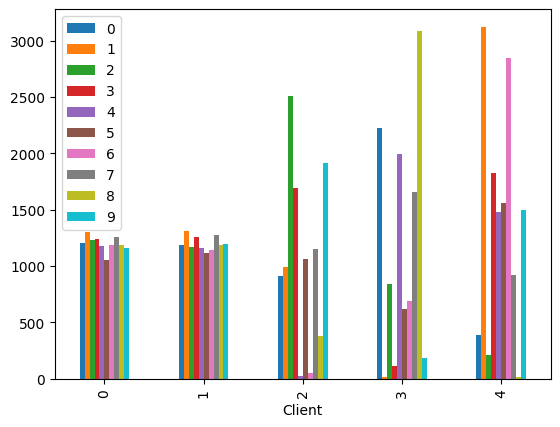

In [4]:
ClientDatasetManager.plot_dataset_splits(res.client_datasets)


In [10]:
res.global_model = res.global_model.to('cuda')

In [6]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

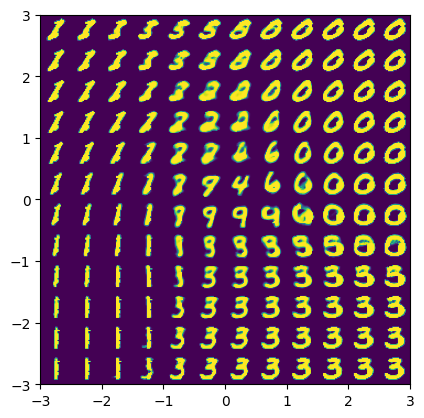

In [7]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


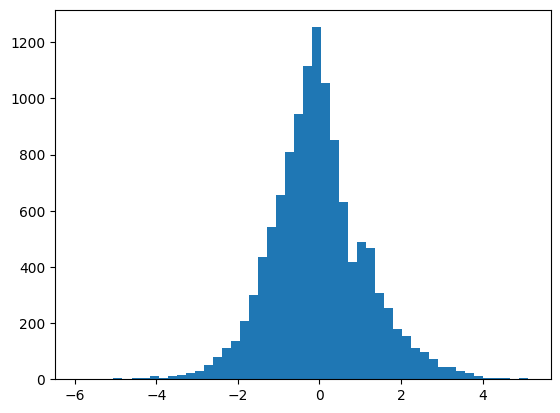

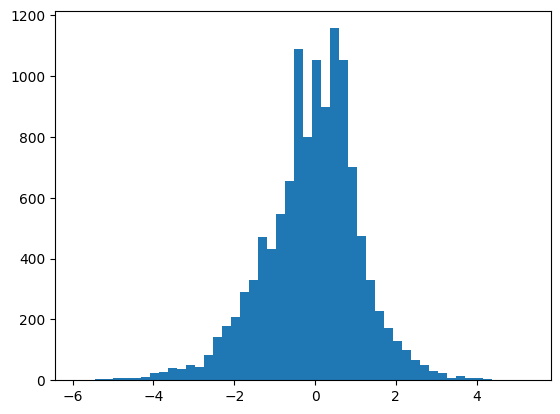

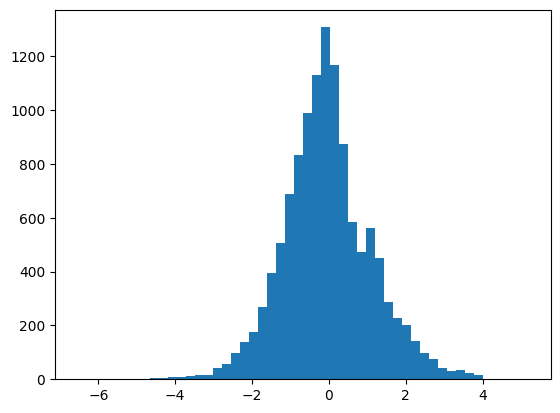

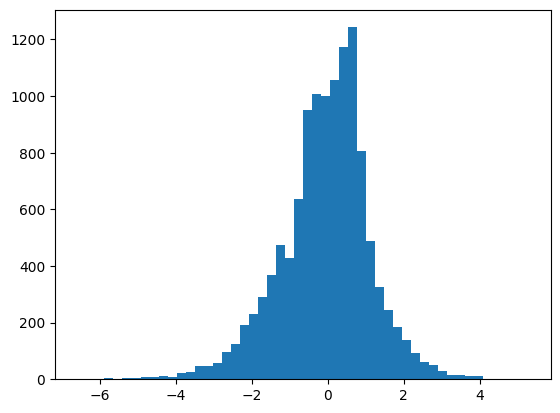

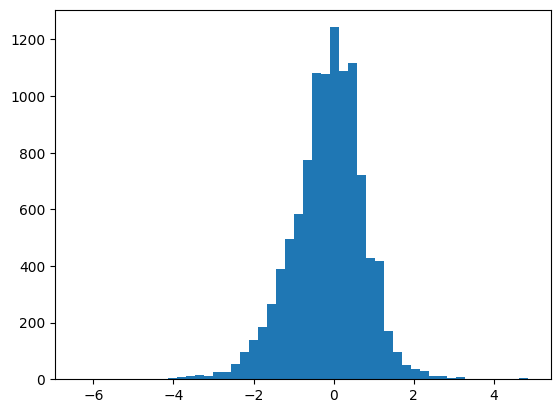

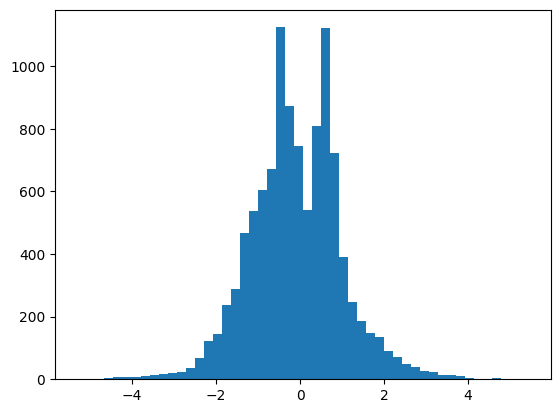

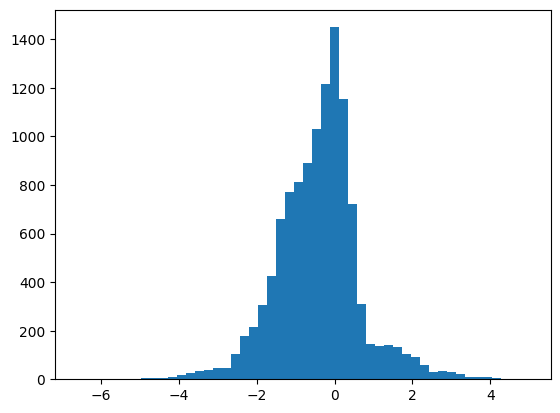

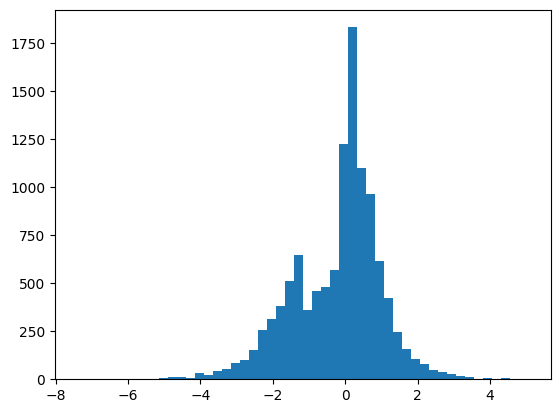

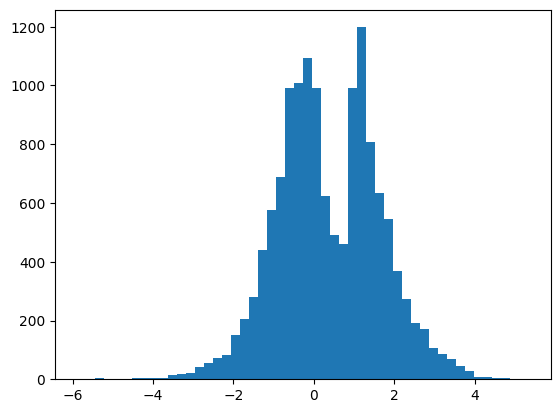

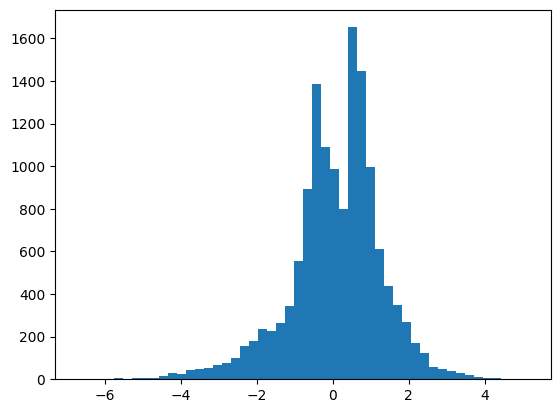

In [5]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets, 1.0,0.0)


In [6]:
print(f"Original Weights: {calculate_relative_dataset_sizes(res.client_datasets)}")
print(f"New Weights: {trial_weights}")

Original Weights: [0.2, 0.2, 0.17808333333333334, 0.19066666666666668, 0.23125]
New Weights: [0.22486150984154077, 0.22932833430998875, 0.21810170677959312, 0.14567103755083044, 0.1820374115180469]


In [18]:
second_res = federate(FakeArgs(), trial_weights, res.client_datasets)
second_res.serialise("point_one",FakeArgs())


/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 5, average loss across batches: 638.9008447265625
Finished local epoch 2 out of 5, average loss across batches: 596.1266516113282
Finished local epoch 3 out of 5, average loss across batches: 589.3990148925782
Finished local epoch 4 out of 5, average loss across batches: 586.3436930338542
Finished local epoch 5 out of 5, average loss across batches: 583.9782645670573
(Test Set) user 0 in round 1 totalL: 584.452826953125 mseL: 561.3369413513184 klL: 23.115885801947115
Training user 1 in round 1
Finished local epoch 1 out of 5, average loss across batches: 644.2554996744792
Finished local epoch 2 out of 5, average loss across batches: 608.5575028483073
Finished local epoch 3 out of 5, average loss across batches: 598.5011092122396
Finished local epoch 4 out of 5, average loss across batches: 587.9767134602864
Finished local epoch 5 out of 5, average loss across batches: 581.3606917317709
(Test Set) 

 10%|█         | 1/10 [01:19<11:52, 79.21s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 641.2071828552246

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 5, average loss across batches: 592.6767569986979
Finished local epoch 2 out of 5, average loss across batches: 579.8903987630208
Finished local epoch 3 out of 5, average loss across batches: 575.8749479166667
Finished local epoch 4 out of 5, average loss across batches: 573.3592932128906
Finished local epoch 5 out of 5, average loss across batches: 572.1574035644531
(Test Set) user 0 in round 2 totalL: 575.2465443145752 mseL: 545.5982747283936 klL: 29.64826964621544
Training user 1 in round 2
Finished local epoch 1 out of 5, average loss across batches: 592.186767985026
Finished local epoch 2 out of 5, average loss across batches: 580.3151570638021
Finished local epoch 3 out of 5, average loss across batches: 576.580780843099
Finished local epoch 4 out of 5, average loss across batches: 574.6728177897136
Finished local epoch 5 out of 5, averag

 20%|██        | 2/10 [02:36<10:22, 77.79s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 571.0235426300048

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 5, average loss across batches: 572.7846435546875
Finished local epoch 2 out of 5, average loss across batches: 568.431718343099
Finished local epoch 3 out of 5, average loss across batches: 566.4050179036458
Finished local epoch 4 out of 5, average loss across batches: 565.2467704264322
Finished local epoch 5 out of 5, average loss across batches: 564.0207368977865
(Test Set) user 0 in round 3 totalL: 568.2896408111573 mseL: 535.353580619812 klL: 32.93605997667313
Training user 1 in round 3
Finished local epoch 1 out of 5, average loss across batches: 573.5968538411458
Finished local epoch 2 out of 5, average loss across batches: 569.0646048990885
Finished local epoch 3 out of 5, average loss across batches: 567.301523030599
Finished local epoch 4 out of 5, average loss across batches: 566.234452718099
Finished local epoch 5 out of 5, average 

 30%|███       | 3/10 [03:53<09:02, 77.43s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 548.6201179870606

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 5, average loss across batches: 565.2249833170573
Finished local epoch 2 out of 5, average loss across batches: 562.5951700846355
Finished local epoch 3 out of 5, average loss across batches: 561.2073136393229
Finished local epoch 4 out of 5, average loss across batches: 560.532411702474
Finished local epoch 5 out of 5, average loss across batches: 559.6679947916666
(Test Set) user 0 in round 4 totalL: 563.7676538208008 mseL: 530.0604564682006 klL: 33.707197373008725
Training user 1 in round 4
Finished local epoch 1 out of 5, average loss across batches: 565.7459505208334
Finished local epoch 2 out of 5, average loss across batches: 563.5036507161458
Finished local epoch 3 out of 5, average loss across batches: 562.4425760904948
Finished local epoch 4 out of 5, average loss across batches: 560.719473063151
Finished local epoch 5 out of 5, avera

 40%|████      | 4/10 [05:09<07:42, 77.16s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 538.7538932098389

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 5, average loss across batches: 561.1631660970052
Finished local epoch 2 out of 5, average loss across batches: 559.2933719889323
Finished local epoch 3 out of 5, average loss across batches: 558.3025697835286
Finished local epoch 4 out of 5, average loss across batches: 557.2678670247395
Finished local epoch 5 out of 5, average loss across batches: 557.4321171061198
(Test Set) user 0 in round 5 totalL: 561.7811337341309 mseL: 527.4266392501831 klL: 34.35449449234009
Training user 1 in round 5
Finished local epoch 1 out of 5, average loss across batches: 561.0382887776693
Finished local epoch 2 out of 5, average loss across batches: 559.534736328125
Finished local epoch 3 out of 5, average loss across batches: 558.9236490885417
Finished local epoch 4 out of 5, average loss across batches: 558.4176131184896
Finished local epoch 5 out of 5, avera

 50%|█████     | 5/10 [06:27<06:26, 77.33s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 534.6264516326904

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 5, average loss across batches: 558.1558467610677
Finished local epoch 2 out of 5, average loss across batches: 557.2994075520834
Finished local epoch 3 out of 5, average loss across batches: 556.3320556640625
Finished local epoch 4 out of 5, average loss across batches: 555.6129085286458
Finished local epoch 5 out of 5, average loss across batches: 555.3418103027344
(Test Set) user 0 in round 6 totalL: 559.3747639556884 mseL: 523.8077261749268 klL: 35.567038063621524
Training user 1 in round 6
Finished local epoch 1 out of 5, average loss across batches: 558.6832840983072
Finished local epoch 2 out of 5, average loss across batches: 557.8192810058594
Finished local epoch 3 out of 5, average loss across batches: 556.9104663085938
Finished local epoch 4 out of 5, average loss across batches: 556.5947692871093
Finished local epoch 5 out of 5, ave

 60%|██████    | 6/10 [07:45<05:09, 77.44s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 530.7081052856445

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 5, average loss across batches: 556.6444877115886
Finished local epoch 2 out of 5, average loss across batches: 555.2878780110677
Finished local epoch 3 out of 5, average loss across batches: 554.5606262207032
Finished local epoch 4 out of 5, average loss across batches: 554.2220796712239
Finished local epoch 5 out of 5, average loss across batches: 553.5904203287761
(Test Set) user 0 in round 7 totalL: 558.1382139068603 mseL: 524.7769818191529 klL: 33.361232140922546
Training user 1 in round 7
Finished local epoch 1 out of 5, average loss across batches: 556.2561319986979
Finished local epoch 2 out of 5, average loss across batches: 555.9275736490886
Finished local epoch 3 out of 5, average loss across batches: 555.7402396647135
Finished local epoch 4 out of 5, average loss across batches: 554.8092338053385
Finished local epoch 5 out of 5, ave

 70%|███████   | 7/10 [09:01<03:51, 77.11s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 529.5903315933227

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 5, average loss across batches: 554.3350911458333
Finished local epoch 2 out of 5, average loss across batches: 553.7612805175781
Finished local epoch 3 out of 5, average loss across batches: 553.4626326497396
Finished local epoch 4 out of 5, average loss across batches: 552.9418615722657
Finished local epoch 5 out of 5, average loss across batches: 552.244424235026
(Test Set) user 0 in round 8 totalL: 556.441422970581 mseL: 520.254783555603 klL: 36.18663948402405
Training user 1 in round 8
Finished local epoch 1 out of 5, average loss across batches: 554.9618811035157
Finished local epoch 2 out of 5, average loss across batches: 554.111064046224
Finished local epoch 3 out of 5, average loss across batches: 554.0588730875651
Finished local epoch 4 out of 5, average loss across batches: 553.5253959147135
Finished local epoch 5 out of 5, average 

 80%|████████  | 8/10 [10:18<02:33, 76.98s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 527.9169193984985

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 5, average loss across batches: 553.716846516927
Finished local epoch 2 out of 5, average loss across batches: 553.0771311442057
Finished local epoch 3 out of 5, average loss across batches: 552.7951371256511
Finished local epoch 4 out of 5, average loss across batches: 552.5526733398438
Finished local epoch 5 out of 5, average loss across batches: 552.1860953776041
(Test Set) user 0 in round 9 totalL: 556.0499341003418 mseL: 520.5459482147216 klL: 35.503985866832735
Training user 1 in round 9
Finished local epoch 1 out of 5, average loss across batches: 555.1120625813802
Finished local epoch 2 out of 5, average loss across batches: 553.9478344726563
Finished local epoch 3 out of 5, average loss across batches: 553.2208581542968
Finished local epoch 4 out of 5, average loss across batches: 552.7978409830729
Finished local epoch 5 out of 5, aver

 90%|█████████ | 9/10 [11:34<01:16, 76.86s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 525.9717698104859

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 5, average loss across batches: 553.4094919840495
Finished local epoch 2 out of 5, average loss across batches: 552.8634948730469
Finished local epoch 3 out of 5, average loss across batches: 552.2051574707032
Finished local epoch 4 out of 5, average loss across batches: 551.9498942057292
Finished local epoch 5 out of 5, average loss across batches: 551.5202067057292
(Test Set) user 0 in round 10 totalL: 555.9447725433349 mseL: 519.3150717147827 klL: 36.62970102405548
Training user 1 in round 10
Finished local epoch 1 out of 5, average loss across batches: 553.712373046875
Finished local epoch 2 out of 5, average loss across batches: 552.9775406901042
Finished local epoch 3 out of 5, average loss across batches: 552.7644148763021
Finished local epoch 4 out of 5, average loss across batches: 552.2897263590495
Finished local epoch 5 out of 5, a

100%|██████████| 10/10 [12:51<00:00, 77.12s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 524.9378102752686
TRAINING ALL DONE!


In [19]:
a = res.global_loss_manager.validation_total_across_communication
o1, o2, o3, o4, o5, o6 = ClientLossManager.process_data(res.all_losses)

In [20]:
b = second_res.global_loss_manager.validation_total_across_communication
n1, n2, n3 , n4, n5, n6 = ClientLossManager.process_data(second_res.all_losses)

In [23]:
list(zip(o3,n3))

[(17.061231844675667, 17.061231844675667),
 (24.7554290044533, 24.96870051571823),
 (28.68751248506981, 29.122401118450348),
 (30.96500089704382, 31.317722676856317),
 (32.468053981031424, 32.598747411165846),
 (33.509776696597996, 33.459650961457974),
 (34.390274985899076, 34.14916906517007),
 (34.9858735730641, 34.64940765593426),
 (35.496326774024055, 35.13637660343303),
 (35.99988029041289, 35.47304274554265)]